In [41]:
# =============================================================================
# CÓDIGO ACTUALIZADO CON MULTI-STEP OUTPUT
# Autor: Alexander Valdez Portocarrero (Actualizado)
# Descripción: Predicción de secuencias completas con validación temporal
# =============================================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# =============================================================================
# 1. CARGA DE DATOS
# =============================================================================
def cargar_dataset(path, filename):
    """
    Carga el CSV y realiza la conversión inicial de fechas.
    """
    full_path = os.path.join(path, filename)
    
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"No se encontró el archivo en: {full_path}")
    
    print(f"📂 Cargando archivo: {filename}...")
    df = pd.read_csv(full_path)
    
    # Conversión única y definitiva a datetime
    df["Tiempo"] = pd.to_datetime(df["Tiempo"])
    
    # Ordenar cronológicamente (vital para series temporales)
    df = df.sort_values("Tiempo")
    
    print(f"✅ Dataset cargado. Shape: {df.shape}")
    print(f"   Rango de fechas: {df['Tiempo'].min()} a {df['Tiempo'].max()}")
    return df

# =============================================================================
# 2. ANÁLISIS EXPLORATORIO (EDA)
# =============================================================================
def analizar_eventos_cintilacion(df, umbral_s4=0.6, plot=True):
    """
    Analiza y visualiza los días con presencia de cintilación.
    No modifica el DF original permanentemente, solo reporta estadísticas.
    """
    print("\n🔍 Analizando distribución de eventos...")
    
    # Trabajamos con una copia ligera para no alterar el original
    df_analisis = df[["Tiempo", "S4"]].copy()
    df_analisis["Fecha"] = df_analisis["Tiempo"].dt.date
    
    # 1. Identificar si cada día superó el umbral
    resumen_diario = df_analisis.groupby("Fecha")["S4"].max() > umbral_s4
    resumen_diario = resumen_diario.reset_index()
    resumen_diario.columns = ["Fecha", "Evento_Cintilacion"] # True/False
    
    total_dias = resumen_diario["Fecha"].nunique()
    dias_con_evento = resumen_diario["Evento_Cintilacion"].sum()
    
    print(f"   Total de días registrados: {total_dias}")
    print(f"   Días con eventos (S4 > {umbral_s4}): {dias_con_evento}")
    print(f"   Porcentaje de actividad: {(dias_con_evento/total_dias)*100:.2f}%")
    
    # 2. Reporte Mensual
    df_analisis["Mes"] = df_analisis["Tiempo"].dt.to_period("M")
    
    # Unimos para saber qué día tuvo evento
    # Primero agrupamos por día para saber si ESE día hubo evento
    max_s4_dia = df_analisis.groupby(["Mes", "Fecha"])["S4"].max().reset_index()
    max_s4_dia["Tuvo_Evento"] = (max_s4_dia["S4"] > umbral_s4).astype(int)
    
    # Tabla resumen
    tabla_mensual = max_s4_dia.groupby("Mes")["Tuvo_Evento"].agg(
        Dias_Con_Cintilacion='sum',
        Total_Dias='count'
    )
    tabla_mensual["Dias_Sin_Cintilacion"] = tabla_mensual["Total_Dias"] - tabla_mensual["Dias_Con_Cintilacion"]
    
    print("\n📊 Resumen Mensual de Actividad:")
    print(tabla_mensual)

    # 3. Visualización (Opcional)
    if plot:
        plt.figure(figsize=(12, 5))
        # Convertimos a string para que matplotlib no haga lío con fechas
        fechas_str = resumen_diario["Fecha"].astype(str)
        valores = resumen_diario["Evento_Cintilacion"].astype(int)
        
        plt.bar(fechas_str, valores, color=np.where(valores==1, 'orange', 'skyblue'))
        plt.title(f"Días con Cintilación (S4 > {umbral_s4})")
        plt.ylabel("Presencia (1=Sí, 0=No)")
        plt.xticks(rotation=90, fontsize=8)
        
        # Mostrar solo una etiqueta cada 7 días para no saturar
        ax = plt.gca()
        for index, label in enumerate(ax.xaxis.get_ticklabels()):
            if index % 7 != 0:
                label.set_visible(False)
                
        plt.tight_layout()
        plt.show()

# =============================================================================
# 3. INGENIERÍA DE CARACTERÍSTICAS (FEATURE ENGINEERING)
# =============================================================================
def agregar_caracteristicas_temporales(df):
    """
    Agrega transformaciones cíclicas de tiempo (Seno/Coseno).
    """
    print("\n⚙️ Generando características temporales (Sin/Cos)...")
    
    # Calcular minuto del día (0–1439)
    minutos_dia = df["Tiempo"].dt.hour * 60 + df["Tiempo"].dt.minute
    periodo = 24 * 60 # 1440 minutos
    
    # Transformación
    df["Hora_Sin"] = np.sin(2 * np.pi * minutos_dia / periodo)
    df["Hora_Cos"] = np.cos(2 * np.pi * minutos_dia / periodo)
    
    return df

# =============================================================================
# 4. PREPARACIÓN FINAL DE ESTRUCTURA
# =============================================================================
def finalizar_estructura_df(df, target_col="S4"):
    """
    Limpia columnas auxiliares, reordena y establece el índice temporal.
    Esta función deja el DF listo para entrar al Generador de Ventanas.
    """
    print("\n🧹 Finalizando estructura del DataFrame...")
    
    # 1. Asegurar índice temporal
    if df.index.name != 'Tiempo':
        df = df.set_index('Tiempo')
    
    df = df.sort_index()
    
    # 2. Reordenar columnas: Target al final (práctica estándar)
    cols = [c for c in df.columns if c != target_col]
    cols.append(target_col)
    df = df[cols]
    
    # 3. Eliminar columnas que ya no sirven para el modelo numérico
    # (Ej: Fechas string, columnas categóricas, etc.)
    cols_a_borrar = ["dias", "Fecha", "Mes", "minuto_del_dia", "Cintilacion"]
    # Borramos solo si existen
    cols_existentes = [c for c in cols_a_borrar if c in df.columns]
    
    if cols_existentes:
        df = df.drop(columns=cols_existentes)
        print(f"   Columnas eliminadas: {cols_existentes}")
        
    print(f"✅ DataFrame Final Listo. Shape: {df.shape}")
    print(f"   Columnas finales: {df.columns.tolist()}")
    
    return df

# =============================================================================
# 5. ESTRATEGIA DE DIVISIÓN DE DATOS (DATA SPLITTING)
# =============================================================================
def dividir_estratificado_por_dias(df, umbral_s4=0.6):
    """
    Divide el dataset asegurando que haya días con tormentas en Train, Val y Test.
    """
    print("\n✂️ Ejecutando división estratificada de datos...")
    
    # Trabajamos con copia para no afectar el original
    temp_df = df.copy()
    
    # Si la columna Fecha no existe (porque la borramos en el paso 4), la recuperamos del índice
    if 'Fecha' not in temp_df.columns:
        temp_df['Fecha'] = temp_df.index.date
    
    # 1. Identificar Días Activos vs Días Quietos
    resumen_diario = temp_df.groupby('Fecha')['S4'].max().reset_index()
    
    dias_activos = resumen_diario[resumen_diario['S4'] > umbral_s4]['Fecha'].values
    dias_quietos_original = resumen_diario[resumen_diario['S4'] <= umbral_s4]['Fecha'].values 
    #dias_quietos = resumen_diario[resumen_diario['S4'] <= umbral_s4]['Fecha'].values 

    #------ AQUI VAMOS A MODIFICAR--------#
    n_activos = len(dias_activos)
    dias_quietos = dias_quietos_original[:n_activos]
    #dias_quietos = resumen_diario[resumen_diario['S4'] <= umbral_s4]['Fecha'].values
    #--------------------------------------------------------------------------------
    
    print(f"   Total Días Activos encontrados: {len(dias_activos)}")
    print(f"   Total Días Quietos encontrados: {len(dias_quietos)}")
    
    # 2. Repartir los Días ACTIVOS (aprox 70/15/15)
    # Primero separamos Train (70%) del resto (30%)
    activos_train, activos_temp = train_test_split(dias_activos, test_size=0.3, random_state=42)
    # Luego separamos ese resto en Val (50% del resto) y Test (50% del resto)
    activos_val, activos_test = train_test_split(activos_temp, test_size=0.5, random_state=42)
    
    # 3. Repartir los Días QUIETOS (misma lógica)
    quietos_train, quietos_temp = train_test_split(dias_quietos, test_size=0.3, random_state=42)
    quietos_val, quietos_test = train_test_split(quietos_temp, test_size=0.5, random_state=42)
    
    # 4. Combinar las listas
    lista_dias_train = np.concatenate([activos_train, quietos_train])
    lista_dias_val = np.concatenate([activos_val, quietos_val])
    lista_dias_test = np.concatenate([activos_test, quietos_test])
    
    # 5. Crear los DataFrames Finales
    # Ordenamos por fecha para mantener la lógica temporal interna
    # NOTA: Usamos temp_df['Fecha'] para filtrar, pero devolvemos df (el original limpio)
    #       Para asegurar consistencia, filtramos temp_df y luego dropeamos 'Fecha' si fue agregada,
    #       o simplemente usamos el índice.
    
    # Filtrar usando las fechas
    train = temp_df[temp_df['Fecha'].isin(lista_dias_train)].sort_index()
    val = temp_df[temp_df['Fecha'].isin(lista_dias_val)].sort_index()
    test = temp_df[temp_df['Fecha'].isin(lista_dias_test)].sort_index()
    
    # Limpieza final: Si agregamos 'Fecha' temporalmente, la quitamos para dejar los datos limpios
    if 'Fecha' in train.columns:
        train = train.drop(columns=['Fecha'])
        val = val.drop(columns=['Fecha'])
        test = test.drop(columns=['Fecha'])
    
    return train, val, test

def auditar_division_datos(df, nombre_set, umbral_s4=0.6):
    """
    Función auxiliar para verificar que cada set tenga eventos.
    """
    # Recuperamos fecha del índice para el análisis
    fechas = df.index.date
    s4_values = df['S4'].values
    
    # Dataframe temporal para agrupar
    df_temp = pd.DataFrame({'Fecha': fechas, 'S4': s4_values})
    
    # Contar
    dias_totales = df_temp['Fecha'].nunique()
    dias_con_evento = df_temp[df_temp['S4'] > umbral_s4]['Fecha'].nunique()
    
    porcentaje = 0
    if dias_totales > 0:
        porcentaje = (dias_con_evento / dias_totales) * 100
        
    print(f"--- AUDITORÍA: {nombre_set.upper()} ---")
    print(f"📅 Días totales: {dias_totales}")
    print(f"⚡ Días con Cintilación: {dias_con_evento}")
    print(f"📊 Porcentaje actividad: {porcentaje:.2f}%")
    
    if dias_con_evento == 0:
        print(f"⚠️ PELIGRO: {nombre_set} NO tiene eventos. El modelo fallará aquí.")
    else:
        print("✅ Set válido.")
    print("-" * 30)

# =============================================================================
# 6. NORMALIZACIÓN DE DATOS (SCALING)
# =============================================================================
def escalar_preservando_indices(df_subset, scaler, cols, is_train=False):
    """
    Normaliza un DataFrame pero devuelve otro DataFrame con el mismo índice temporal.
    """
    if df_subset.empty: 
        return df_subset
    
    # IMPORTANTE: Solo 'aprendemos' (fit) los máximos y mínimos con el set de TRAIN
    if is_train:
        scaler.fit(df_subset[cols])
    
    # Transformamos los datos (Matriz numpy)
    scaled_values = scaler.transform(df_subset[cols])
    
    # Reconstruimos el DataFrame pegándole el índice original
    df_scaled = pd.DataFrame(
        scaled_values, 
        columns=cols, 
        index=df_subset.index 
    )
    
    # Añadimos la columna 'Fecha' para referencia (útil para depuración)
    # Si la columna no existe en el subset, la extraemos del índice
    if 'Fecha' in df_subset.columns:
        df_scaled['Fecha'] = df_subset['Fecha'].values
    else:
        df_scaled['Fecha'] = df_subset.index.date
    
    return df_scaled

def normalizar_sets(train_df, val_df, test_df, features_cols):
    """
    Aplica la normalización a los tres conjuntos de datos usando MinMaxScaler.
    """
    print("\n⚖️ Ejecutando Normalización (MinMaxScaler 0-1)...")
    
    # Inicializamos el escalador
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # 1. Normalizamos TRAIN (Aquí aprende el scaler)
    print("   -> Normalizando Train (Fit & Transform)")
    train_scaled = escalar_preservando_indices(train_df, scaler, features_cols, is_train=True)
    
    # 2. Normalizamos VAL y TEST (Usando lo aprendido en Train)
    print("   -> Normalizando Val (Transform only)")
    val_scaled = escalar_preservando_indices(val_df, scaler, features_cols, is_train=False)
    
    print("   -> Normalizando Test (Transform only)")
    test_scaled = escalar_preservando_indices(test_df, scaler, features_cols, is_train=False)
    
    # Verificación
    s4_min_orig = train_df['S4'].min()
    s4_max_orig = train_df['S4'].max()
    s4_min_scal = train_scaled['S4'].min()
    s4_max_scal = train_scaled['S4'].max()
    
    print(f"   ✅ Normalización completada.")
    print(f"   Rango S4 Original (Train): {s4_min_orig:.4f} a {s4_max_orig:.4f}")
    print(f"   Rango S4 Escalado (Train): {s4_min_scal:.4f} a {s4_max_scal:.4f}")
    
    return train_scaled, val_scaled, test_scaled, scaler


# =============================================================================
# 7. GENERACIÓN DE VENTANAS MULTI-STEP (ACTUALIZADO)
# =============================================================================

def crear_dataset_lstm_multistep_con_gaps(df, cols_input, col_target, lookback=60, horizon=20):
    """
    Genera tensores X e y con validación temporal rigurosa.
    
    CAMBIO CLAVE: Ahora y contiene una SECUENCIA de 'horizon' valores futuros,
    no solo un punto.
    
    Args:
        df: DataFrame con índice temporal
        cols_input: Lista de columnas para features de entrada
        col_target: Nombre de la columna objetivo (e.g., 'S4')
        lookback: Ventana de entrada (minutos hacia atrás)
        horizon: Ventana de salida (minutos hacia adelante)
    
    Returns:
        X: shape (m, lookback, n_features) - Ventanas de entrada
        y: shape (m, horizon) - SECUENCIAS de salida
    """
    # 1. Preparación de datos
    data_values = df[cols_input].values  
    target_values = df[col_target].values
    timestamps = df.index.to_series().values
    
    X, y = [], []
    
    # 2. Bucle Principal con Validación Temporal
    for i in range(lookback, len(df) - horizon):
        
        # --- VALIDACIÓN TEMPORAL (GAP CONTROL) ---
        t_inicio = timestamps[i - lookback]      # Inicio de ventana de entrada
        t_actual = timestamps[i]                  # Fin de ventana de entrada (presente)
        t_fin_secuencia = timestamps[i + horizon - 1]  # Último punto de la secuencia de salida
        
        # Verificar continuidad de la ventana de ENTRADA
        diff_entrada = (t_actual - t_inicio) / np.timedelta64(1, 'm')
        if diff_entrada != lookback:
            continue
        
        # Verificar continuidad de la secuencia de SALIDA
        diff_salida = (t_fin_secuencia - t_actual) / np.timedelta64(1, 'm')
        if diff_salida != (horizon - 1):  # horizon-1 porque empezamos en i (no en i+1)
            continue
        
        # Verificación adicional: Comprobar que NO hay gaps dentro de la secuencia de salida
        hay_gap_en_salida = False
        for j in range(i, i + horizon - 1):
            diff_consecutiva = (timestamps[j + 1] - timestamps[j]) / np.timedelta64(1, 'm')
            if diff_consecutiva != 1:
                hay_gap_en_salida = True
                break
        
        if hay_gap_en_salida:
            continue
        
        # --- SI PASA TODAS LAS VALIDACIONES, GUARDAMOS ---
        ventana_entrada = data_values[i - lookback : i]  # [t-60, t-59, ..., t-1]
        
        # CAMBIO CLAVE: Secuencia completa de salida
        secuencia_salida = target_values[i : i + horizon]  # [t, t+1, ..., t+19]
        
        X.append(ventana_entrada)
        y.append(secuencia_salida)
    
    return np.array(X), np.array(y)


def generar_tensores_multistep(train_scaled, val_scaled, test_scaled, features_cols, 
                                target_col='S4', lookback=60, horizon=20):
    """
    Función orquestadora para generar los tensores MULTI-STEP de Train, Val y Test.
    
    CAMBIO: Ahora y tiene shape (m, horizon) en lugar de (m,)
    """
    print(f"\n🎞️ Generando Ventanas Deslizantes MULTI-STEP (Lookback={lookback}, Horizon={horizon})...")
    print(f"   Features ({len(features_cols)}): {features_cols}")
    print(f"   ⚡ Output esperado: SECUENCIAS de {horizon} valores futuros")
    
    # 1. Train
    X_train, y_train = crear_dataset_lstm_multistep_con_gaps(
        train_scaled, features_cols, target_col, lookback, horizon
    )
    print(f"   ✅ TRAIN generado. X: {X_train.shape}, y: {y_train.shape}")
    
    # 2. Val
    X_val, y_val = crear_dataset_lstm_multistep_con_gaps(
        val_scaled, features_cols, target_col, lookback, horizon
    )
    print(f"   ✅ VAL generado.   X: {X_val.shape}, y: {y_val.shape}")
    
    # 3. Test
    X_test, y_test = crear_dataset_lstm_multistep_con_gaps(
        test_scaled, features_cols, target_col, lookback, horizon
    )
    print(f"   ✅ TEST generado.  X: {X_test.shape}, y: {y_test.shape}")
    
    # Verificación
    print("\n--- DIMENSIONES FINALES (Tensor Shapes) ---")
    print(f"   X_train: {X_train.shape}  (muestras, lookback, features)")
    print(f"   y_train: {y_train.shape}  (muestras, horizon) ← SECUENCIAS")
    
    return X_train, y_train, X_val, y_val, X_test, y_test


# =============================================================================
# 8. MODELADO LSTM MULTI-STEP (ACTUALIZADO)
# =============================================================================

def weighted_mse_multistep(threshold, penalty_weight=15.0):
    """
    Loss ponderada para predicción de SECUENCIAS multi-step.
    Penaliza más los errores en valores altos DENTRO de toda la secuencia.
    
    Args:
        threshold: Umbral normalizado de S4 (e.g., 0.6 normalizado)
        penalty_weight: Factor multiplicador para eventos críticos
    """
    def loss(y_true, y_pred):
        # y_true shape: (batch, horizon)
        # y_pred shape: (batch, horizon)
        
        # Error cuadrático base
        squared_error = tf.square(y_pred - y_true)
        
        # Ponderación: Penalizar más donde y_true >= threshold
        weights = tf.where(y_true >= threshold, penalty_weight, 1.0)
        
        # Penalización adicional por subestimación en picos
        underestimation_mask = tf.logical_and(
            y_true >= threshold,
            y_pred < y_true
        )
        underestimation_penalty = tf.where(underestimation_mask, 2.0, 1.0)
        
        # Loss total ponderada
        weighted_error = squared_error * weights * underestimation_penalty
        
        # Promediamos sobre toda la secuencia y el batch
        return tf.reduce_mean(weighted_error)
    
    return loss


def weighted_focal_mse_multistep(threshold, alpha=2.0, beta=50.0):
    """
    Loss híbrida Focal para SECUENCIAS multi-step.
    Combina ponderación con penalización exponencial de errores grandes.
    
    Args:
        threshold: Umbral normalizado
        alpha: Exponente focal (mayor = más agresivo)
        beta: Multiplicador para eventos sobre umbral
    """
    def loss(y_true, y_pred):
        # Error base
        error = y_pred - y_true
        squared_error = tf.square(error)
        
        # COMPONENTE 1: Ponderación por umbral
        weights = tf.where(y_true >= threshold, beta, 1.0)
        
        # COMPONENTE 2: Penalización focal
        focal_weight = tf.pow(tf.abs(error) + 1e-7, alpha)
        
        # COMPONENTE 3: Extra penalización por subestimación
        underestimation_mask = tf.logical_and(
            y_true >= threshold,
            y_pred < y_true * 0.7  # Subestima más del 30%
        )
        underestimation_penalty = tf.where(underestimation_mask, 2.0, 1.0)
        
        # Combinación
        total_loss = squared_error * weights * focal_weight * underestimation_penalty
        
        return tf.reduce_mean(total_loss)
    
    return loss


def construir_modelo_lstm_multistep(input_shape, output_steps, umbral_norm, penalty=15.0):
    """
    Define y compila la arquitectura LSTM para predicción MULTI-STEP.
    
    Args:
        input_shape: (timesteps, features) ej: (60, 9)
        output_steps: número de valores futuros a predecir (horizon) ej: 20
        umbral_norm: umbral normalizado para la loss
        penalty: factor de penalización
    
    Returns:
        Modelo compilado
    """
    tf.keras.backend.clear_session()
    
    model = Sequential([
        Input(shape=input_shape),
        
        # Encoder: Comprender el contexto pasado
        Bidirectional(LSTM(128, return_sequences=True, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),
        
        Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),
        
        # Decoder: Generar secuencia futura
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(64, activation='relu'),
        
        # SALIDA: Vector de 'output_steps' predicciones
        Dense(output_steps, activation='linear')  # ← Predice todos los pasos
    ], name="LSTM_MultiStep")
    
    # Loss adaptada para multi-step
    loss_fn = weighted_focal_mse_multistep(
        threshold=umbral_norm, 
        alpha=1.5, 
        beta=penalty
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=loss_fn,
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
    )
    
    print("\n🧠 Modelo LSTM Multi-Step Compilado:")
    print(f"   Input:  {input_shape}")
    print(f"   Output: {output_steps} valores futuros")
    model.summary()
    
    return model


def entrenar_modelo_multistep(model, X_train, y_train, X_val, y_val, 
                               batch_size=64, epochs=100):
    """
    Ejecuta el entrenamiento del modelo multi-step con callbacks mejorados.
    """
    callbacks = [
        EarlyStopping(
            monitor='val_loss', 
            patience=15,  # Más paciencia para multi-step
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            filepath='modelo_s4_lstm_multistep_mejor.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    print("\n🚀 Iniciando entrenamiento Multi-Step...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    return history, model


# =============================================================================
# 9. PREDICCIÓN Y DESNORMALIZACIÓN MULTI-STEP (ACTUALIZADO)
# =============================================================================

def desnormalizar_secuencia(data_scaled, scaler, features_cols, col_target='S4'):
    """
    Des-normaliza secuencias multi-step.
    Funciona tanto para arrays 1D como 2D (secuencias).
    
    Args:
        data_scaled: Array escalado (puede ser shape (m,) o (m, horizon))
        scaler: MinMaxScaler ajustado
        features_cols: Lista de columnas de features
        col_target: Nombre de la columna objetivo
    
    Returns:
        Array desnormalizado en la misma forma que la entrada
    """
    idx = features_cols.index(col_target)
    
    val_min = scaler.data_min_[idx]
    val_max = scaler.data_max_[idx]
    val_range = val_max - val_min
    
    # Aplicar fórmula inversa
    data_real = (data_scaled * val_range) + val_min
    
    return data_real


def evaluar_predicciones_multistep(model, X_test, y_test, scaler, features_cols, 
                                    col_target='S4', umbral_real=0.6):
    """
    Genera predicciones MULTI-STEP y las convierte a escala real.
    
    Returns:
        y_pred_real: shape (m, horizon) - Secuencias predichas
        y_test_real: shape (m, horizon) - Secuencias reales
    """
    print("\n🔮 Generando predicciones Multi-Step sobre el Test Set...")
    
    # 1. Predecir secuencias (Escala 0-1)
    y_pred_scaled = model.predict(X_test, verbose=0)
    
    # y_pred_scaled shape: (m, horizon)
    # y_test shape: (m, horizon)
    
    print(f"   Forma predicciones escaladas: {y_pred_scaled.shape}")
    
    # 2. Des-normalizar
    y_pred_real = desnormalizar_secuencia(y_pred_scaled, scaler, features_cols, col_target)
    y_test_real = desnormalizar_secuencia(y_test, scaler, features_cols, col_target)
    
    print(f"✅ Datos convertidos a escala real.")
    print(f"   Forma final: {y_pred_real.shape}")
    print(f"   Ejemplo - Primera secuencia real:    {y_test_real[0, :5]}")
    print(f"   Ejemplo - Primera secuencia predicha: {y_pred_real[0, :5]}")
    
    # 3. MÉTRICAS POR HORIZONTE TEMPORAL
    print("\n📊 Rendimiento por Horizonte Temporal:")
    horizonte_steps = y_test_real.shape[1]
    indices_a_mostrar = [0, horizonte_steps//4, horizonte_steps//2, 
                         3*horizonte_steps//4, horizonte_steps-1]
    
    for h in indices_a_mostrar:
        if h < horizonte_steps:
            rmse_h = np.sqrt(mean_squared_error(y_test_real[:, h], y_pred_real[:, h]))
            mae_h = mean_absolute_error(y_test_real[:, h], y_pred_real[:, h])
            print(f"   t+{h:2d} min → RMSE: {rmse_h:.4f}, MAE: {mae_h:.4f}")
    
    return y_pred_real, y_test_real


# =============================================================================
# 10. EVALUACIÓN Y VISUALIZACIÓN MULTI-STEP (ACTUALIZADO)
# =============================================================================

def evaluar_rendimiento_multistep(y_true, y_pred, umbral_evento=0.6):
    """
    Calcula métricas para predicciones MULTI-STEP.
    
    Args:
        y_true: shape (m, horizon)
        y_pred: shape (m, horizon)
        umbral_evento: umbral de S4 para considerar evento
    
    Returns:
        Tupla (rmse_global, rmse_eventos, mae_global, mae_eventos)
    """
    # Aplanar las secuencias para métricas globales
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # 1. Métricas Globales
    rmse_global = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    mae_global = mean_absolute_error(y_true_flat, y_pred_flat)
    
    # 2. Métricas solo en Eventos
    mask_eventos = y_true_flat >= umbral_evento
    
    if np.sum(mask_eventos) > 0:
        rmse_eventos = np.sqrt(mean_squared_error(
            y_true_flat[mask_eventos], 
            y_pred_flat[mask_eventos]
        ))
        mae_eventos = mean_absolute_error(
            y_true_flat[mask_eventos], 
            y_pred_flat[mask_eventos]
        )
    else:
        rmse_eventos = 0
        mae_eventos = 0
        print("⚠️ No se encontraron eventos > 0.6 en este set de datos.")
    
    print(f"\n--- REPORTE DE RENDIMIENTO MULTI-STEP ---")
    print(f"📊 Métricas Globales (todas las predicciones):")
    print(f"   Global RMSE: {rmse_global:.4f}")
    print(f"   Global MAE:  {mae_global:.4f}")
    print(f"-"*50)
    print(f"⚡ Métricas en Eventos (S4 > {umbral_evento}):")
    print(f"   Event RMSE:  {rmse_eventos:.4f}")
    print(f"   Event MAE:   {mae_eventos:.4f}")
    print(f"   Puntos en eventos: {np.sum(mask_eventos)} / {len(y_true_flat)}")
    
    return rmse_global, rmse_eventos, mae_global, mae_eventos


def visualizar_prediccion_multistep(y_real, y_pred, idx_muestra=0, umbral=0.6):
    """
    Visualiza UNA secuencia multi-step específica.
    
    Args:
        y_real: shape (m, horizon)
        y_pred: shape (m, horizon)
        idx_muestra: índice de la muestra a visualizar
        umbral: umbral de S4 para graficar
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    horizonte = y_real.shape[1]
    x_axis = np.arange(horizonte)
    
    # Serie real
    ax.plot(x_axis, y_real[idx_muestra], 
            label='Secuencia Real', 
            color='black', 
            linewidth=2.5, 
            marker='o',
            markersize=6,
            alpha=0.8)
    
    # Serie predicha
    ax.plot(x_axis, y_pred[idx_muestra], 
            label='Secuencia Predicha', 
            color='red', 
            linewidth=2.5, 
            marker='s',
            markersize=5,
            linestyle='--',
            alpha=0.9)
    
    # Umbral
    ax.axhline(y=umbral, color='orange', linestyle=':', linewidth=2, 
               alpha=0.5, label=f'Umbral S4 = {umbral}')
    
    # Calcular error de esta secuencia
    rmse_seq = np.sqrt(mean_squared_error(y_real[idx_muestra], y_pred[idx_muestra]))
    mae_seq = mean_absolute_error(y_real[idx_muestra], y_pred[idx_muestra])
    
    ax.set_xlabel('Horizonte Temporal (minutos futuros)', fontweight='bold', fontsize=12)
    ax.set_ylabel('Índice S4', fontweight='bold', fontsize=12)
    ax.set_title(f'Predicción Multi-Step - Muestra #{idx_muestra}\n' + 
                f'RMSE: {rmse_seq:.4f}, MAE: {mae_seq:.4f}', 
                fontweight='bold', fontsize=13)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def visualizar_resultados_finales_multistep(y_true, y_pred, umbral=0.6, n_ejemplos=3):
    """
    Orquesta la visualización de múltiples predicciones multi-step.
    
    Args:
        y_true: shape (m, horizon)
        y_pred: shape (m, horizon)
        umbral: umbral de S4
        n_ejemplos: cuántas secuencias mostrar
    """
    # 1. Encontrar índices de interés
    # - Secuencia con mayor pico real
    max_peaks = y_true.max(axis=1)
    idx_max_peak = np.argmax(max_peaks)
    
    # - Secuencia con mayor error
    errors = np.sqrt(((y_true - y_pred)**2).mean(axis=1))
    idx_max_error = np.argmax(errors)
    
    # - Secuencia aleatoria
    idx_random = np.random.randint(0, len(y_true))
    
    indices = [idx_max_peak, idx_max_error, idx_random]
    titulos = [
        f"Secuencia con MAYOR PICO (S4 máx = {y_true[idx_max_peak].max():.3f})",
        f"Secuencia con MAYOR ERROR (RMSE = {errors[idx_max_error]:.3f})",
        f"Secuencia ALEATORIA (índice {idx_random})"
    ]
    
    # 2. Graficar
    fig, axes = plt.subplots(len(indices), 1, figsize=(16, 5*len(indices)))
    
    if len(indices) == 1:
        axes = [axes]
    
    for ax, idx, titulo in zip(axes, indices, titulos):
        horizonte = y_true.shape[1]
        x_axis = np.arange(horizonte)
        
        # Real
        ax.plot(x_axis, y_true[idx], 
               label='Real', 
               color='black', 
               linewidth=2.5, 
               marker='o',
               markersize=5,
               alpha=0.7)
        
        # Predicho
        ax.plot(x_axis, y_pred[idx], 
               label='Predicho', 
               color='red', 
               linewidth=2.5, 
               marker='s',
               markersize=4,
               linestyle='--',
               alpha=0.9)
        
        # Umbral
        ax.axhline(y=umbral, color='orange', linestyle=':', linewidth=2, alpha=0.5)
        
        # Error por punto
        rmse_seq = np.sqrt(mean_squared_error(y_true[idx], y_pred[idx]))
        
        ax.set_ylabel('Índice S4', fontweight='bold', fontsize=11)
        ax.set_title(f'{titulo}\nRMSE: {rmse_seq:.4f}', 
                    fontweight='bold', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Horizonte Temporal (minutos futuros)', 
                        fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    plt.show()


def calcular_metricas_multistep(y_true, y_pred, umbral_evento=0.6):
    """
    Calcula métricas y retorna un diccionario para multi-step.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Global
    rmse_global = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    mae_global = mean_absolute_error(y_true_flat, y_pred_flat)
    
    # Eventos
    mask_eventos = y_true_flat >= umbral_evento
    
    if np.sum(mask_eventos) > 0:
        rmse_eventos = np.sqrt(mean_squared_error(
            y_true_flat[mask_eventos], 
            y_pred_flat[mask_eventos]
        ))
        mae_eventos = mean_absolute_error(
            y_true_flat[mask_eventos], 
            y_pred_flat[mask_eventos]
        )
    else:
        rmse_eventos = 0
        mae_eventos = 0
    
    return {
        "Global_RMSE": rmse_global,
        "Global_MAE": mae_global,
        "Event_RMSE": rmse_eventos,
        "Event_MAE": mae_eventos
    }


# =============================================================================
# 11. GESTIÓN DE EXPERIMENTOS MULTI-STEP (ACTUALIZADO)
# =============================================================================

def ejecutar_experimento_iterativo_multistep(train_s, val_s, test_s, features_cols, 
                                             scaler, lookbacks, horizons):
    """
    Ejecuta un Grid Search sobre combinaciones de Lookback y Horizon con MULTI-STEP.
    """
    resultados = []
    total_iteraciones = len(lookbacks) * len(horizons)
    iter_actual = 0
    
    print(f"\n🧪 INICIANDO EXPERIMENTO ITERATIVO MULTI-STEP ({total_iteraciones} Combinaciones)...")
    print(f"   Lookbacks: {lookbacks}")
    print(f"   Horizons:  {horizons}")
    print(f"   🔥 Ahora cada y contiene SECUENCIAS completas")
    print("="*70)
    
    # Umbral constante
    umbral_norm = calcular_umbral_normalizado(scaler, features_cols, umbral_real=0.6)
    
    for lb in lookbacks:
        for hz in horizons:
            iter_actual += 1
            print(f"\n🔄 [{iter_actual}/{total_iteraciones}] Probando: Lookback={lb} min, Horizon={hz} min")
            
            # 1. Generar Tensores Multi-Step
            X_train, y_train, X_val, y_val, X_test, y_test = generar_tensores_multistep(
                train_s, val_s, test_s, features_cols, 
                target_col='S4', lookback=lb, horizon=hz
            )
            
            if X_train.shape[0] == 0:
                print("   ⚠️ Salto: No hay suficientes datos para esta ventana.")
                continue
            
            # 2. Construir Modelo Multi-Step
            input_shape = (X_train.shape[1], X_train.shape[2])
            output_steps = hz  # El horizonte define cuántos valores predecir
            
            model = construir_modelo_lstm_multistep(
                input_shape, output_steps, umbral_norm, penalty=45.0
            )
            
            # 3. Entrenar
            history, _ = entrenar_modelo_multistep(
                model, 
                X_train.astype('float32'), y_train.astype('float32'), 
                X_val.astype('float32'), y_val.astype('float32'), 
                batch_size=64, epochs=60
            )
            
            # 4. Evaluar
            y_pred, y_real = evaluar_predicciones_multistep(
                model, X_test, y_test, scaler, features_cols
            )
            # -------------------------NUEVO------------------------------------------------
            visualizar_resultados_finales_multistep(y_real, y_pred, umbral=0.6, n_ejemplos=3)
            
            metricas = calcular_metricas_multistep(y_real, y_pred, umbral_evento=0.6)
            
            # 5. Guardar Resultados
            registro = {
                "Lookback": lb,
                "Horizon": hz,
                **metricas
            }
            resultados.append(registro)
            
            print(f"   📊 Event RMSE={metricas['Event_RMSE']:.4f} | Global RMSE={metricas['Global_RMSE']:.4f}")
    
    return pd.DataFrame(resultados)


# =============================================================================
# FUNCIÓN AUXILIAR (ya estaba definida pero la incluyo por completitud)
# =============================================================================

def calcular_umbral_normalizado(scaler, features_cols, umbral_real=0.6, col_target='S4'):
    """
    Calcula el equivalente de 0.6 S4 en la escala 0-1.
    """
    idx_target = features_cols.index(col_target)
    
    val_min = scaler.data_min_[idx_target]
    val_max = scaler.data_max_[idx_target]
    
    umbral_norm = (umbral_real - val_min) / (val_max - val_min)
    
    print(f"\n📏 Cálculo de Umbral Normalizado:")
    print(f"   S4 Real: {umbral_real}  =>  S4 Norm: {umbral_norm:.4f}")
    
    return umbral_norm


def visualizar_resultados_experimento(df_resultados):
    """
    Genera tabla y gráficos comparativos.
    """
    print("\n\n🏆 TABLA FINAL DE RESULTADOS ORDENADA POR ERROR EN EVENTOS:")
    df_sorted = df_resultados.sort_values("Event_RMSE")
    print(df_sorted.to_string(index=False))
    
    # Gráfico
    plt.figure(figsize=(14, 6))
    
    # Crear etiquetas para el eje X
    labels = [f"L={row.Lookback}/H={row.Horizon}" for idx, row in df_resultados.iterrows()]
    x = np.arange(len(labels))
    width = 0.35
    
    plt.bar(x - width/2, df_resultados["Event_RMSE"], width, label='Error en Tormentas (RMSE)', color='salmon')
    plt.bar(x + width/2, df_resultados["Global_RMSE"], width, label='Error Global (RMSE)', color='skyblue')
    
    plt.xlabel('Configuración (Lookback / Horizon)')
    plt.ylabel('RMSE (Menor es mejor)')
    plt.title('Comparación de Rendimiento por Configuración Temporal')
    plt.xticks(x, labels, rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


## **PRUEBA INICIAL**

📂 Cargando archivo: df_FINAL.csv...
✅ Dataset cargado. Shape: (204396, 13)
   Rango de fechas: 2025-01-26 00:35:00 a 2025-06-25 23:00:00

🔍 Analizando distribución de eventos...
   Total de días registrados: 148
   Días con eventos (S4 > 0.6): 29
   Porcentaje de actividad: 19.59%

📊 Resumen Mensual de Actividad:
         Dias_Con_Cintilacion  Total_Dias  Dias_Sin_Cintilacion
Mes                                                            
2025-01                     3           6                     3
2025-02                    14          26                    12
2025-03                    10          31                    21
2025-04                     2          29                    27
2025-05                     0          31                    31
2025-06                     0          25                    25


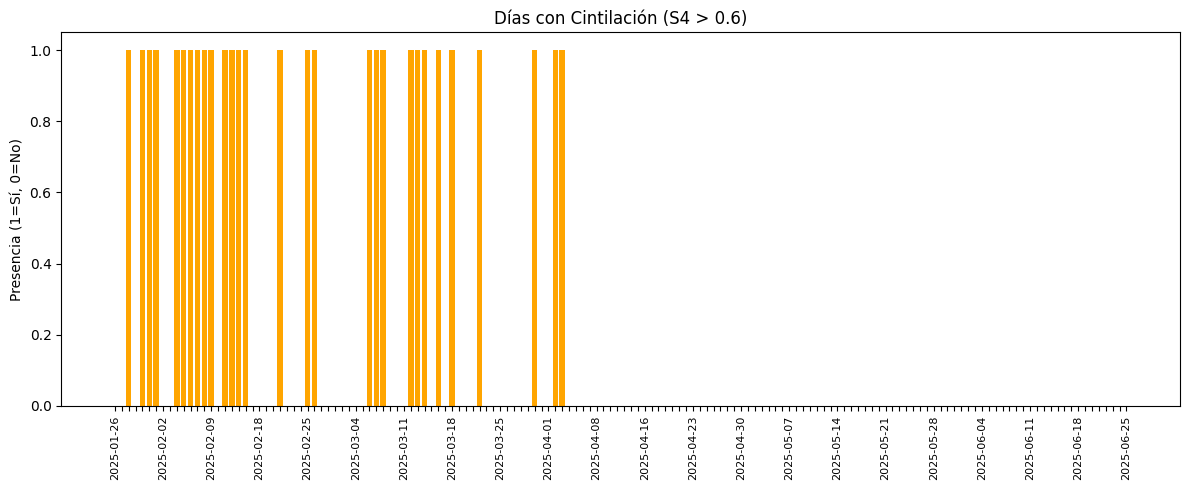


⚙️ Generando características temporales (Sin/Cos)...

🧹 Finalizando estructura del DataFrame...
   Columnas eliminadas: ['Cintilacion']
✅ DataFrame Final Listo. Shape: (204396, 13)
   Columnas finales: ['Azimuth', 'Elevacion', 'TEC', 'ROTEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'ap_Index', 'f10.7_Index', 'AE_Index', 'Hora_Sin', 'Hora_Cos', 'S4']

--- PRIMERAS 5 FILAS DEL DF FINAL ---
                     Azimuth  Elevacion        TEC     ROTEC      ROTI  \
Tiempo                                                                   
2025-01-26 00:35:00    189.0       31.0  69.258790 -0.020608  0.010838   
2025-01-26 00:36:00    189.0       32.0  68.826191 -0.019268  0.010848   
2025-01-26 00:37:00    197.0       32.0  68.393592 -0.017928  0.010858   
2025-01-26 00:38:00    189.0       33.0  67.960993 -0.016589  0.010867   
2025-01-26 00:39:00    196.0       32.0  67.528394 -0.015249  0.010877   

                     Kp_Index  Dst_Index  ap_Index  f10.7_Index   AE_Index  \
Tiempo            

Model: "LSTM_MultiStep"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 256)        │       141,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,130 (1.27 MB)

 Trainable params: 332,106 (1.27 MB)

 Non-trainable params: 1,024 (4.00 KB)


🚀 Iniciando entrenamiento Multi-Step...
Epoch 1/60
821/824 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4318 - mae: 0.3993 - root_mean_squared_error: 0.5219
Epoch 1: val_loss improved from inf to 0.00655, saving model to modelo_s4_lstm_multistep_mejor.keras
824/824 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - loss: 0.4305 - mae: 0.3988 - root_mean_squared_error: 0.5213 - val_loss: 0.0066 - val_mae: 0.1012 - val_root_mean_squared_error: 0.1292 - learning_rate: 0.0010
Epoch 2/60
821/824 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0166 - mae: 0.1789 - root_mean_squared_error: 0.2266
Epoch 2: val_loss improved from 0.00655 to 0.00252, saving model to modelo_s4_lstm_multistep_mejor.keras
824/824 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0166 - mae: 0.1788 - root_mean_squared_error: 0.2265 - val_loss: 0.0025 - val_mae: 0.0808 - val_root_mean_squared_error: 0.1059 - learning_rate: 0.0010
Epoch 3/60
820/824 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0074 - mae: 0.1341 - root_mean_squared_error: 0.

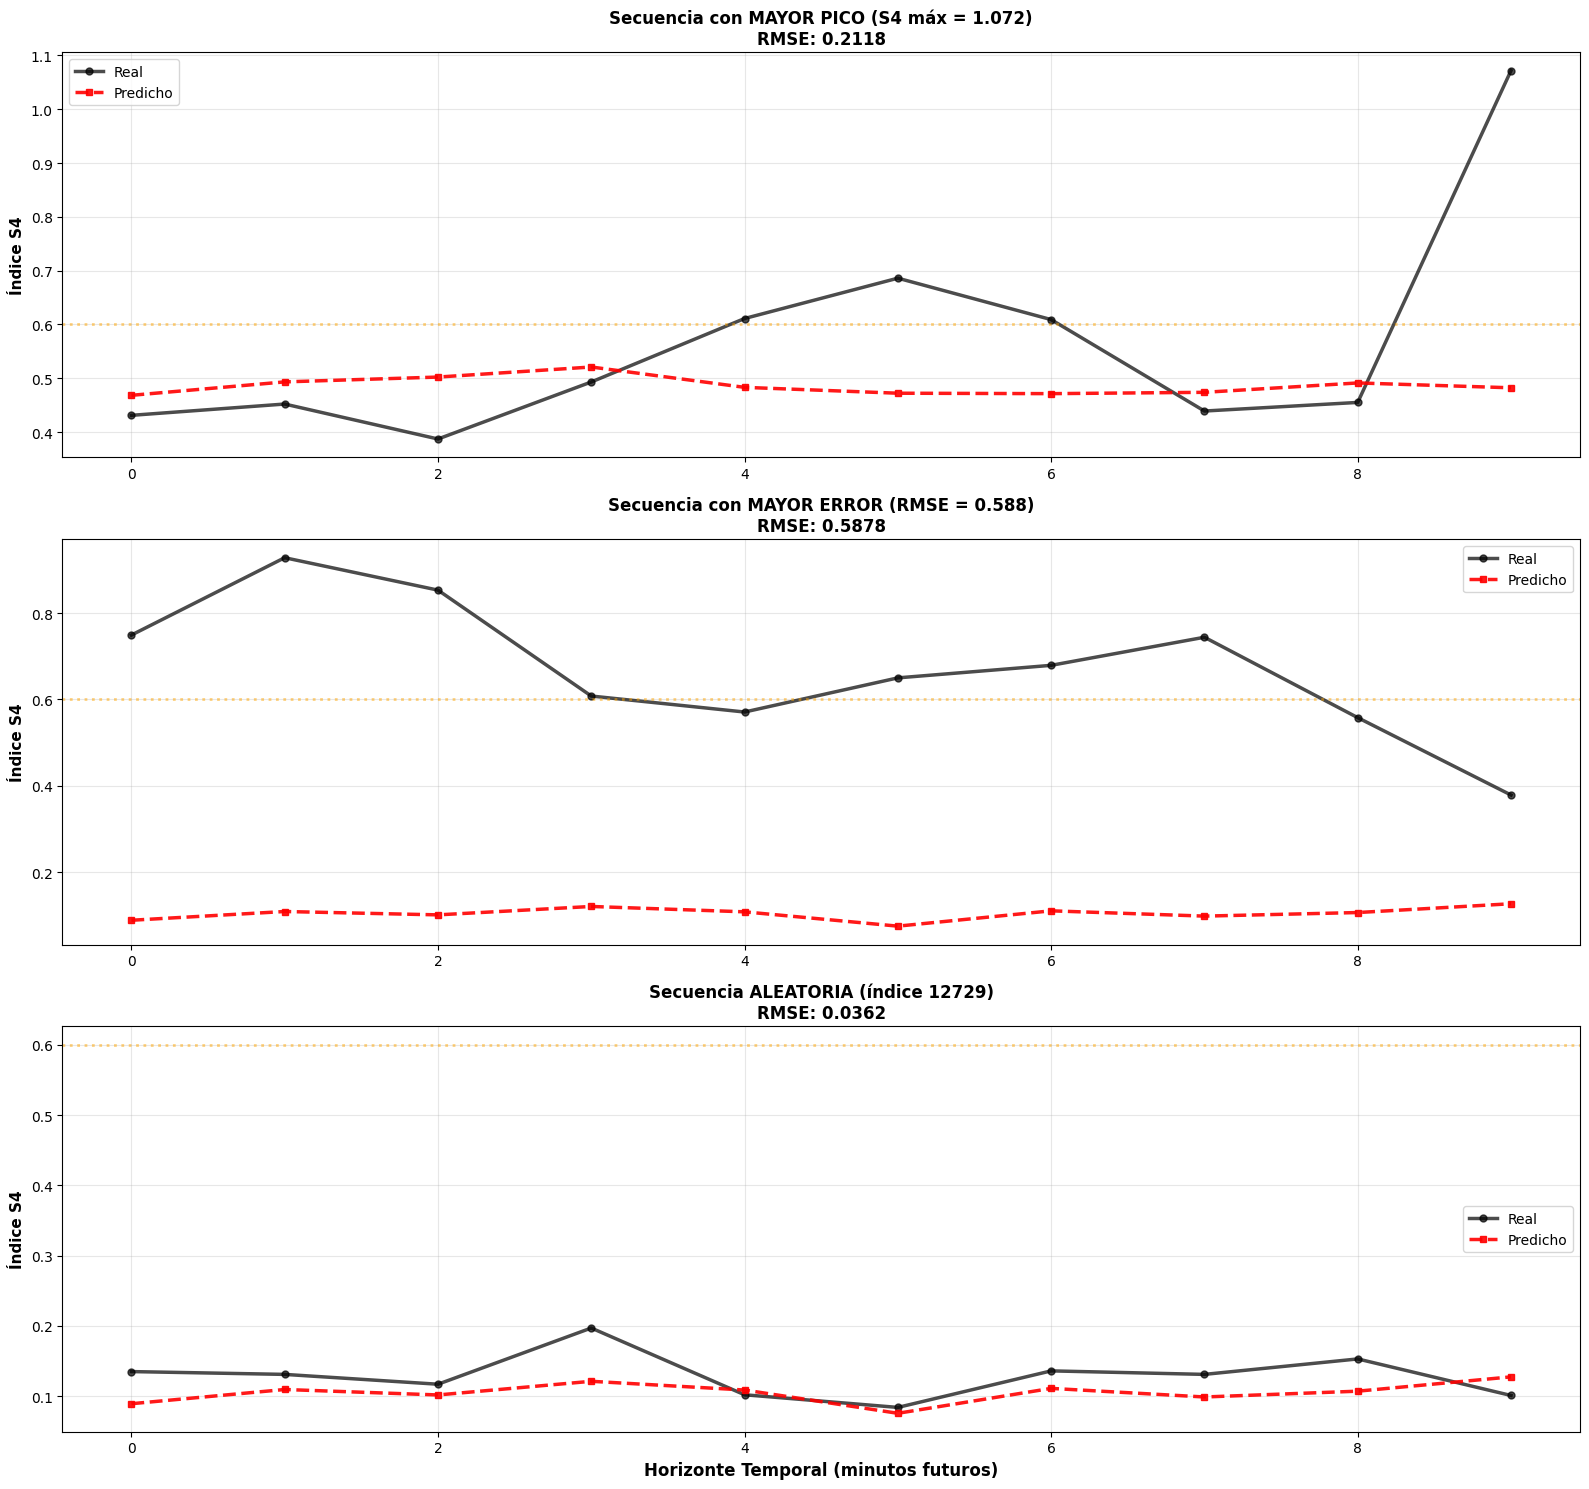

   📊 Event RMSE=0.3566 | Global RMSE=0.0688


In [43]:
# =============================================================================
# BLOQUE PRINCIPAL DE EJECUCIÓN (MAIN)
# =============================================================================
if __name__ == "__main__":
    
    # 1. Configuración
    RUTA = "/home/soporte/Documents/CENTELLEO_INOSFERICO_DAML_PERU/notebook"
    ARCHIVO = "df_FINAL.csv"

    # Definición de Features para el modelo (Orden Importante)
    FEATURES_COLS = [
        'S4', 'TEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'AE_Index', 'f10.7_Index', 
        'Hora_Sin', 'Hora_Cos'
    ]
    
    # Parámetros Temporales
    LOOKBACK_MIN = 60
    HORIZON_MIN  = 10
    LOOKBACK_OPTS = [ 60]
    HORIZON_OPTS = [10]
    
    # 2. Pipeline de ejecución
    # Cargar
    df_raw = cargar_dataset(RUTA, ARCHIVO)
    
    # Analizar (No modifica df_raw)
    analizar_eventos_cintilacion(df_raw, umbral_s4=0.6, plot=True)
    
    # Ingeniería de Features (Modifica df_raw)
    df_features = agregar_caracteristicas_temporales(df_raw)
    
    # Estructura Final (Listo para LSTM)
    df_final = finalizar_estructura_df(df_features, target_col="S4")
    
    # Visualización rápida de las primeras filas del resultado final
    print("\n--- PRIMERAS 5 FILAS DEL DF FINAL ---")
    print(df_final.head())

   # --- NUEVO PASO: DIVISIÓN ESTRATIFICADA ---
    train_df, val_df, test_df = dividir_estratificado_por_dias(df_final, umbral_s4=0.6)
    
    # Auditoría de la división
    print("\n=== AUDITORÍA DE DISTRIBUCIÓN DE DATOS ===")
    auditar_division_datos(train_df, "Train Set")
    auditar_division_datos(val_df, "Validation Set")
    auditar_division_datos(test_df, "Test Set")

    # --- NUEVO PASO: NORMALIZACIÓN ---
    train_scaled, val_scaled, test_scaled, scaler = normalizar_sets(
        train_df, val_df, test_df, FEATURES_COLS
    )
    
    # Ejemplo de datos escalados
    print("\n--- EJEMPLO DE DATOS ESCALADOS (TRAIN) ---")
    print(train_scaled[['Hora_Sin', 'Hora_Cos', 'S4']].head(3))

    # 3. Ejecutar Experimento
    df_resultados = ejecutar_experimento_iterativo_multistep(
        train_scaled, val_scaled, test_scaled, 
        FEATURES_COLS, scaler, 
        LOOKBACK_OPTS, HORIZON_OPTS
    )
    



# **PROBAR CODIGO FINAL**

🚀 PIPELINE MULTI-STEP PARA PREDICCIÓN DE CINTILACIONES IONOSFÉRICAS

⚙️ CONFIGURACIÓN:
   Ruta de datos: /home/soporte/Documents/CENTELLEO_INOSFERICO_DAML_PERU/notebook
   Archivo: df_FINAL.csv
   Features: 9 variables
   Lookback: 60 minutos
   Horizon: 20 minutos (MULTI-STEP)

FASE 1: PREPROCESAMIENTO
📂 Cargando archivo: df_FINAL.csv...
✅ Dataset cargado. Shape: (204396, 13)
   Rango de fechas: 2025-01-26 00:35:00 a 2025-06-25 23:00:00

🔍 Analizando distribución de eventos...
   Total de días registrados: 148
   Días con eventos (S4 > 0.6): 29
   Porcentaje de actividad: 19.59%

📊 Resumen Mensual de Actividad:
         Dias_Con_Cintilacion  Total_Dias  Dias_Sin_Cintilacion
Mes                                                            
2025-01                     3           6                     3
2025-02                    14          26                    12
2025-03                    10          31                    21
2025-04                     2          29                   

Model: "LSTM_MultiStep"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 256)        │       141,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,780 (1.27 MB)

 Trainable params: 332,756 (1.27 MB)

 Non-trainable params: 1,024 (4.00 KB)


🚀 Iniciando entrenamiento Multi-Step...
Epoch 1/100
815/817 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4123 - mae: 0.3860 - root_mean_squared_error: 0.5048
Epoch 1: val_loss improved from inf to 0.00658, saving model to modelo_s4_lstm_multistep_mejor.keras
817/817 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - loss: 0.4113 - mae: 0.3856 - root_mean_squared_error: 0.5043 - val_loss: 0.0066 - val_mae: 0.1047 - val_root_mean_squared_error: 0.1392 - learning_rate: 0.0010
Epoch 2/100
815/817 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0152 - mae: 0.1742 - root_mean_squared_error: 0.2206
Epoch 2: val_loss improved from 0.00658 to 0.00415, saving model to modelo_s4_lstm_multistep_mejor.keras
817/817 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.0151 - mae: 0.1742 - root_mean_squared_error: 0.2205 - val_loss: 0.0042 - val_mae: 0.0854 - val_root_mean_squared_error: 0.1227 - learning_rate: 0.0010
Epoch 3/100
815/817 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0063 - mae: 0.1298 - root_mean_squared_error:

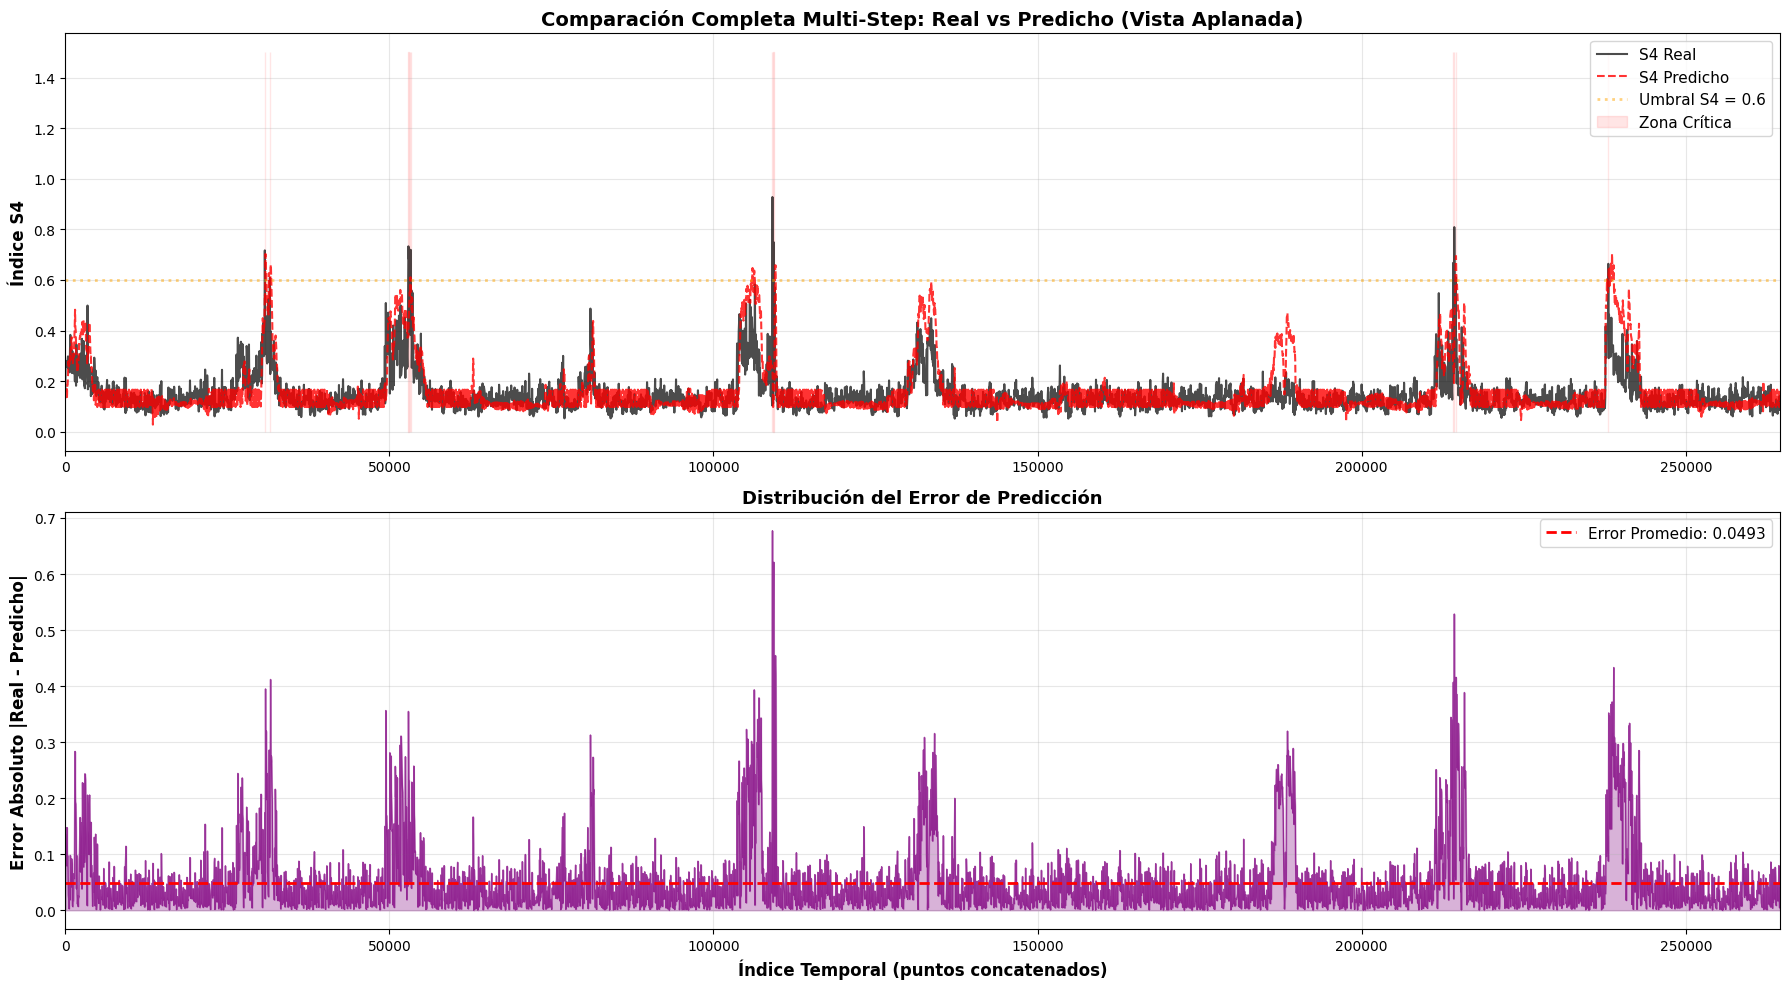


📈 Mostrando secuencias individuales...


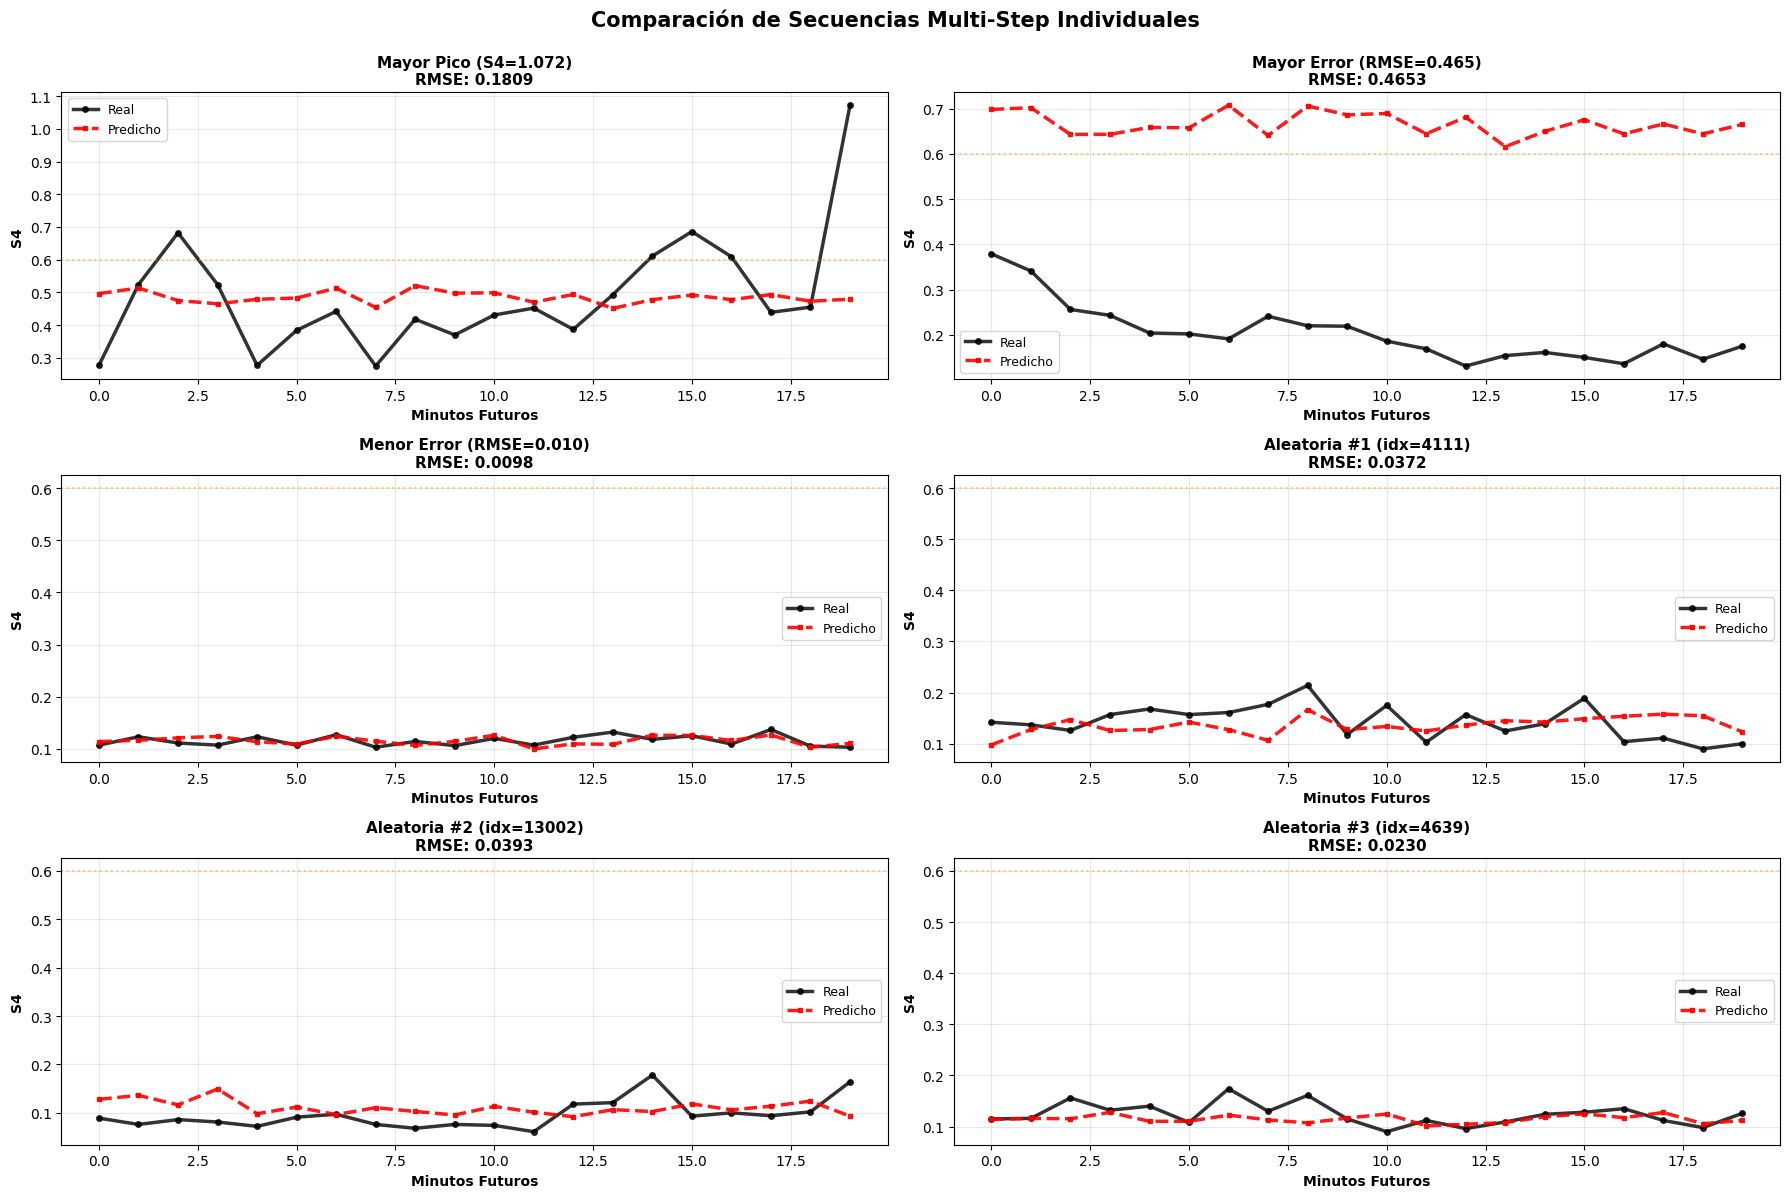


🔥 Generando heatmap de errores...


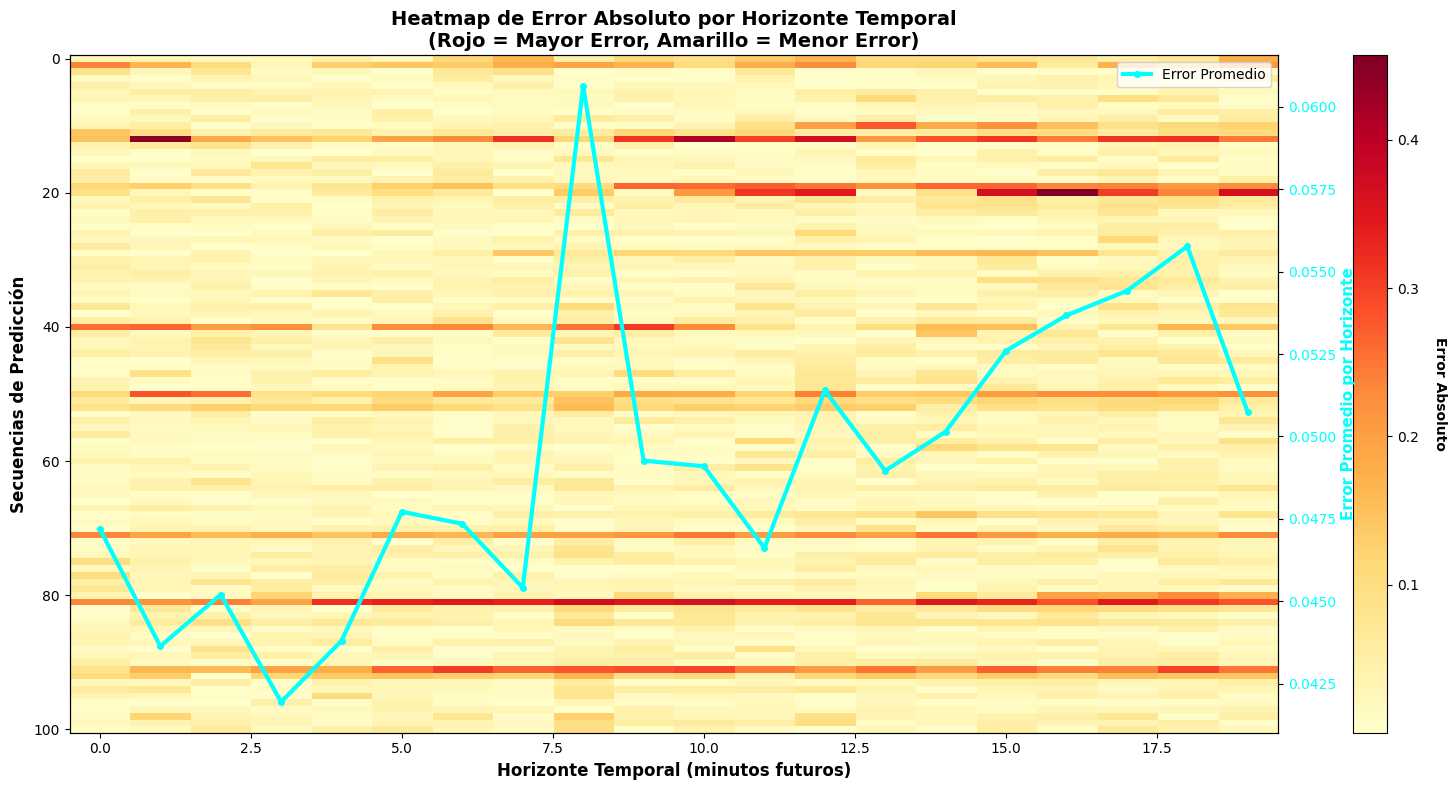


📊 ESTADÍSTICAS DE ERROR POR HORIZONTE TEMPORAL

t+ 0 minutos:
  • Error Promedio:  0.0472
  • Error Mediano:   0.0289
  • Error Máximo:    0.8302
  • Desv. Estándar:  0.0574

t+ 5 minutos:
  • Error Promedio:  0.0477
  • Error Mediano:   0.0314
  • Error Máximo:    0.7856
  • Desv. Estándar:  0.0568

t+10 minutos:
  • Error Promedio:  0.0491
  • Error Mediano:   0.0276
  • Error Máximo:    0.7943
  • Desv. Estándar:  0.0670

t+15 minutos:
  • Error Promedio:  0.0526
  • Error Mediano:   0.0323
  • Error Máximo:    0.6967
  • Desv. Estándar:  0.0670

t+19 minutos:
  • Error Promedio:  0.0507
  • Error Mediano:   0.0272
  • Error Máximo:    0.6576
  • Desv. Estándar:  0.0702

✅ Visualización completa multi-step finalizada.



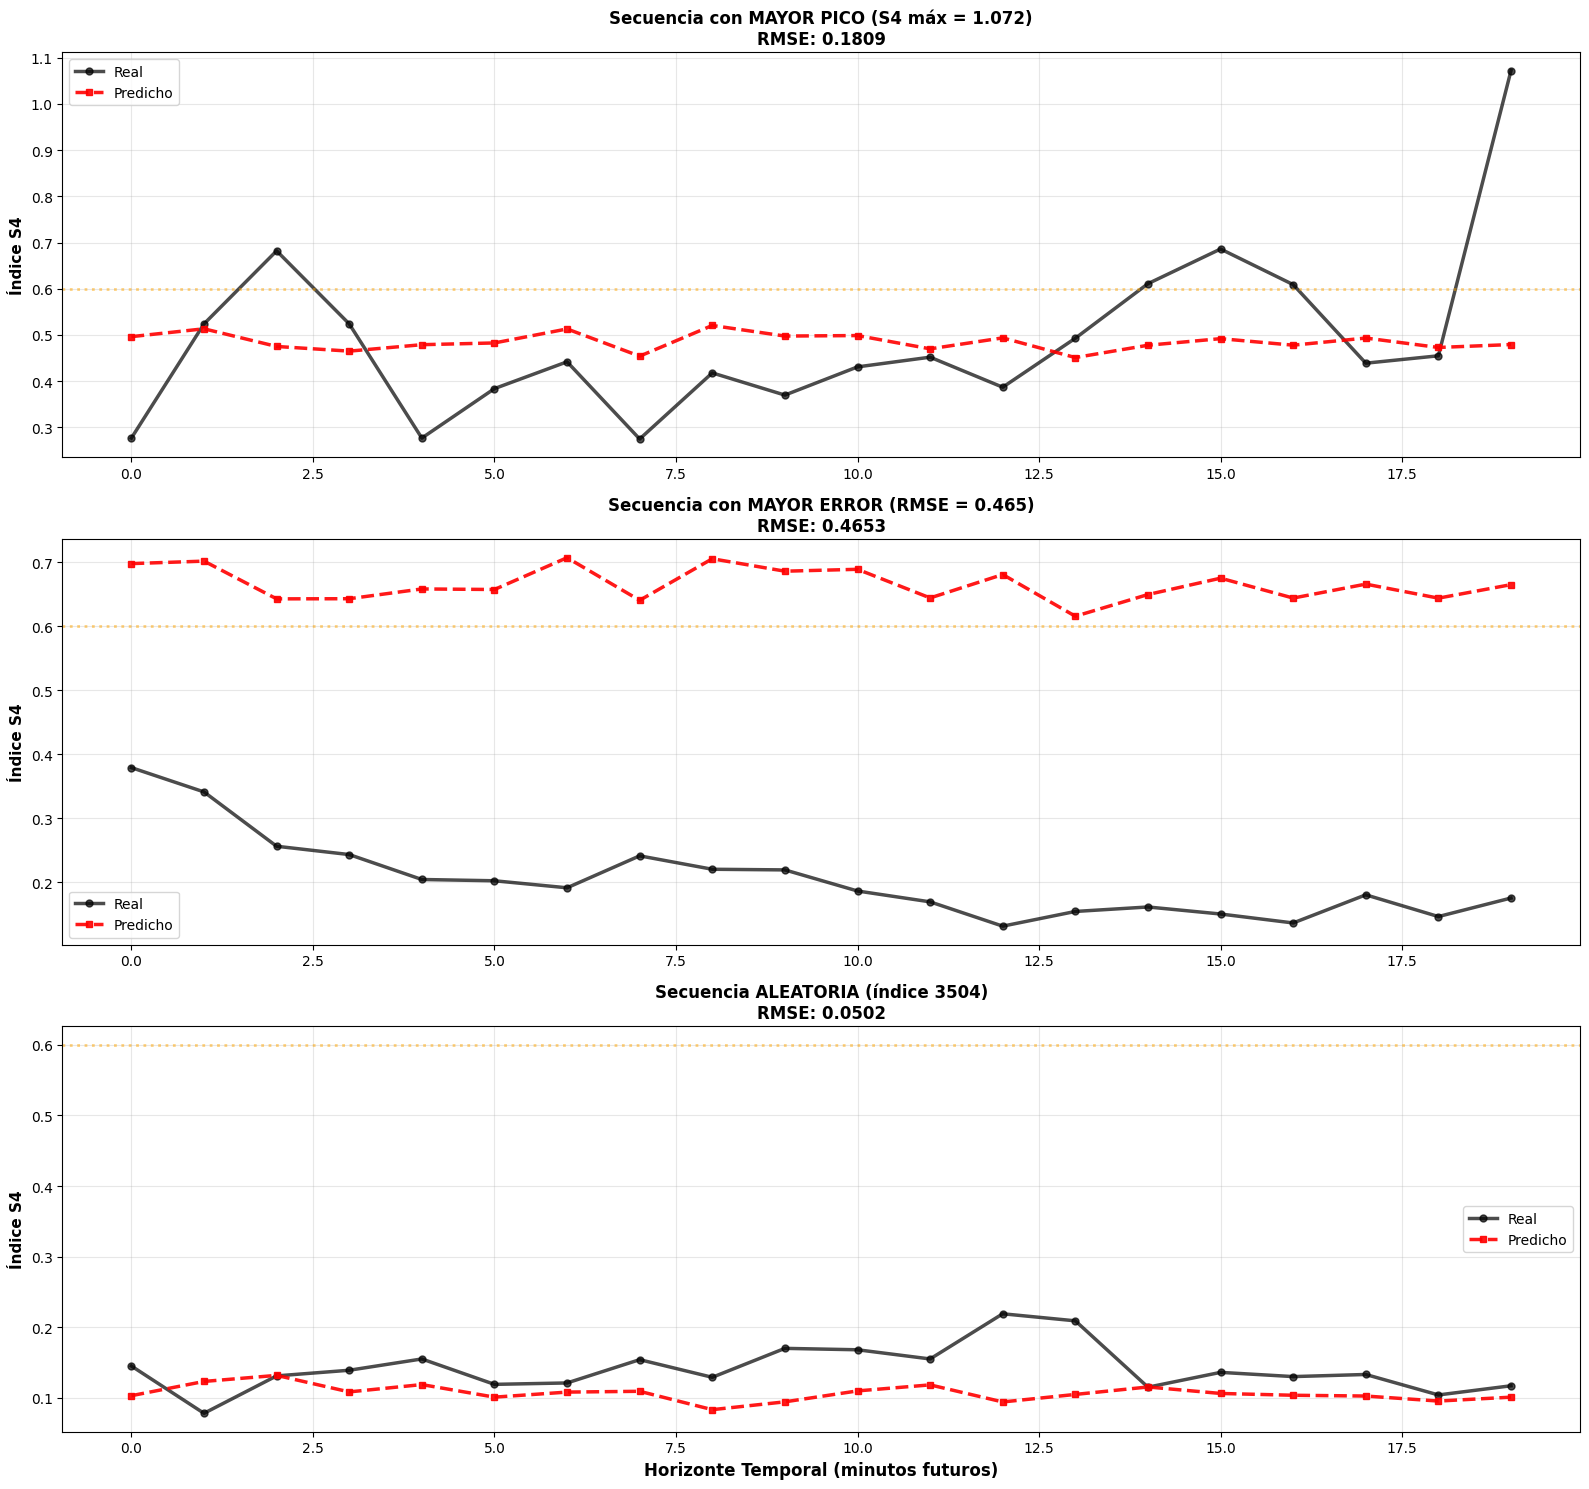


📋 RESUMEN FINAL DEL PIPELINE MULTI-STEP

✅ Configuración:
   • Lookback: 60 minutos
   • Horizon: 20 minutos (secuencia completa)
   • Features: 9
   • Arquitectura: LSTM Bidireccional Multi-Step

✅ Datos:
   • Train: 52260 secuencias
   • Val:   10687 secuencias
   • Test:  13227 secuencias

✅ Rendimiento:
   • Global RMSE:  0.0793
   • Global MAE:   0.0493
   • Event RMSE:   0.3638
   • Event MAE:    0.3114

🎉 PIPELINE MULTI-STEP FINALIZADO EXITOSAMENTE

💾 Guardando modelo entrenado...
   ✅ Modelo guardado como: modelo_final_multistep.keras

✨ ¡Proceso completado! ✨



In [45]:
# =============================================================================
# CÓDIGO ACTUALIZADO CON MULTI-STEP OUTPUT
# Autor: Alexander Valdez Portocarrero (Actualizado)
# Descripción: Predicción de secuencias completas con validación temporal
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# =============================================================================
# 7. GENERACIÓN DE VENTANAS MULTI-STEP (ACTUALIZADO)
# =============================================================================

def crear_dataset_lstm_multistep_con_gaps(df, cols_input, col_target, lookback=60, horizon=20):
    """
    Genera tensores X e y con validación temporal rigurosa.
    
    CAMBIO CLAVE: Ahora y contiene una SECUENCIA de 'horizon' valores futuros,
    no solo un punto.
    
    Args:
        df: DataFrame con índice temporal
        cols_input: Lista de columnas para features de entrada
        col_target: Nombre de la columna objetivo (e.g., 'S4')
        lookback: Ventana de entrada (minutos hacia atrás)
        horizon: Ventana de salida (minutos hacia adelante)
    
    Returns:
        X: shape (m, lookback, n_features) - Ventanas de entrada
        y: shape (m, horizon) - SECUENCIAS de salida
    """
    # 1. Preparación de datos
    data_values = df[cols_input].values  
    target_values = df[col_target].values
    timestamps = df.index.to_series().values
    
    X, y = [], []
    
    # 2. Bucle Principal con Validación Temporal
    for i in range(lookback, len(df) - horizon):
        
        # --- VALIDACIÓN TEMPORAL (GAP CONTROL) ---
        t_inicio = timestamps[i - lookback]      # Inicio de ventana de entrada
        t_actual = timestamps[i]                  # Fin de ventana de entrada (presente)
        t_fin_secuencia = timestamps[i + horizon - 1]  # Último punto de la secuencia de salida
        
        # Verificar continuidad de la ventana de ENTRADA
        diff_entrada = (t_actual - t_inicio) / np.timedelta64(1, 'm')
        if diff_entrada != lookback:
            continue
        
        # Verificar continuidad de la secuencia de SALIDA
        diff_salida = (t_fin_secuencia - t_actual) / np.timedelta64(1, 'm')
        if diff_salida != (horizon - 1):  # horizon-1 porque empezamos en i (no en i+1)
            continue
        
        # Verificación adicional: Comprobar que NO hay gaps dentro de la secuencia de salida
        hay_gap_en_salida = False
        for j in range(i, i + horizon - 1):
            diff_consecutiva = (timestamps[j + 1] - timestamps[j]) / np.timedelta64(1, 'm')
            if diff_consecutiva != 1:
                hay_gap_en_salida = True
                break
        
        if hay_gap_en_salida:
            continue
        
        # --- SI PASA TODAS LAS VALIDACIONES, GUARDAMOS ---
        ventana_entrada = data_values[i - lookback : i]  # [t-60, t-59, ..., t-1]
        
        # CAMBIO CLAVE: Secuencia completa de salida
        secuencia_salida = target_values[i : i + horizon]  # [t, t+1, ..., t+19]
        
        X.append(ventana_entrada)
        y.append(secuencia_salida)
    
    return np.array(X), np.array(y)


def generar_tensores_multistep(train_scaled, val_scaled, test_scaled, features_cols, 
                                target_col='S4', lookback=60, horizon=20):
    """
    Función orquestadora para generar los tensores MULTI-STEP de Train, Val y Test.
    
    CAMBIO: Ahora y tiene shape (m, horizon) en lugar de (m,)
    """
    print(f"\n🎞️ Generando Ventanas Deslizantes MULTI-STEP (Lookback={lookback}, Horizon={horizon})...")
    print(f"   Features ({len(features_cols)}): {features_cols}")
    print(f"   ⚡ Output esperado: SECUENCIAS de {horizon} valores futuros")
    
    # 1. Train
    X_train, y_train = crear_dataset_lstm_multistep_con_gaps(
        train_scaled, features_cols, target_col, lookback, horizon
    )
    print(f"   ✅ TRAIN generado. X: {X_train.shape}, y: {y_train.shape}")
    
    # 2. Val
    X_val, y_val = crear_dataset_lstm_multistep_con_gaps(
        val_scaled, features_cols, target_col, lookback, horizon
    )
    print(f"   ✅ VAL generado.   X: {X_val.shape}, y: {y_val.shape}")
    
    # 3. Test
    X_test, y_test = crear_dataset_lstm_multistep_con_gaps(
        test_scaled, features_cols, target_col, lookback, horizon
    )
    print(f"   ✅ TEST generado.  X: {X_test.shape}, y: {y_test.shape}")
    
    # Verificación
    print("\n--- DIMENSIONES FINALES (Tensor Shapes) ---")
    print(f"   X_train: {X_train.shape}  (muestras, lookback, features)")
    print(f"   y_train: {y_train.shape}  (muestras, horizon) ← SECUENCIAS")
    
    return X_train, y_train, X_val, y_val, X_test, y_test


# =============================================================================
# 8. MODELADO LSTM MULTI-STEP (ACTUALIZADO)
# =============================================================================

def weighted_mse_multistep(threshold, penalty_weight=15.0):
    """
    Loss ponderada para predicción de SECUENCIAS multi-step.
    Penaliza más los errores en valores altos DENTRO de toda la secuencia.
    
    Args:
        threshold: Umbral normalizado de S4 (e.g., 0.6 normalizado)
        penalty_weight: Factor multiplicador para eventos críticos
    """
    def loss(y_true, y_pred):
        # y_true shape: (batch, horizon)
        # y_pred shape: (batch, horizon)
        
        # Error cuadrático base
        squared_error = tf.square(y_pred - y_true)
        
        # Ponderación: Penalizar más donde y_true >= threshold
        weights = tf.where(y_true >= threshold, penalty_weight, 1.0)
        
        # Penalización adicional por subestimación en picos
        underestimation_mask = tf.logical_and(
            y_true >= threshold,
            y_pred < y_true
        )
        underestimation_penalty = tf.where(underestimation_mask, 2.0, 1.0)
        
        # Loss total ponderada
        weighted_error = squared_error * weights * underestimation_penalty
        
        # Promediamos sobre toda la secuencia y el batch
        return tf.reduce_mean(weighted_error)
    
    return loss


def weighted_focal_mse_multistep(threshold, alpha=2.0, beta=50.0):
    """
    Loss híbrida Focal para SECUENCIAS multi-step.
    Combina ponderación con penalización exponencial de errores grandes.
    
    Args:
        threshold: Umbral normalizado
        alpha: Exponente focal (mayor = más agresivo)
        beta: Multiplicador para eventos sobre umbral
    """
    def loss(y_true, y_pred):
        # Error base
        error = y_pred - y_true
        squared_error = tf.square(error)
        
        # COMPONENTE 1: Ponderación por umbral
        weights = tf.where(y_true >= threshold, beta, 1.0)
        
        # COMPONENTE 2: Penalización focal
        focal_weight = tf.pow(tf.abs(error) + 1e-7, alpha)
        
        # COMPONENTE 3: Extra penalización por subestimación
        underestimation_mask = tf.logical_and(
            y_true >= threshold,
            y_pred < y_true * 0.7  # Subestima más del 30%
        )
        underestimation_penalty = tf.where(underestimation_mask, 2.0, 1.0)
        
        # Combinación
        total_loss = squared_error * weights * focal_weight * underestimation_penalty
        
        return tf.reduce_mean(total_loss)
    
    return loss


def construir_modelo_lstm_multistep(input_shape, output_steps, umbral_norm, penalty=15.0):
    """
    Define y compila la arquitectura LSTM para predicción MULTI-STEP.
    
    Args:
        input_shape: (timesteps, features) ej: (60, 9)
        output_steps: número de valores futuros a predecir (horizon) ej: 20
        umbral_norm: umbral normalizado para la loss
        penalty: factor de penalización
    
    Returns:
        Modelo compilado
    """
    tf.keras.backend.clear_session()
    
    model = Sequential([
        Input(shape=input_shape),
        
        # Encoder: Comprender el contexto pasado
        Bidirectional(LSTM(128, return_sequences=True, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),
        
        Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),
        
        # Decoder: Generar secuencia futura
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(64, activation='relu'),
        
        # SALIDA: Vector de 'output_steps' predicciones
        Dense(output_steps, activation='linear')  # ← Predice todos los pasos
    ], name="LSTM_MultiStep")
    
    # Loss adaptada para multi-step
    loss_fn = weighted_focal_mse_multistep(
        threshold=umbral_norm, 
        alpha=1.5, 
        beta=penalty
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=loss_fn,
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
    )
    
    print("\n🧠 Modelo LSTM Multi-Step Compilado:")
    print(f"   Input:  {input_shape}")
    print(f"   Output: {output_steps} valores futuros")
    model.summary()
    
    return model


def entrenar_modelo_multistep(model, X_train, y_train, X_val, y_val, 
                               batch_size=64, epochs=100):
    """
    Ejecuta el entrenamiento del modelo multi-step con callbacks mejorados.
    """
    callbacks = [
        EarlyStopping(
            monitor='val_loss', 
            patience=15,  # Más paciencia para multi-step
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            filepath='modelo_s4_lstm_multistep_mejor.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    print("\n🚀 Iniciando entrenamiento Multi-Step...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    return history, model


# =============================================================================
# 9. PREDICCIÓN Y DESNORMALIZACIÓN MULTI-STEP (ACTUALIZADO)
# =============================================================================

def desnormalizar_secuencia(data_scaled, scaler, features_cols, col_target='S4'):
    """
    Des-normaliza secuencias multi-step.
    Funciona tanto para arrays 1D como 2D (secuencias).
    
    Args:
        data_scaled: Array escalado (puede ser shape (m,) o (m, horizon))
        scaler: MinMaxScaler ajustado
        features_cols: Lista de columnas de features
        col_target: Nombre de la columna objetivo
    
    Returns:
        Array desnormalizado en la misma forma que la entrada
    """
    idx = features_cols.index(col_target)
    
    val_min = scaler.data_min_[idx]
    val_max = scaler.data_max_[idx]
    val_range = val_max - val_min
    
    # Aplicar fórmula inversa
    data_real = (data_scaled * val_range) + val_min
    
    return data_real


def evaluar_predicciones_multistep(model, X_test, y_test, scaler, features_cols, 
                                    col_target='S4', umbral_real=0.6):
    """
    Genera predicciones MULTI-STEP y las convierte a escala real.
    
    Returns:
        y_pred_real: shape (m, horizon) - Secuencias predichas
        y_test_real: shape (m, horizon) - Secuencias reales
    """
    print("\n🔮 Generando predicciones Multi-Step sobre el Test Set...")
    
    # 1. Predecir secuencias (Escala 0-1)
    y_pred_scaled = model.predict(X_test, verbose=0)
    
    # y_pred_scaled shape: (m, horizon)
    # y_test shape: (m, horizon)
    
    print(f"   Forma predicciones escaladas: {y_pred_scaled.shape}")
    
    # 2. Des-normalizar
    y_pred_real = desnormalizar_secuencia(y_pred_scaled, scaler, features_cols, col_target)
    y_test_real = desnormalizar_secuencia(y_test, scaler, features_cols, col_target)
    
    print(f"✅ Datos convertidos a escala real.")
    print(f"   Forma final: {y_pred_real.shape}")
    print(f"   Ejemplo - Primera secuencia real:    {y_test_real[0, :5]}")
    print(f"   Ejemplo - Primera secuencia predicha: {y_pred_real[0, :5]}")
    
    # 3. MÉTRICAS POR HORIZONTE TEMPORAL
    print("\n📊 Rendimiento por Horizonte Temporal:")
    horizonte_steps = y_test_real.shape[1]
    indices_a_mostrar = [0, horizonte_steps//4, horizonte_steps//2, 
                         3*horizonte_steps//4, horizonte_steps-1]
    
    for h in indices_a_mostrar:
        if h < horizonte_steps:
            rmse_h = np.sqrt(mean_squared_error(y_test_real[:, h], y_pred_real[:, h]))
            mae_h = mean_absolute_error(y_test_real[:, h], y_pred_real[:, h])
            print(f"   t+{h:2d} min → RMSE: {rmse_h:.4f}, MAE: {mae_h:.4f}")
    
    return y_pred_real, y_test_real


# =============================================================================
# 10. EVALUACIÓN Y VISUALIZACIÓN MULTI-STEP (ACTUALIZADO)
# =============================================================================

def evaluar_rendimiento_multistep(y_true, y_pred, umbral_evento=0.6):
    """
    Calcula métricas para predicciones MULTI-STEP.
    
    Args:
        y_true: shape (m, horizon)
        y_pred: shape (m, horizon)
        umbral_evento: umbral de S4 para considerar evento
    
    Returns:
        Tupla (rmse_global, rmse_eventos, mae_global, mae_eventos)
    """
    # Aplanar las secuencias para métricas globales
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # 1. Métricas Globales
    rmse_global = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    mae_global = mean_absolute_error(y_true_flat, y_pred_flat)
    
    # 2. Métricas solo en Eventos
    mask_eventos = y_true_flat >= umbral_evento
    
    if np.sum(mask_eventos) > 0:
        rmse_eventos = np.sqrt(mean_squared_error(
            y_true_flat[mask_eventos], 
            y_pred_flat[mask_eventos]
        ))
        mae_eventos = mean_absolute_error(
            y_true_flat[mask_eventos], 
            y_pred_flat[mask_eventos]
        )
    else:
        rmse_eventos = 0
        mae_eventos = 0
        print("⚠️ No se encontraron eventos > 0.6 en este set de datos.")
    
    print(f"\n--- REPORTE DE RENDIMIENTO MULTI-STEP ---")
    print(f"📊 Métricas Globales (todas las predicciones):")
    print(f"   Global RMSE: {rmse_global:.4f}")
    print(f"   Global MAE:  {mae_global:.4f}")
    print(f"-"*50)
    print(f"⚡ Métricas en Eventos (S4 > {umbral_evento}):")
    print(f"   Event RMSE:  {rmse_eventos:.4f}")
    print(f"   Event MAE:   {mae_eventos:.4f}")
    print(f"   Puntos en eventos: {np.sum(mask_eventos)} / {len(y_true_flat)}")
    
    return rmse_global, rmse_eventos, mae_global, mae_eventos


def visualizar_prediccion_multistep(y_real, y_pred, idx_muestra=0, umbral=0.6):
    """
    Visualiza UNA secuencia multi-step específica.
    
    Args:
        y_real: shape (m, horizon)
        y_pred: shape (m, horizon)
        idx_muestra: índice de la muestra a visualizar
        umbral: umbral de S4 para graficar
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    horizonte = y_real.shape[1]
    x_axis = np.arange(horizonte)
    
    # Serie real
    ax.plot(x_axis, y_real[idx_muestra], 
            label='Secuencia Real', 
            color='black', 
            linewidth=2.5, 
            marker='o',
            markersize=6,
            alpha=0.8)
    
    # Serie predicha
    ax.plot(x_axis, y_pred[idx_muestra], 
            label='Secuencia Predicha', 
            color='red', 
            linewidth=2.5, 
            marker='s',
            markersize=5,
            linestyle='--',
            alpha=0.9)
    
    # Umbral
    ax.axhline(y=umbral, color='orange', linestyle=':', linewidth=2, 
               alpha=0.5, label=f'Umbral S4 = {umbral}')
    
    # Calcular error de esta secuencia
    rmse_seq = np.sqrt(mean_squared_error(y_real[idx_muestra], y_pred[idx_muestra]))
    mae_seq = mean_absolute_error(y_real[idx_muestra], y_pred[idx_muestra])
    
    ax.set_xlabel('Horizonte Temporal (minutos futuros)', fontweight='bold', fontsize=12)
    ax.set_ylabel('Índice S4', fontweight='bold', fontsize=12)
    ax.set_title(f'Predicción Multi-Step - Muestra #{idx_muestra}\n' + 
                f'RMSE: {rmse_seq:.4f}, MAE: {mae_seq:.4f}', 
                fontweight='bold', fontsize=13)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def visualizar_resultados_finales_multistep(y_true, y_pred, umbral=0.6, n_ejemplos=3):
    """
    Orquesta la visualización de múltiples predicciones multi-step.
    
    Args:
        y_true: shape (m, horizon)
        y_pred: shape (m, horizon)
        umbral: umbral de S4
        n_ejemplos: cuántas secuencias mostrar
    """
    # 1. Encontrar índices de interés
    # - Secuencia con mayor pico real
    max_peaks = y_true.max(axis=1)
    idx_max_peak = np.argmax(max_peaks)
    
    # - Secuencia con mayor error
    errors = np.sqrt(((y_true - y_pred)**2).mean(axis=1))
    idx_max_error = np.argmax(errors)
    
    # - Secuencia aleatoria
    idx_random = np.random.randint(0, len(y_true))
    
    indices = [idx_max_peak, idx_max_error, idx_random]
    titulos = [
        f"Secuencia con MAYOR PICO (S4 máx = {y_true[idx_max_peak].max():.3f})",
        f"Secuencia con MAYOR ERROR (RMSE = {errors[idx_max_error]:.3f})",
        f"Secuencia ALEATORIA (índice {idx_random})"
    ]
    
    # 2. Graficar
    fig, axes = plt.subplots(len(indices), 1, figsize=(16, 5*len(indices)))
    
    if len(indices) == 1:
        axes = [axes]
    
    for ax, idx, titulo in zip(axes, indices, titulos):
        horizonte = y_true.shape[1]
        x_axis = np.arange(horizonte)
        
        # Real
        ax.plot(x_axis, y_true[idx], 
               label='Real', 
               color='black', 
               linewidth=2.5, 
               marker='o',
               markersize=5,
               alpha=0.7)
        
        # Predicho
        ax.plot(x_axis, y_pred[idx], 
               label='Predicho', 
               color='red', 
               linewidth=2.5, 
               marker='s',
               markersize=4,
               linestyle='--',
               alpha=0.9)
        
        # Umbral
        ax.axhline(y=umbral, color='orange', linestyle=':', linewidth=2, alpha=0.5)
        
        # Error por punto
        rmse_seq = np.sqrt(mean_squared_error(y_true[idx], y_pred[idx]))
        
        ax.set_ylabel('Índice S4', fontweight='bold', fontsize=11)
        ax.set_title(f'{titulo}\nRMSE: {rmse_seq:.4f}', 
                    fontweight='bold', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Horizonte Temporal (minutos futuros)', 
                        fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    plt.show()


def calcular_metricas_multistep(y_true, y_pred, umbral_evento=0.6):
    """
    Calcula métricas y retorna un diccionario para multi-step.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Global
    rmse_global = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    mae_global = mean_absolute_error(y_true_flat, y_pred_flat)
    
    # Eventos
    mask_eventos = y_true_flat >= umbral_evento
    
    if np.sum(mask_eventos) > 0:
        rmse_eventos = np.sqrt(mean_squared_error(
            y_true_flat[mask_eventos], 
            y_pred_flat[mask_eventos]
        ))
        mae_eventos = mean_absolute_error(
            y_true_flat[mask_eventos], 
            y_pred_flat[mask_eventos]
        )
    else:
        rmse_eventos = 0
        mae_eventos = 0
    
    return {
        "Global_RMSE": rmse_global,
        "Global_MAE": mae_global,
        "Event_RMSE": rmse_eventos,
        "Event_MAE": mae_eventos
    }


# =============================================================================
# 11. GESTIÓN DE EXPERIMENTOS MULTI-STEP (ACTUALIZADO)
# =============================================================================

def ejecutar_experimento_iterativo_multistep(train_s, val_s, test_s, features_cols, 
                                             scaler, lookbacks, horizons):
    """
    Ejecuta un Grid Search sobre combinaciones de Lookback y Horizon con MULTI-STEP.
    """
    resultados = []
    total_iteraciones = len(lookbacks) * len(horizons)
    iter_actual = 0
    
    print(f"\n🧪 INICIANDO EXPERIMENTO ITERATIVO MULTI-STEP ({total_iteraciones} Combinaciones)...")
    print(f"   Lookbacks: {lookbacks}")
    print(f"   Horizons:  {horizons}")
    print(f"   🔥 Ahora cada y contiene SECUENCIAS completas")
    print("="*70)
    
    # Umbral constante
    umbral_norm = calcular_umbral_normalizado(scaler, features_cols, umbral_real=0.6)
    
    for lb in lookbacks:
        for hz in horizons:
            iter_actual += 1
            print(f"\n🔄 [{iter_actual}/{total_iteraciones}] Probando: Lookback={lb} min, Horizon={hz} min")
            
            # 1. Generar Tensores Multi-Step
            X_train, y_train, X_val, y_val, X_test, y_test = generar_tensores_multistep(
                train_s, val_s, test_s, features_cols, 
                target_col='S4', lookback=lb, horizon=hz
            )
            
            if X_train.shape[0] == 0:
                print("   ⚠️ Salto: No hay suficientes datos para esta ventana.")
                continue
            
            # 2. Construir Modelo Multi-Step
            input_shape = (X_train.shape[1], X_train.shape[2])
            output_steps = hz  # El horizonte define cuántos valores predecir
            
            model = construir_modelo_lstm_multistep(
                input_shape, output_steps, umbral_norm, penalty=45.0
            )
            
            # 3. Entrenar
            history, _ = entrenar_modelo_multistep(
                model, 
                X_train.astype('float32'), y_train.astype('float32'), 
                X_val.astype('float32'), y_val.astype('float32'), 
                batch_size=64, epochs=60
            )
            
            # 4. Evaluar
            y_pred, y_real = evaluar_predicciones_multistep(
                model, X_test, y_test, scaler, features_cols
            )
            metricas = calcular_metricas_multistep(y_real, y_pred, umbral_evento=0.6)
            
            # 5. Guardar Resultados
            registro = {
                "Lookback": lb,
                "Horizon": hz,
                **metricas
            }
            resultados.append(registro)
            
            print(f"   📊 Event RMSE={metricas['Event_RMSE']:.4f} | Global RMSE={metricas['Global_RMSE']:.4f}")
    
    return pd.DataFrame(resultados)


# =============================================================================
# FUNCIÓN AUXILIAR (ya estaba definida pero la incluyo por completitud)
# =============================================================================

def calcular_umbral_normalizado(scaler, features_cols, umbral_real=0.6, col_target='S4'):
    """
    Calcula el equivalente de 0.6 S4 en la escala 0-1.
    """
    idx_target = features_cols.index(col_target)
    
    val_min = scaler.data_min_[idx_target]
    val_max = scaler.data_max_[idx_target]
    
    umbral_norm = (umbral_real - val_min) / (val_max - val_min)
    
    print(f"\n📏 Cálculo de Umbral Normalizado:")
    print(f"   S4 Real: {umbral_real}  =>  S4 Norm: {umbral_norm:.4f}")
    
    return umbral_norm


# =============================================================================
# VISUALIZACIÓN COMPARATIVA MULTI-STEP (NUEVO)
# =============================================================================

def visualizar_comparacion_completa_multistep(y_true, y_pred, umbral=0.6):
    """
    Visualización completa de comparación entre y_real y y_pred multi-step.
    Genera 3 gráficas:
    1. Vista completa aplanada (todas las predicciones concatenadas)
    2. Múltiples secuencias individuales
    3. Heatmap de errores por horizonte temporal
    """
    
    # =========================================================================
    # GRÁFICA 1: VISTA COMPLETA APLANADA
    # =========================================================================
    print("\n📊 Generando visualización completa multi-step...")
    
    # Aplanar las secuencias para ver como serie temporal continua
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    fig, axes = plt.subplots(2, 1, figsize=(18, 10))
    
    # Panel superior: Serie temporal completa
    ax1 = axes[0]
    x_axis = np.arange(len(y_true_flat))
    
    # Submuestreo para visualización si hay demasiados puntos
    step = max(1, len(y_true_flat) // 5000)  # Máximo 5000 puntos
    
    ax1.plot(x_axis[::step], y_true_flat[::step], 
            label='S4 Real', 
            color='black', 
            linewidth=1.5, 
            alpha=0.7)
    
    ax1.plot(x_axis[::step], y_pred_flat[::step], 
            label='S4 Predicho', 
            color='red', 
            linewidth=1.5, 
            linestyle='--',
            alpha=0.8)
    
    ax1.axhline(y=umbral, color='orange', linestyle=':', linewidth=2, 
               alpha=0.5, label=f'Umbral S4 = {umbral}')
    
    # Sombrear zonas críticas
    mask_critico = y_true_flat[::step] >= umbral
    if np.any(mask_critico):
        ax1.fill_between(x_axis[::step], 0, 1.5, where=mask_critico, 
                        color='red', alpha=0.1, label='Zona Crítica')
    
    ax1.set_ylabel('Índice S4', fontweight='bold', fontsize=12)
    ax1.set_title('Comparación Completa Multi-Step: Real vs Predicho (Vista Aplanada)', 
                 fontweight='bold', fontsize=14)
    ax1.legend(loc='upper right', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, len(y_true_flat))
    
    # Panel inferior: Error absoluto
    ax2 = axes[1]
    error_abs = np.abs(y_true_flat - y_pred_flat)
    
    ax2.plot(x_axis[::step], error_abs[::step], 
            color='purple', 
            linewidth=1, 
            alpha=0.7)
    ax2.fill_between(x_axis[::step], 0, error_abs[::step], 
                     color='purple', alpha=0.3)
    
    # Línea de error promedio
    error_mean = np.mean(error_abs)
    ax2.axhline(y=error_mean, color='red', linestyle='--', linewidth=2, 
               label=f'Error Promedio: {error_mean:.4f}')
    
    ax2.set_xlabel('Índice Temporal (puntos concatenados)', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Error Absoluto |Real - Predicho|', fontweight='bold', fontsize=12)
    ax2.set_title('Distribución del Error de Predicción', fontweight='bold', fontsize=13)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, len(y_true_flat))
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # GRÁFICA 2: MÚLTIPLES SECUENCIAS INDIVIDUALES
    # =========================================================================
    print("\n📈 Mostrando secuencias individuales...")
    
    # Seleccionar 6 secuencias de interés
    n_muestras = y_true.shape[0]
    
    # 1. Secuencia con mayor pico
    max_peaks = y_true.max(axis=1)
    idx_max_peak = np.argmax(max_peaks)
    
    # 2. Secuencia con mayor error
    errors_seq = np.sqrt(((y_true - y_pred)**2).mean(axis=1))
    idx_max_error = np.argmax(errors_seq)
    
    # 3. Secuencia con menor error
    idx_min_error = np.argmin(errors_seq)
    
    # 4-6. Secuencias aleatorias
    np.random.seed(42)
    idx_random = np.random.choice(n_muestras, size=3, replace=False)
    
    indices_mostrar = [idx_max_peak, idx_max_error, idx_min_error] + list(idx_random)
    titulos = [
        f"Mayor Pico (S4={y_true[idx_max_peak].max():.3f})",
        f"Mayor Error (RMSE={errors_seq[idx_max_error]:.3f})",
        f"Menor Error (RMSE={errors_seq[idx_min_error]:.3f})",
        f"Aleatoria #1 (idx={idx_random[0]})",
        f"Aleatoria #2 (idx={idx_random[1]})",
        f"Aleatoria #3 (idx={idx_random[2]})"
    ]
    
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    axes = axes.flatten()
    
    horizonte = y_true.shape[1]
    x_axis_seq = np.arange(horizonte)
    
    for ax, idx, titulo in zip(axes, indices_mostrar, titulos):
        # Real
        ax.plot(x_axis_seq, y_true[idx], 
               label='Real', 
               color='black', 
               linewidth=2.5, 
               marker='o',
               markersize=4,
               alpha=0.8)
        
        # Predicho
        ax.plot(x_axis_seq, y_pred[idx], 
               label='Predicho', 
               color='red', 
               linewidth=2.5, 
               marker='s',
               markersize=3.5,
               linestyle='--',
               alpha=0.9)
        
        # Umbral
        ax.axhline(y=umbral, color='orange', linestyle=':', linewidth=1.5, alpha=0.5)
        
        # Calcular RMSE de esta secuencia
        rmse_seq = np.sqrt(mean_squared_error(y_true[idx], y_pred[idx]))
        
        ax.set_ylabel('S4', fontweight='bold')
        ax.set_xlabel('Minutos Futuros', fontweight='bold')
        ax.set_title(f'{titulo}\nRMSE: {rmse_seq:.4f}', fontsize=11, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Comparación de Secuencias Multi-Step Individuales', 
                fontsize=15, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # GRÁFICA 3: HEATMAP DE ERRORES POR HORIZONTE TEMPORAL
    # =========================================================================
    print("\n🔥 Generando heatmap de errores...")
    
    # Calcular error absoluto por cada punto
    error_matrix = np.abs(y_true - y_pred)
    
    # Tomar submuestreo de muestras si son muchas (máximo 100 para visualización)
    n_muestras_plot = min(100, error_matrix.shape[0])
    step_muestras = max(1, error_matrix.shape[0] // n_muestras_plot)
    error_matrix_plot = error_matrix[::step_muestras, :]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    im = ax.imshow(error_matrix_plot, 
                   aspect='auto', 
                   cmap='YlOrRd',
                   interpolation='nearest')
    
    ax.set_xlabel('Horizonte Temporal (minutos futuros)', fontweight='bold', fontsize=12)
    ax.set_ylabel('Secuencias de Predicción', fontweight='bold', fontsize=12)
    ax.set_title('Heatmap de Error Absoluto por Horizonte Temporal\n' + 
                '(Rojo = Mayor Error, Amarillo = Menor Error)', 
                fontweight='bold', fontsize=14)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Error Absoluto', rotation=270, labelpad=20, fontweight='bold')
    
    # Estadísticas por horizonte
    error_por_horizonte = error_matrix.mean(axis=0)
    
    # Agregar línea de error promedio por horizonte
    ax2 = ax.twinx()
    ax2.plot(np.arange(horizonte), error_por_horizonte, 
            color='cyan', linewidth=3, marker='o', markersize=4,
            label='Error Promedio')
    ax2.set_ylabel('Error Promedio por Horizonte', fontweight='bold', fontsize=11, color='cyan')
    ax2.tick_params(axis='y', labelcolor='cyan')
    ax2.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # ESTADÍSTICAS FINALES
    # =========================================================================
    print("\n" + "="*70)
    print("📊 ESTADÍSTICAS DE ERROR POR HORIZONTE TEMPORAL")
    print("="*70)
    
    for h in [0, horizonte//4, horizonte//2, 3*horizonte//4, horizonte-1]:
        if h < horizonte:
            error_h = error_matrix[:, h]
            print(f"\nt+{h:2d} minutos:")
            print(f"  • Error Promedio:  {error_h.mean():.4f}")
            print(f"  • Error Mediano:   {np.median(error_h):.4f}")
            print(f"  • Error Máximo:    {error_h.max():.4f}")
            print(f"  • Desv. Estándar:  {error_h.std():.4f}")
    
    print("\n" + "="*70)
    print("✅ Visualización completa multi-step finalizada.\n")


# =============================================================================
# BLOQUE PRINCIPAL DE EJECUCIÓN MULTI-STEP (MAIN)
# =============================================================================

if __name__ == "__main__":
    
    print("="*70)
    print("🚀 PIPELINE MULTI-STEP PARA PREDICCIÓN DE CINTILACIONES IONOSFÉRICAS")
    print("="*70)
    
    # 1. Configuración
    RUTA = "/home/soporte/Documents/CENTELLEO_INOSFERICO_DAML_PERU/notebook"
    ARCHIVO = "df_FINAL.csv"
    
    # Definición de Features para el modelo (Orden Importante)
    FEATURES_COLS = [
        'S4', 'TEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'AE_Index', 'f10.7_Index', 
        'Hora_Sin', 'Hora_Cos'
    ]
    
    # Parámetros Temporales Multi-Step
    LOOKBACK_MIN = 60    # Ventana de entrada: 60 minutos pasados
    HORIZON_MIN  = 20    # Ventana de salida: 20 minutos futuros (SECUENCIA COMPLETA)
    
    print(f"\n⚙️ CONFIGURACIÓN:")
    print(f"   Ruta de datos: {RUTA}")
    print(f"   Archivo: {ARCHIVO}")
    print(f"   Features: {len(FEATURES_COLS)} variables")
    print(f"   Lookback: {LOOKBACK_MIN} minutos")
    print(f"   Horizon: {HORIZON_MIN} minutos (MULTI-STEP)")
    
    # =========================================================================
    # 2. PIPELINE DE PREPROCESAMIENTO
    # =========================================================================
    print("\n" + "="*70)
    print("FASE 1: PREPROCESAMIENTO")
    print("="*70)
    
    # Cargar
    df_raw = cargar_dataset(RUTA, ARCHIVO)
    
    # Analizar (No modifica df_raw)
    analizar_eventos_cintilacion(df_raw, umbral_s4=0.6, plot=False)  # plot=False para no interrumpir
    
    # Ingeniería de Features (Modifica df_raw)
    df_features = agregar_caracteristicas_temporales(df_raw)
    
    # Estructura Final (Listo para LSTM)
    df_final = finalizar_estructura_df(df_features, target_col="S4")
    
    # Visualización rápida
    print("\n--- PRIMERAS 5 FILAS DEL DF FINAL ---")
    print(df_final.head())
    
    # División Estratificada
    train_df, val_df, test_df = dividir_estratificado_por_dias(df_final, umbral_s4=0.6)
    
    # Auditoría de la división
    print("\n=== AUDITORÍA DE DISTRIBUCIÓN DE DATOS ===")
    auditar_division_datos(train_df, "Train Set")
    auditar_division_datos(val_df, "Validation Set")
    auditar_division_datos(test_df, "Test Set")
    
    # Normalización
    train_scaled, val_scaled, test_scaled, scaler = normalizar_sets(
        train_df, val_df, test_df, FEATURES_COLS
    )
    
    print("\n--- EJEMPLO DE DATOS ESCALADOS (TRAIN) ---")
    print(train_scaled[['Hora_Sin', 'Hora_Cos', 'S4']].head(3))
    
    # =========================================================================
    # 3. GENERACIÓN DE VENTANAS MULTI-STEP
    # =========================================================================
    print("\n" + "="*70)
    print("FASE 2: GENERACIÓN DE TENSORES MULTI-STEP")
    print("="*70)
    
    X_train, y_train, X_val, y_val, X_test, y_test = generar_tensores_multistep(
        train_scaled, val_scaled, test_scaled, 
        FEATURES_COLS, target_col='S4', 
        lookback=LOOKBACK_MIN, horizon=HORIZON_MIN
    )
    
    print(f"\n✅ Tensores generados exitosamente:")
    print(f"   X_train: {X_train.shape} - (muestras, lookback, features)")
    print(f"   y_train: {y_train.shape} - (muestras, horizon) ← SECUENCIAS")
    print(f"   X_test:  {X_test.shape}")
    print(f"   y_test:  {y_test.shape}")
    
    # =========================================================================
    # 4. ENTRENAMIENTO DEL MODELO MULTI-STEP
    # =========================================================================
    print("\n" + "="*70)
    print("FASE 3: ENTRENAMIENTO DEL MODELO MULTI-STEP")
    print("="*70)
    
    # Calcular umbral normalizado
    umbral_norm = calcular_umbral_normalizado(scaler, FEATURES_COLS, umbral_real=0.6)
    
    # Construir Modelo Multi-Step
    input_shape = (X_train.shape[1], X_train.shape[2])  # (60, 9)
    output_steps = HORIZON_MIN  # 20 valores futuros
    
    model = construir_modelo_lstm_multistep(
        input_shape=input_shape,
        output_steps=output_steps,
        umbral_norm=umbral_norm,
        penalty=45.0
    )
    
    # Entrenar
    history, model_entrenado = entrenar_modelo_multistep(
        model, 
        X_train.astype('float32'), y_train.astype('float32'), 
        X_val.astype('float32'), y_val.astype('float32'), 
        batch_size=64, 
        epochs=100
    )
    
    print("\n✅ Entrenamiento completado.")
    
    # =========================================================================
    # 5. PREDICCIÓN Y EVALUACIÓN MULTI-STEP
    # =========================================================================
    print("\n" + "="*70)
    print("FASE 4: PREDICCIÓN Y EVALUACIÓN")
    print("="*70)
    
    y_pred_real, y_test_real = evaluar_predicciones_multistep(
        model_entrenado, X_test, y_test, scaler, FEATURES_COLS, col_target='S4'
    )
    
    print(f"\n📊 Forma de las predicciones:")
    print(f"   y_test_real: {y_test_real.shape} - (muestras, horizon)")
    print(f"   y_pred_real: {y_pred_real.shape} - (muestras, horizon)")
    
    # =========================================================================
    # 6. MÉTRICAS DE RENDIMIENTO
    # =========================================================================
    print("\n" + "="*70)
    print("FASE 5: EVALUACIÓN DE RENDIMIENTO")
    print("="*70)
    
    rmse_g, rmse_e, mae_g, mae_e = evaluar_rendimiento_multistep(
        y_test_real, y_pred_real, umbral_evento=0.6
    )
    
    # =========================================================================
    # 7. VISUALIZACIONES COMPLETAS
    # =========================================================================
    print("\n" + "="*70)
    print("FASE 6: GENERACIÓN DE VISUALIZACIONES")
    print("="*70)
    
    # Visualización completa multi-step
    visualizar_comparacion_completa_multistep(y_test_real, y_pred_real, umbral=0.6)
    
    # Visualizaciones adicionales detalladas
    visualizar_resultados_finales_multistep(y_test_real, y_pred_real, umbral=0.6, n_ejemplos=3)
    
    # =========================================================================
    # 8. RESUMEN FINAL
    # =========================================================================
    print("\n" + "="*70)
    print("📋 RESUMEN FINAL DEL PIPELINE MULTI-STEP")
    print("="*70)
    print(f"\n✅ Configuración:")
    print(f"   • Lookback: {LOOKBACK_MIN} minutos")
    print(f"   • Horizon: {HORIZON_MIN} minutos (secuencia completa)")
    print(f"   • Features: {len(FEATURES_COLS)}")
    print(f"   • Arquitectura: LSTM Bidireccional Multi-Step")
    
    print(f"\n✅ Datos:")
    print(f"   • Train: {X_train.shape[0]} secuencias")
    print(f"   • Val:   {X_val.shape[0]} secuencias")
    print(f"   • Test:  {X_test.shape[0]} secuencias")
    
    print(f"\n✅ Rendimiento:")
    print(f"   • Global RMSE:  {rmse_g:.4f}")
    print(f"   • Global MAE:   {mae_g:.4f}")
    print(f"   • Event RMSE:   {rmse_e:.4f}")
    print(f"   • Event MAE:    {mae_e:.4f}")
    
    print("\n" + "="*70)
    print("🎉 PIPELINE MULTI-STEP FINALIZADO EXITOSAMENTE")
    print("="*70)
    
    # Guardar modelo
    print("\n💾 Guardando modelo entrenado...")
    model_entrenado.save('modelo_final_multistep.keras')
    print("   ✅ Modelo guardado como: modelo_final_multistep.keras")
    
    print("\n✨ ¡Proceso completado! ✨\n")

# **PROBAR CODIGO FINAL 2**

🚀 PIPELINE MULTI-STEP PARA PREDICCIÓN DE CINTILACIONES IONOSFÉRICAS

⚙️ CONFIGURACIÓN:
   Ruta de datos: /home/soporte/Documents/CENTELLEO_INOSFERICO_DAML_PERU/notebook
   Archivo: df_FINAL.csv
   Features: 9 variables
   Lookback: 60 minutos
   Horizon: 20 minutos (MULTI-STEP)

FASE 1: PREPROCESAMIENTO
📂 Cargando archivo: df_FINAL.csv...
✅ Dataset cargado. Shape: (204396, 13)
   Rango de fechas: 2025-01-26 00:35:00 a 2025-06-25 23:00:00

🔍 Analizando distribución de eventos...
   Total de días registrados: 148
   Días con eventos (S4 > 0.6): 29
   Porcentaje de actividad: 19.59%

📊 Resumen Mensual de Actividad:
         Dias_Con_Cintilacion  Total_Dias  Dias_Sin_Cintilacion
Mes                                                            
2025-01                     3           6                     3
2025-02                    14          26                    12
2025-03                    10          31                    21
2025-04                     2          29                   

Model: "LSTM_MultiStep"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 256)        │       141,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,780 (1.27 MB)

 Trainable params: 332,756 (1.27 MB)

 Non-trainable params: 1,024 (4.00 KB)


🚀 Iniciando entrenamiento Multi-Step...
Epoch 1/100
815/817 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6592 - mae: 0.4322 - root_mean_squared_error: 0.5650
Epoch 1: val_loss improved from inf to 0.00724, saving model to modelo_s4_lstm_multistep_mejor.keras
817/817 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 0.6576 - mae: 0.4318 - root_mean_squared_error: 0.5645 - val_loss: 0.0072 - val_mae: 0.1087 - val_root_mean_squared_error: 0.1385 - learning_rate: 0.0010
Epoch 2/100
815/817 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0233 - mae: 0.1984 - root_mean_squared_error: 0.2520
Epoch 2: val_loss improved from 0.00724 to 0.00320, saving model to modelo_s4_lstm_multistep_mejor.keras
817/817 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0232 - mae: 0.1983 - root_mean_squared_error: 0.2520 - val_loss: 0.0032 - val_mae: 0.0878 - val_root_mean_squared_error: 0.1178 - learning_rate: 0.0010
Epoch 3/100
813/817 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0097 - mae: 0.1502 - root_mean_squared_error:

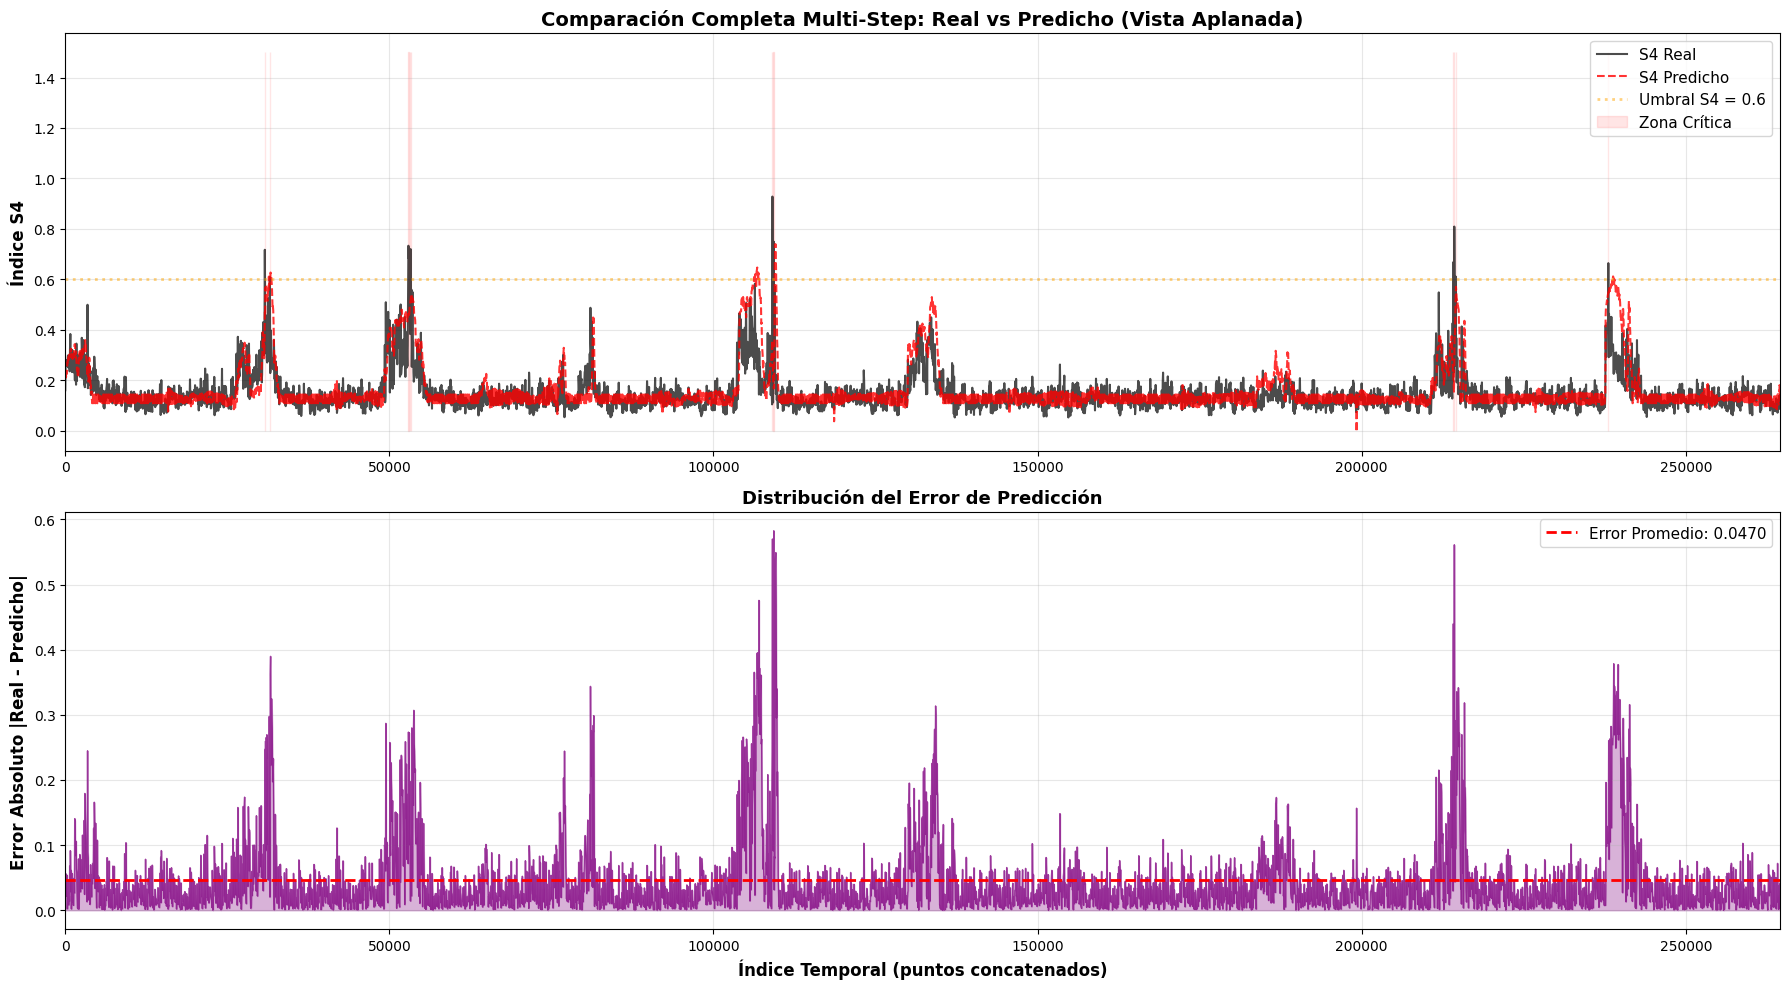


📈 Mostrando secuencias individuales...


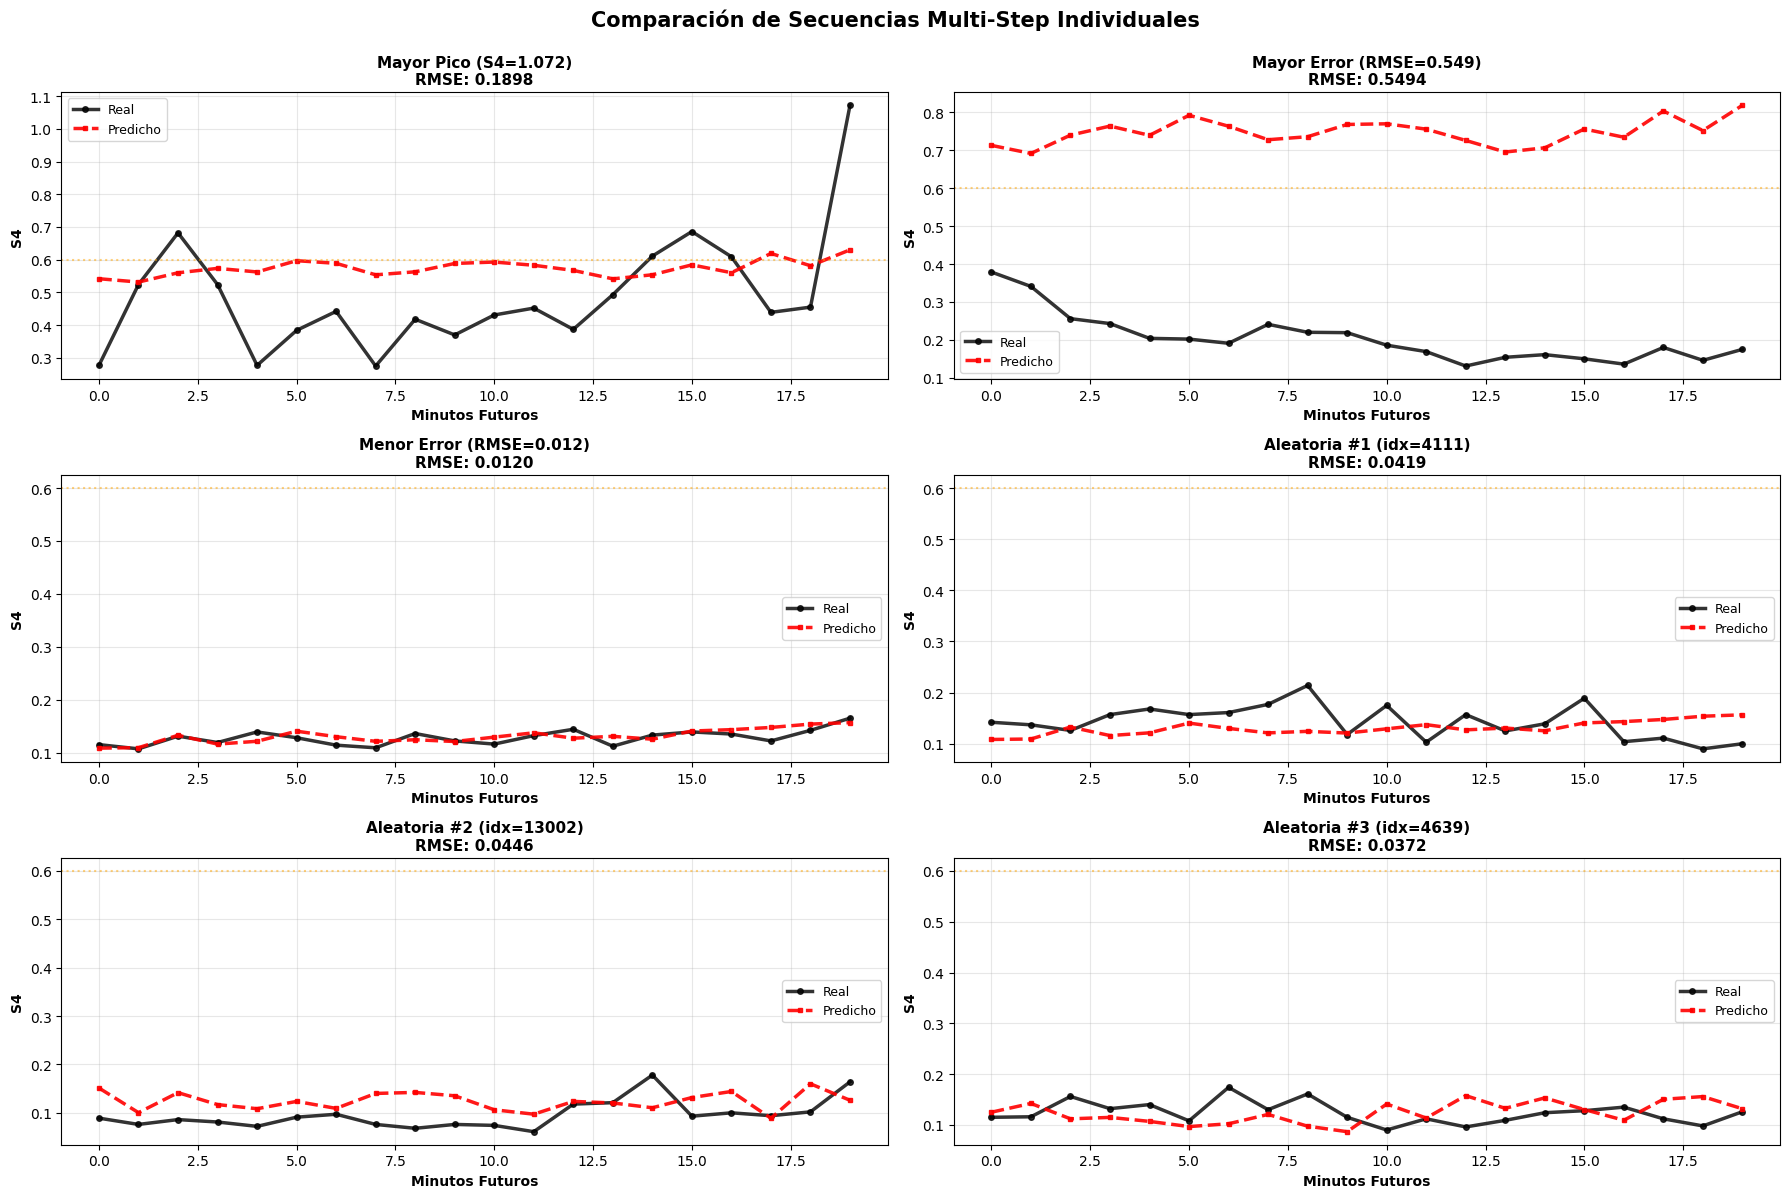


🔥 Generando heatmap de errores...


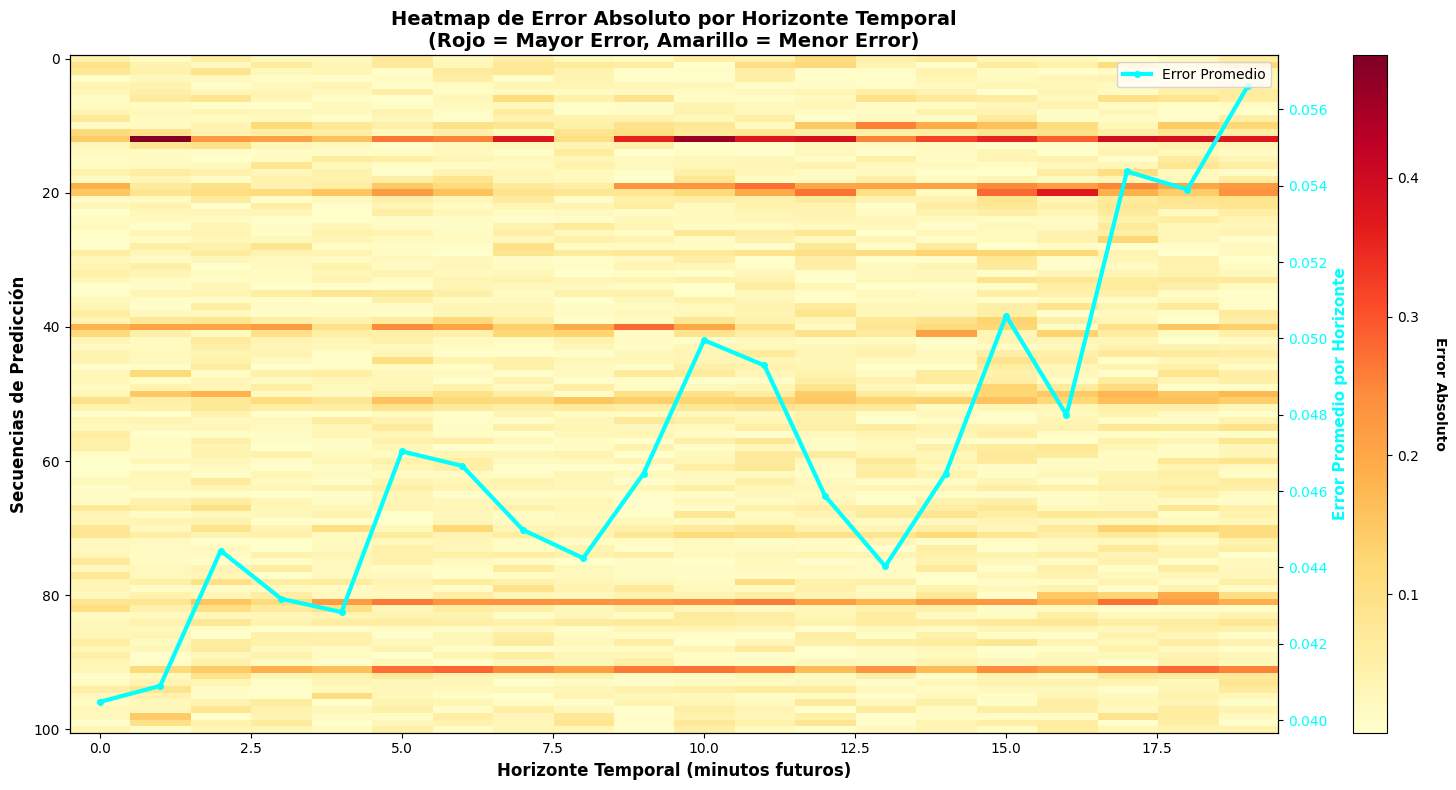


📊 ESTADÍSTICAS DE ERROR POR HORIZONTE TEMPORAL

t+ 0 minutos:
  • Error Promedio:  0.0405
  • Error Mediano:   0.0266
  • Error Máximo:    0.6494
  • Desv. Estándar:  0.0484

t+ 5 minutos:
  • Error Promedio:  0.0470
  • Error Mediano:   0.0288
  • Error Máximo:    0.7446
  • Desv. Estándar:  0.0629

t+10 minutos:
  • Error Promedio:  0.0500
  • Error Mediano:   0.0302
  • Error Máximo:    0.6950
  • Desv. Estándar:  0.0653

t+15 minutos:
  • Error Promedio:  0.0506
  • Error Mediano:   0.0321
  • Error Máximo:    0.6308
  • Desv. Estándar:  0.0655

t+19 minutos:
  • Error Promedio:  0.0566
  • Error Mediano:   0.0356
  • Error Máximo:    0.6836
  • Desv. Estándar:  0.0745

✅ Visualización completa multi-step finalizada.


📊 ANÁLISIS DE ESCENARIOS CLAVE (Multi-Step)

🌍 Escenario 1: Visión General...
   Mostrando primeras 50 secuencias (~1000 puntos)


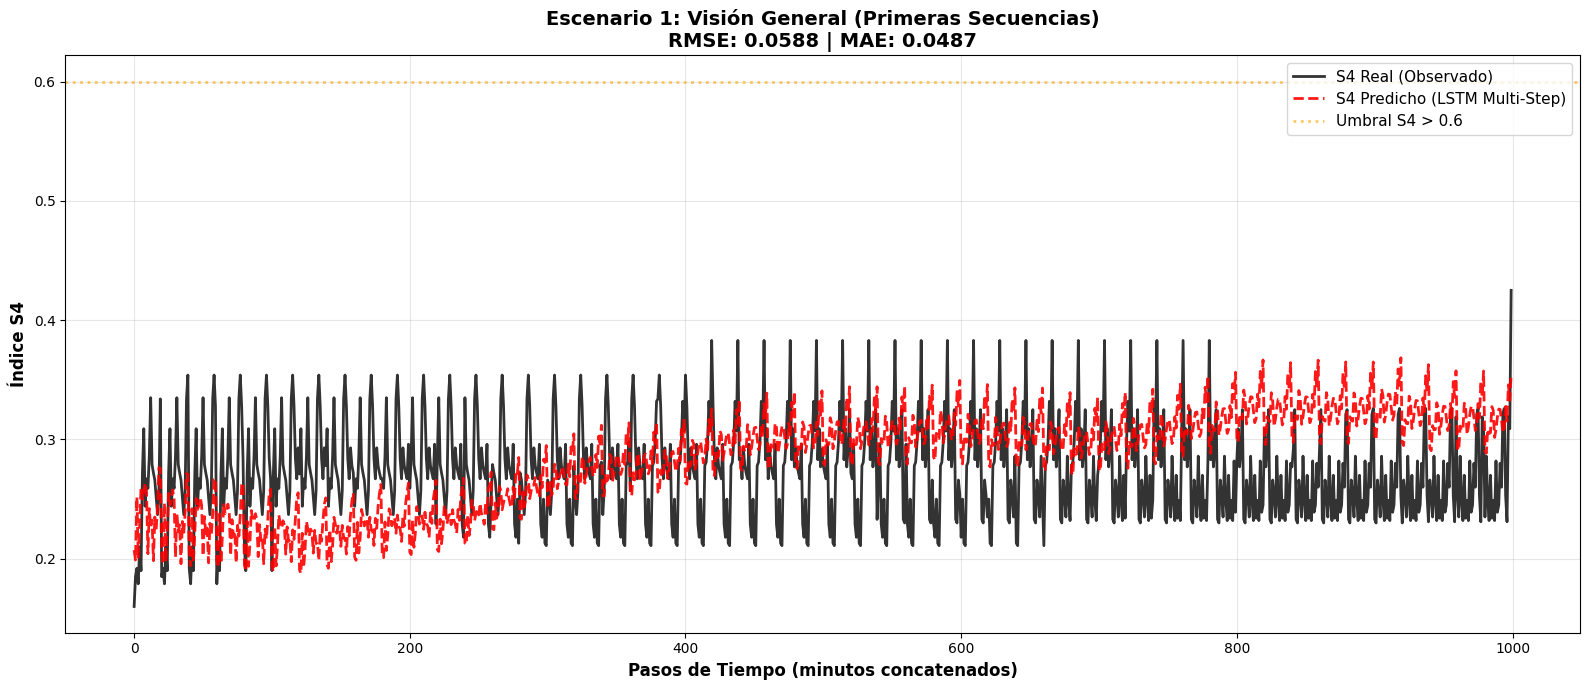


⚡ Escenario 2: Buscando la tormenta más fuerte...
   🔎 Pico máximo detectado: S4 = 1.0720
   📍 Ubicación: Secuencia #1566, Horizonte t+19
   📊 Mostrando ventana: secuencias 1556 a 1576


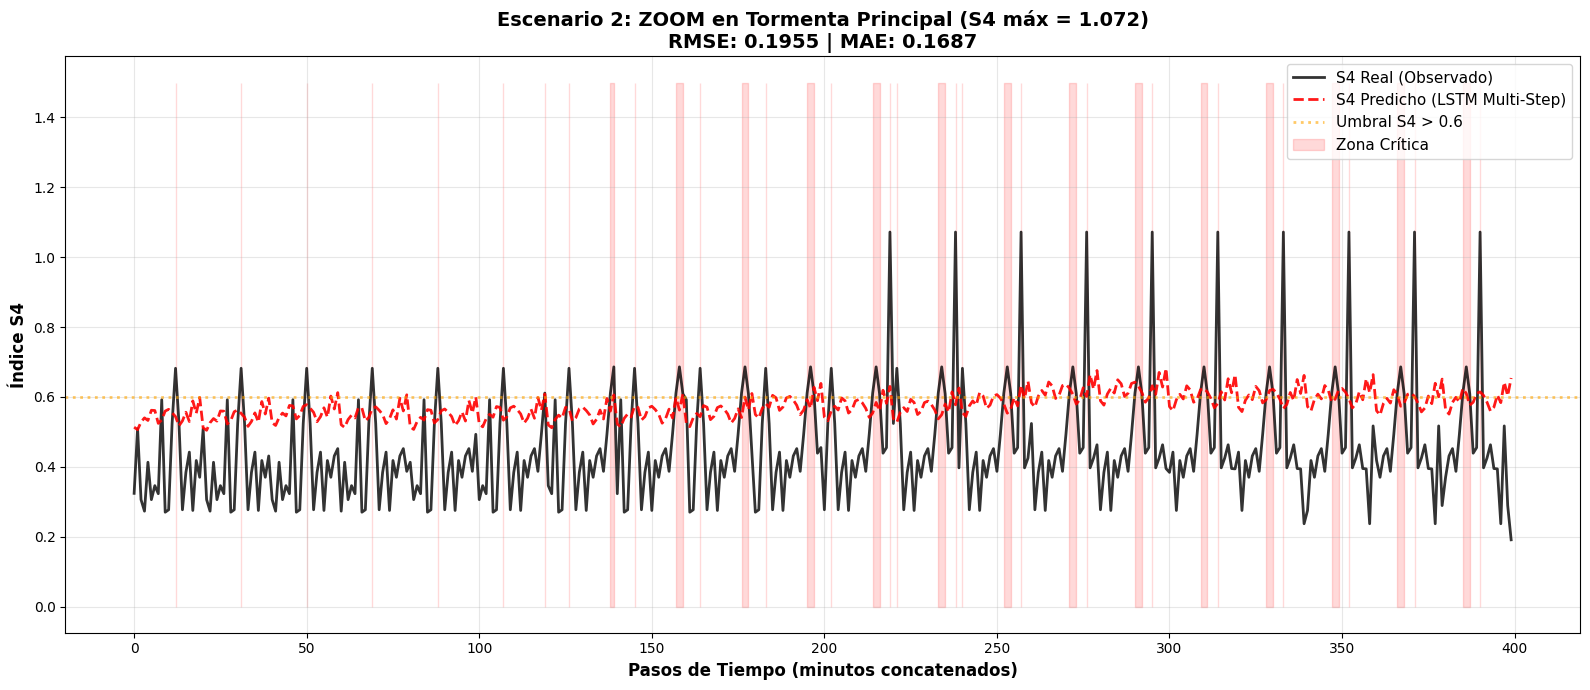


🌪️ Escenario 3: Identificando múltiples tormentas...
   Total de secuencias con eventos críticos: 224


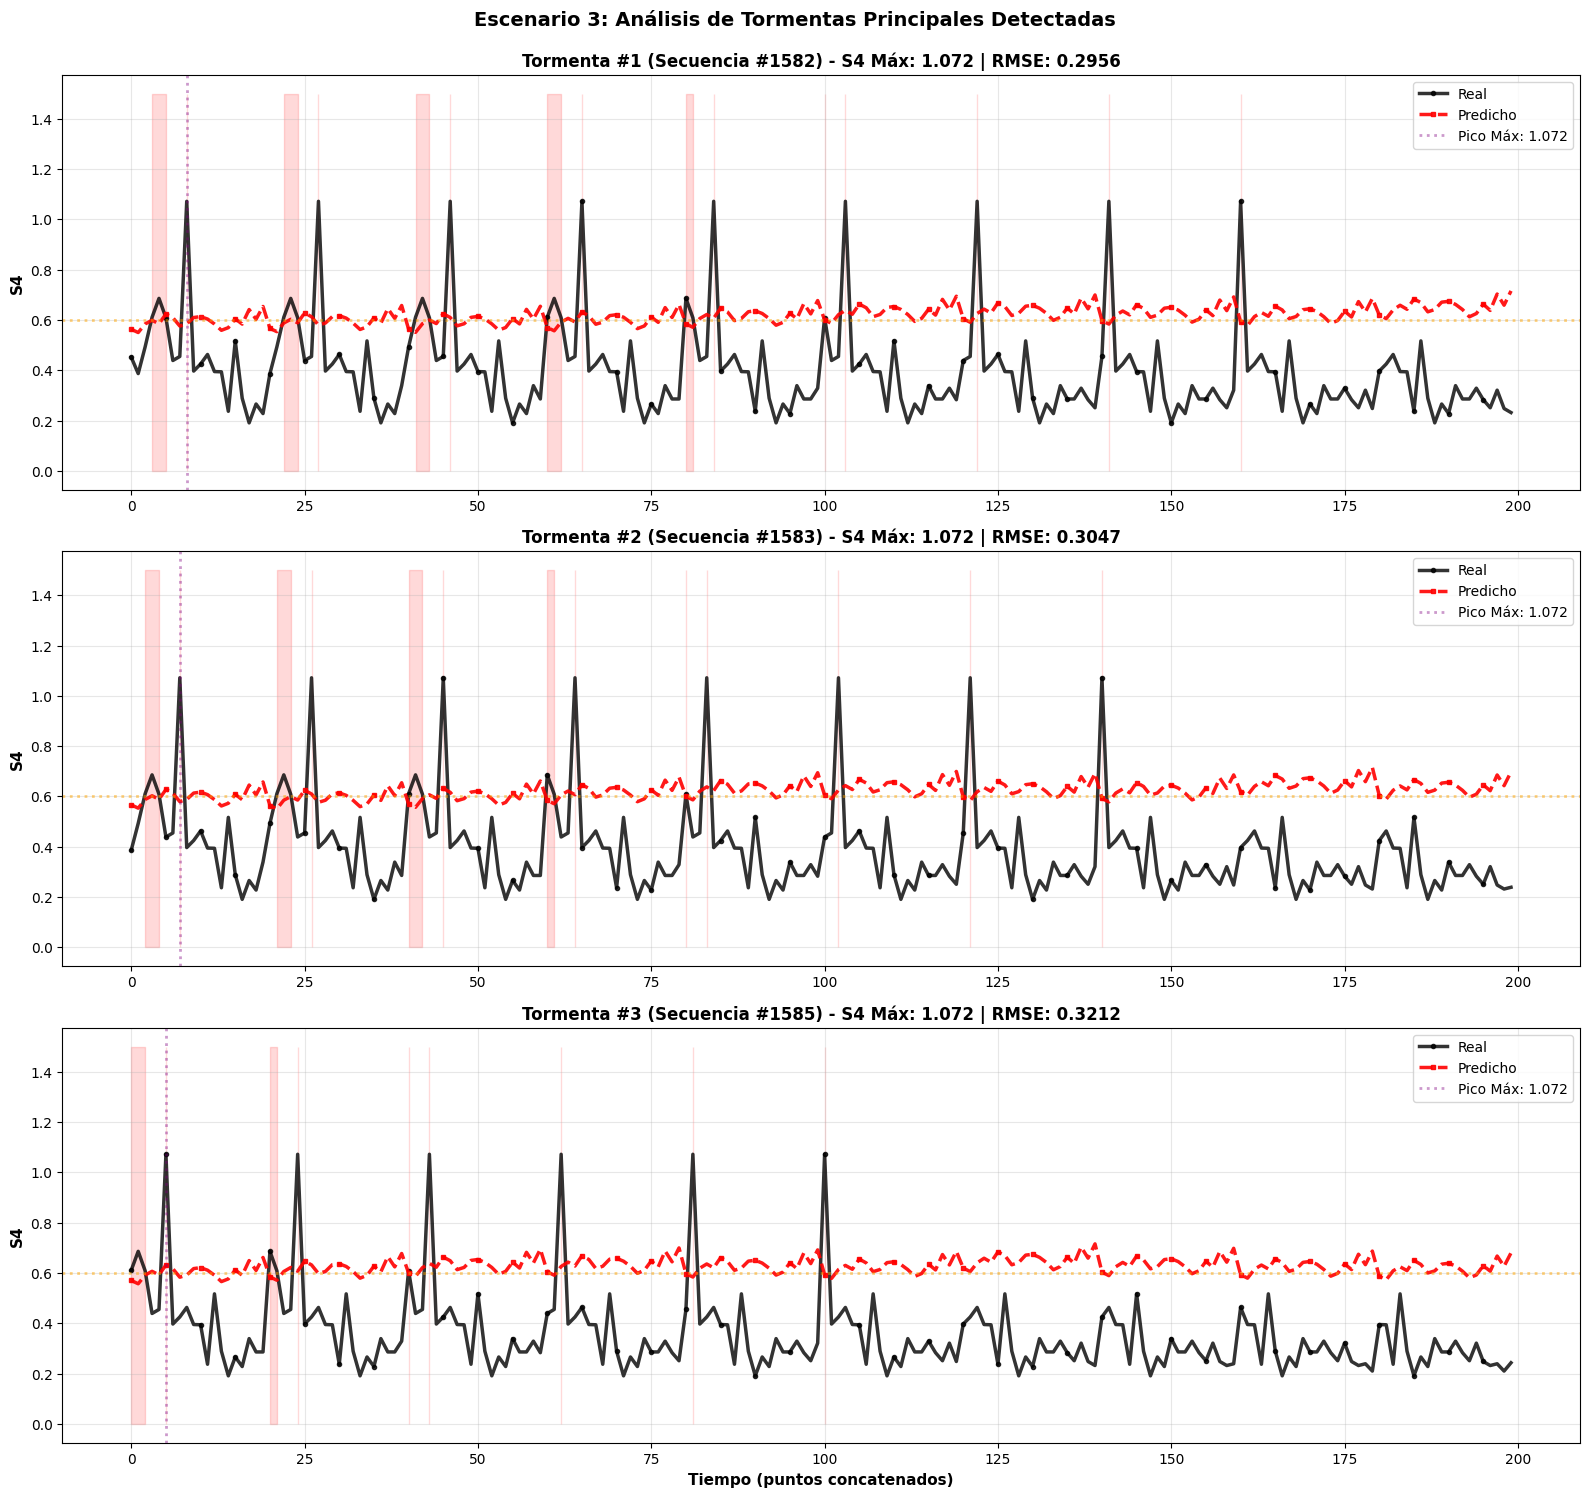


📈 ESTADÍSTICAS DE TORMENTAS DETECTADAS

🏆 Tormenta #1 (Secuencia #1582):
   • S4 Máximo:      1.0720
   • Posición pico:  t+3 minutos
   • RMSE secuencia: 0.3047
   • MAE secuencia:  0.2825
   • Predicción del pico: 0.6383
   • Error en el pico:    0.4337

🏆 Tormenta #2 (Secuencia #1583):
   • S4 Máximo:      1.0720
   • Posición pico:  t+2 minutos
   • RMSE secuencia: 0.3215
   • MAE secuencia:  0.3054
   • Predicción del pico: 0.6259
   • Error en el pico:    0.4461

🏆 Tormenta #3 (Secuencia #1585):
   • S4 Máximo:      1.0720
   • Posición pico:  t+0 minutos
   • RMSE secuencia: 0.3287
   • MAE secuencia:  0.3121
   • Predicción del pico: 0.5923
   • Error en el pico:    0.4797



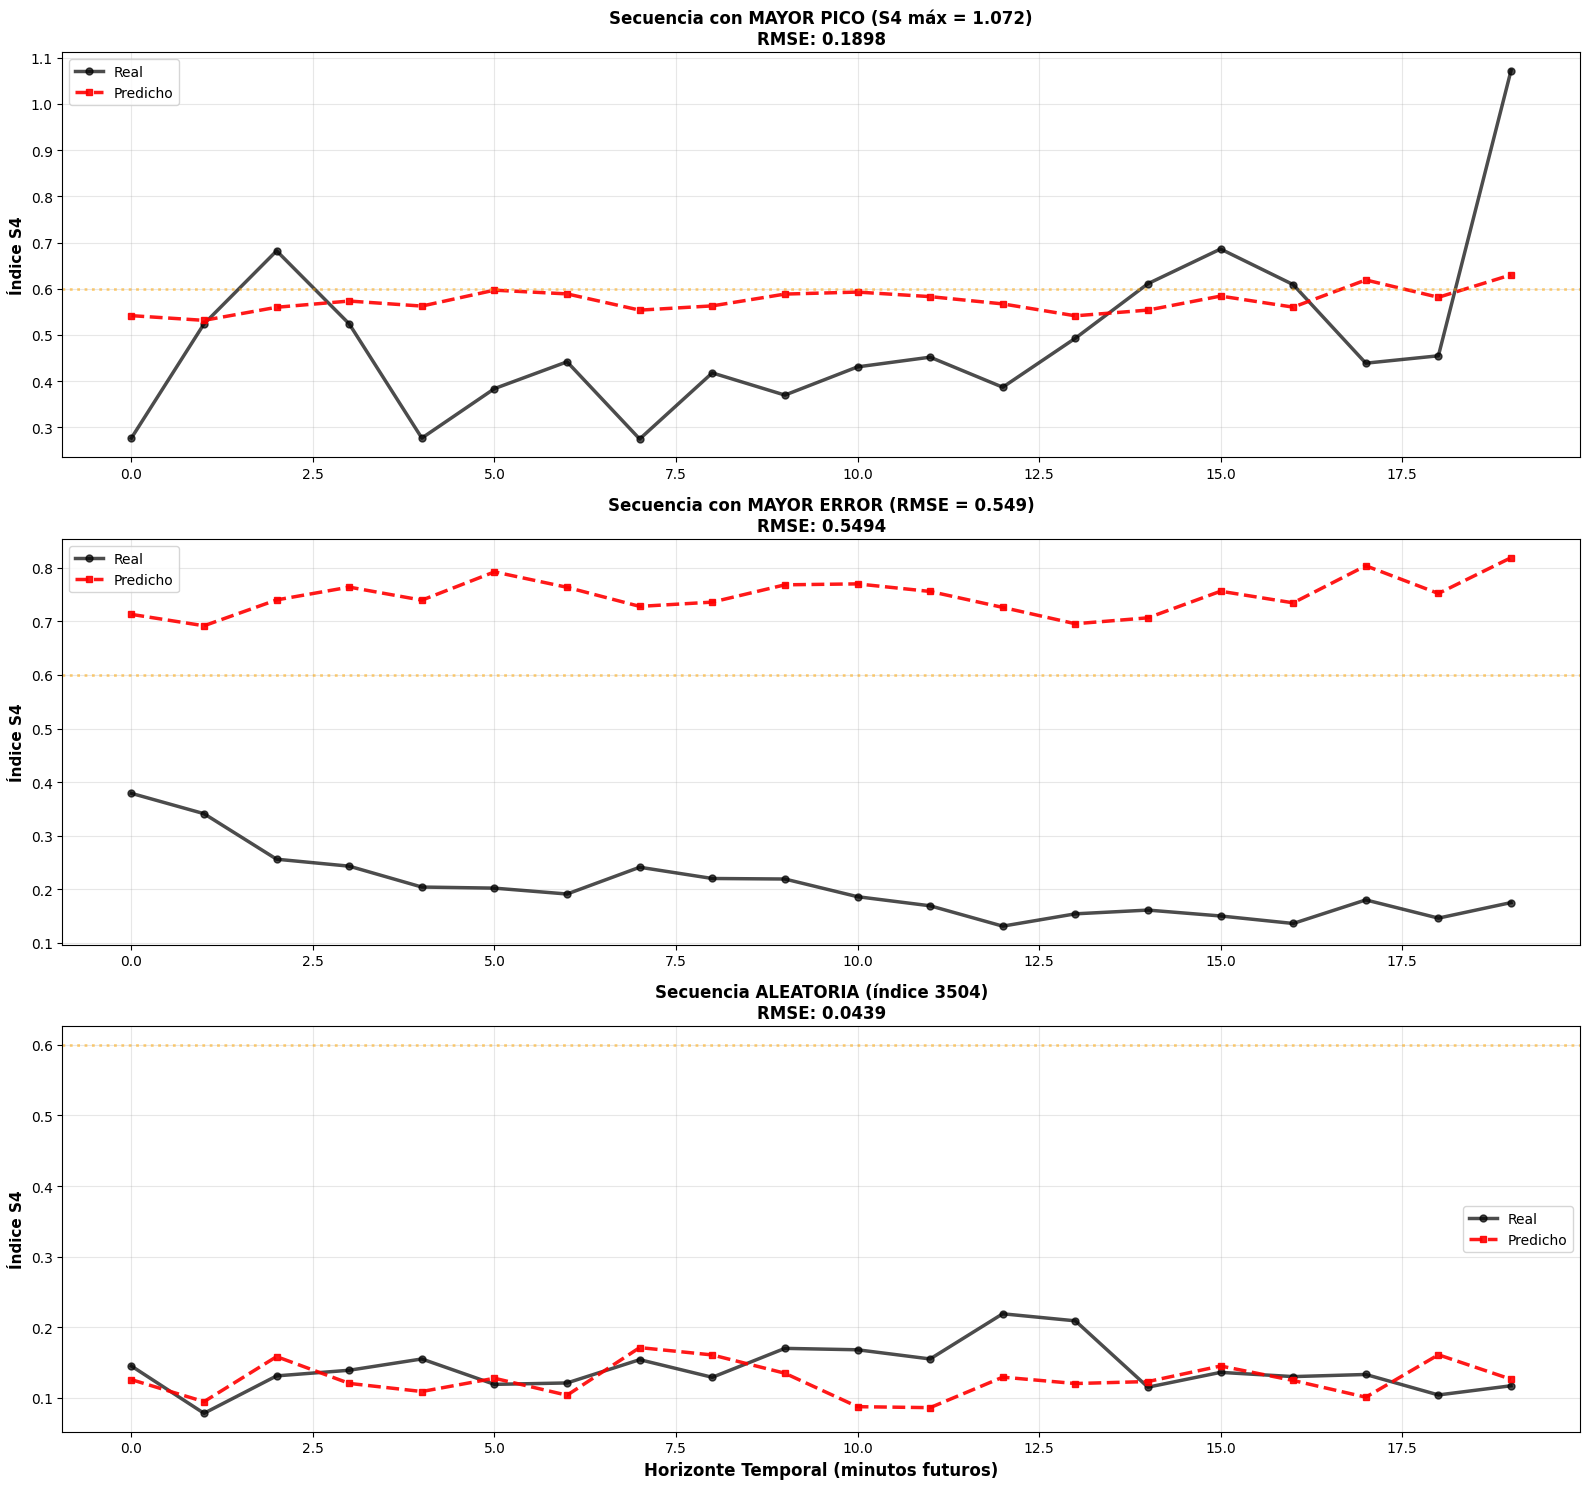


📋 RESUMEN FINAL DEL PIPELINE MULTI-STEP

✅ Configuración:
   • Lookback: 60 minutos
   • Horizon: 20 minutos (secuencia completa)
   • Features: 9
   • Arquitectura: LSTM Bidireccional Multi-Step

✅ Datos:
   • Train: 52260 secuencias
   • Val:   10687 secuencias
   • Test:  13227 secuencias

✅ Rendimiento:
   • Global RMSE:  0.0774
   • Global MAE:   0.0470
   • Event RMSE:   0.3415
   • Event MAE:    0.2937

🎉 PIPELINE MULTI-STEP FINALIZADO EXITOSAMENTE

💾 Guardando modelo entrenado...
   ✅ Modelo guardado como: modelo_final_multistep.keras

✨ ¡Proceso completado! ✨



In [49]:
# CÓDIGO ACTUALIZADO CON MULTI-STEP OUTPUT
# Autor: Alexander Valdez Portocarrero (Actualizado)
# Descripción: Predicción de secuencias completas con validación temporal
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# =============================================================================
# 7. GENERACIÓN DE VENTANAS MULTI-STEP (ACTUALIZADO)
# =============================================================================

def crear_dataset_lstm_multistep_con_gaps(df, cols_input, col_target, lookback=60, horizon=20):
    """
    Genera tensores X e y con validación temporal rigurosa.
    
    CAMBIO CLAVE: Ahora y contiene una SECUENCIA de 'horizon' valores futuros,
    no solo un punto.
    
    Args:
        df: DataFrame con índice temporal
        cols_input: Lista de columnas para features de entrada
        col_target: Nombre de la columna objetivo (e.g., 'S4')
        lookback: Ventana de entrada (minutos hacia atrás)
        horizon: Ventana de salida (minutos hacia adelante)
    
    Returns:
        X: shape (m, lookback, n_features) - Ventanas de entrada
        y: shape (m, horizon) - SECUENCIAS de salida
    """
    # 1. Preparación de datos
    data_values = df[cols_input].values  
    target_values = df[col_target].values
    timestamps = df.index.to_series().values
    
    X, y = [], []
    
    # 2. Bucle Principal con Validación Temporal
    for i in range(lookback, len(df) - horizon):
        
        # --- VALIDACIÓN TEMPORAL (GAP CONTROL) ---
        t_inicio = timestamps[i - lookback]      # Inicio de ventana de entrada
        t_actual = timestamps[i]                  # Fin de ventana de entrada (presente)
        t_fin_secuencia = timestamps[i + horizon - 1]  # Último punto de la secuencia de salida
        
        # Verificar continuidad de la ventana de ENTRADA
        diff_entrada = (t_actual - t_inicio) / np.timedelta64(1, 'm')
        if diff_entrada != lookback:
            continue
        
        # Verificar continuidad de la secuencia de SALIDA
        diff_salida = (t_fin_secuencia - t_actual) / np.timedelta64(1, 'm')
        if diff_salida != (horizon - 1):  # horizon-1 porque empezamos en i (no en i+1)
            continue
        
        # Verificación adicional: Comprobar que NO hay gaps dentro de la secuencia de salida
        hay_gap_en_salida = False
        for j in range(i, i + horizon - 1):
            diff_consecutiva = (timestamps[j + 1] - timestamps[j]) / np.timedelta64(1, 'm')
            if diff_consecutiva != 1:
                hay_gap_en_salida = True
                break
        
        if hay_gap_en_salida:
            continue
        
        # --- SI PASA TODAS LAS VALIDACIONES, GUARDAMOS ---
        ventana_entrada = data_values[i - lookback : i]  # [t-60, t-59, ..., t-1]
        
        # CAMBIO CLAVE: Secuencia completa de salida
        secuencia_salida = target_values[i : i + horizon]  # [t, t+1, ..., t+19]
        
        X.append(ventana_entrada)
        y.append(secuencia_salida)
    
    return np.array(X), np.array(y)


def generar_tensores_multistep(train_scaled, val_scaled, test_scaled, features_cols, 
                                target_col='S4', lookback=60, horizon=20):
    """
    Función orquestadora para generar los tensores MULTI-STEP de Train, Val y Test.
    
    CAMBIO: Ahora y tiene shape (m, horizon) en lugar de (m,)
    """
    print(f"\n🎞️ Generando Ventanas Deslizantes MULTI-STEP (Lookback={lookback}, Horizon={horizon})...")
    print(f"   Features ({len(features_cols)}): {features_cols}")
    print(f"   ⚡ Output esperado: SECUENCIAS de {horizon} valores futuros")
    
    # 1. Train
    X_train, y_train = crear_dataset_lstm_multistep_con_gaps(
        train_scaled, features_cols, target_col, lookback, horizon
    )
    print(f"   ✅ TRAIN generado. X: {X_train.shape}, y: {y_train.shape}")
    
    # 2. Val
    X_val, y_val = crear_dataset_lstm_multistep_con_gaps(
        val_scaled, features_cols, target_col, lookback, horizon
    )
    print(f"   ✅ VAL generado.   X: {X_val.shape}, y: {y_val.shape}")
    
    # 3. Test
    X_test, y_test = crear_dataset_lstm_multistep_con_gaps(
        test_scaled, features_cols, target_col, lookback, horizon
    )
    print(f"   ✅ TEST generado.  X: {X_test.shape}, y: {y_test.shape}")
    
    # Verificación
    print("\n--- DIMENSIONES FINALES (Tensor Shapes) ---")
    print(f"   X_train: {X_train.shape}  (muestras, lookback, features)")
    print(f"   y_train: {y_train.shape}  (muestras, horizon) ← SECUENCIAS")
    
    return X_train, y_train, X_val, y_val, X_test, y_test


# =============================================================================
# 8. MODELADO LSTM MULTI-STEP (ACTUALIZADO)
# =============================================================================

def weighted_mse_multistep(threshold, penalty_weight=15.0):
    """
    Loss ponderada para predicción de SECUENCIAS multi-step.
    Penaliza más los errores en valores altos DENTRO de toda la secuencia.
    
    Args:
        threshold: Umbral normalizado de S4 (e.g., 0.6 normalizado)
        penalty_weight: Factor multiplicador para eventos críticos
    """
    def loss(y_true, y_pred):
        # y_true shape: (batch, horizon)
        # y_pred shape: (batch, horizon)
        
        # Error cuadrático base
        squared_error = tf.square(y_pred - y_true)
        
        # Ponderación: Penalizar más donde y_true >= threshold
        weights = tf.where(y_true >= threshold, penalty_weight, 1.0)
        
        # Penalización adicional por subestimación en picos
        underestimation_mask = tf.logical_and(
            y_true >= threshold,
            y_pred < y_true
        )
        underestimation_penalty = tf.where(underestimation_mask, 2.0, 1.0)
        
        # Loss total ponderada
        weighted_error = squared_error * weights * underestimation_penalty
        
        # Promediamos sobre toda la secuencia y el batch
        return tf.reduce_mean(weighted_error)
    
    return loss


def weighted_focal_mse_multistep(threshold, alpha=2.0, beta=50.0):
    """
    Loss híbrida Focal para SECUENCIAS multi-step.
    Combina ponderación con penalización exponencial de errores grandes.
    
    Args:
        threshold: Umbral normalizado
        alpha: Exponente focal (mayor = más agresivo)
        beta: Multiplicador para eventos sobre umbral
    """
    def loss(y_true, y_pred):
        # Error base
        error = y_pred - y_true
        squared_error = tf.square(error)
        
        # COMPONENTE 1: Ponderación por umbral
        weights = tf.where(y_true >= threshold, beta, 1.0)
        
        # COMPONENTE 2: Penalización focal
        focal_weight = tf.pow(tf.abs(error) + 1e-7, alpha)
        
        # COMPONENTE 3: Extra penalización por subestimación
        underestimation_mask = tf.logical_and(
            y_true >= threshold,
            y_pred < y_true * 0.7  # Subestima más del 30%
        )
        underestimation_penalty = tf.where(underestimation_mask, 2.0, 1.0)
        
        # Combinación
        total_loss = squared_error * weights * focal_weight * underestimation_penalty
        
        return tf.reduce_mean(total_loss)
    
    return loss


def construir_modelo_lstm_multistep(input_shape, output_steps, umbral_norm, penalty=15.0):
    """
    Define y compila la arquitectura LSTM para predicción MULTI-STEP.
    
    Args:
        input_shape: (timesteps, features) ej: (60, 9)
        output_steps: número de valores futuros a predecir (horizon) ej: 20
        umbral_norm: umbral normalizado para la loss
        penalty: factor de penalización
    
    Returns:
        Modelo compilado
    """
    tf.keras.backend.clear_session()
    
    model = Sequential([
        Input(shape=input_shape),
        
        # Encoder: Comprender el contexto pasado
        Bidirectional(LSTM(128, return_sequences=True, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),
        
        Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),
        
        # Decoder: Generar secuencia futura
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(64, activation='relu'),
        
        # SALIDA: Vector de 'output_steps' predicciones
        Dense(output_steps, activation='linear')  # ← Predice todos los pasos
    ], name="LSTM_MultiStep")
    
    # Loss adaptada para multi-step
    loss_fn = weighted_focal_mse_multistep(
        threshold=umbral_norm, 
        alpha=1.5, 
        beta=penalty
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=loss_fn,
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
    )
    
    print("\n🧠 Modelo LSTM Multi-Step Compilado:")
    print(f"   Input:  {input_shape}")
    print(f"   Output: {output_steps} valores futuros")
    model.summary()
    
    return model


def entrenar_modelo_multistep(model, X_train, y_train, X_val, y_val, 
                               batch_size=64, epochs=100):
    """
    Ejecuta el entrenamiento del modelo multi-step con callbacks mejorados.
    """
    callbacks = [
        EarlyStopping(
            monitor='val_loss', 
            patience=15,  # Más paciencia para multi-step
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            filepath='modelo_s4_lstm_multistep_mejor.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    print("\n🚀 Iniciando entrenamiento Multi-Step...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    return history, model


# =============================================================================
# 9. PREDICCIÓN Y DESNORMALIZACIÓN MULTI-STEP (ACTUALIZADO)
# =============================================================================

def desnormalizar_secuencia(data_scaled, scaler, features_cols, col_target='S4'):
    """
    Des-normaliza secuencias multi-step.
    Funciona tanto para arrays 1D como 2D (secuencias).
    
    Args:
        data_scaled: Array escalado (puede ser shape (m,) o (m, horizon))
        scaler: MinMaxScaler ajustado
        features_cols: Lista de columnas de features
        col_target: Nombre de la columna objetivo
    
    Returns:
        Array desnormalizado en la misma forma que la entrada
    """
    idx = features_cols.index(col_target)
    
    val_min = scaler.data_min_[idx]
    val_max = scaler.data_max_[idx]
    val_range = val_max - val_min
    
    # Aplicar fórmula inversa
    data_real = (data_scaled * val_range) + val_min
    
    return data_real


def evaluar_predicciones_multistep(model, X_test, y_test, scaler, features_cols, 
                                    col_target='S4', umbral_real=0.6):
    """
    Genera predicciones MULTI-STEP y las convierte a escala real.
    
    Returns:
        y_pred_real: shape (m, horizon) - Secuencias predichas
        y_test_real: shape (m, horizon) - Secuencias reales
    """
    print("\n🔮 Generando predicciones Multi-Step sobre el Test Set...")
    
    # 1. Predecir secuencias (Escala 0-1)
    y_pred_scaled = model.predict(X_test, verbose=0)
    
    # y_pred_scaled shape: (m, horizon)
    # y_test shape: (m, horizon)
    
    print(f"   Forma predicciones escaladas: {y_pred_scaled.shape}")
    
    # 2. Des-normalizar
    y_pred_real = desnormalizar_secuencia(y_pred_scaled, scaler, features_cols, col_target)
    y_test_real = desnormalizar_secuencia(y_test, scaler, features_cols, col_target)
    
    print(f"✅ Datos convertidos a escala real.")
    print(f"   Forma final: {y_pred_real.shape}")
    print(f"   Ejemplo - Primera secuencia real:    {y_test_real[0, :5]}")
    print(f"   Ejemplo - Primera secuencia predicha: {y_pred_real[0, :5]}")
    
    # 3. MÉTRICAS POR HORIZONTE TEMPORAL
    print("\n📊 Rendimiento por Horizonte Temporal:")
    horizonte_steps = y_test_real.shape[1]
    indices_a_mostrar = [0, horizonte_steps//4, horizonte_steps//2, 
                         3*horizonte_steps//4, horizonte_steps-1]
    
    for h in indices_a_mostrar:
        if h < horizonte_steps:
            rmse_h = np.sqrt(mean_squared_error(y_test_real[:, h], y_pred_real[:, h]))
            mae_h = mean_absolute_error(y_test_real[:, h], y_pred_real[:, h])
            print(f"   t+{h:2d} min → RMSE: {rmse_h:.4f}, MAE: {mae_h:.4f}")
    
    return y_pred_real, y_test_real


# =============================================================================
# 10. EVALUACIÓN Y VISUALIZACIÓN MULTI-STEP (ACTUALIZADO)
# =============================================================================

def evaluar_rendimiento_multistep(y_true, y_pred, umbral_evento=0.6):
    """
    Calcula métricas para predicciones MULTI-STEP.
    
    Args:
        y_true: shape (m, horizon)
        y_pred: shape (m, horizon)
        umbral_evento: umbral de S4 para considerar evento
    
    Returns:
        Tupla (rmse_global, rmse_eventos, mae_global, mae_eventos)
    """
    # Aplanar las secuencias para métricas globales
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # 1. Métricas Globales
    rmse_global = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    mae_global = mean_absolute_error(y_true_flat, y_pred_flat)
    
    # 2. Métricas solo en Eventos
    mask_eventos = y_true_flat >= umbral_evento
    
    if np.sum(mask_eventos) > 0:
        rmse_eventos = np.sqrt(mean_squared_error(
            y_true_flat[mask_eventos], 
            y_pred_flat[mask_eventos]
        ))
        mae_eventos = mean_absolute_error(
            y_true_flat[mask_eventos], 
            y_pred_flat[mask_eventos]
        )
    else:
        rmse_eventos = 0
        mae_eventos = 0
        print("⚠️ No se encontraron eventos > 0.6 en este set de datos.")
    
    print(f"\n--- REPORTE DE RENDIMIENTO MULTI-STEP ---")
    print(f"📊 Métricas Globales (todas las predicciones):")
    print(f"   Global RMSE: {rmse_global:.4f}")
    print(f"   Global MAE:  {mae_global:.4f}")
    print(f"-"*50)
    print(f"⚡ Métricas en Eventos (S4 > {umbral_evento}):")
    print(f"   Event RMSE:  {rmse_eventos:.4f}")
    print(f"   Event MAE:   {mae_eventos:.4f}")
    print(f"   Puntos en eventos: {np.sum(mask_eventos)} / {len(y_true_flat)}")
    
    return rmse_global, rmse_eventos, mae_global, mae_eventos


def visualizar_prediccion_multistep(y_real, y_pred, idx_muestra=0, umbral=0.6):
    """
    Visualiza UNA secuencia multi-step específica.
    
    Args:
        y_real: shape (m, horizon)
        y_pred: shape (m, horizon)
        idx_muestra: índice de la muestra a visualizar
        umbral: umbral de S4 para graficar
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    horizonte = y_real.shape[1]
    x_axis = np.arange(horizonte)
    
    # Serie real
    ax.plot(x_axis, y_real[idx_muestra], 
            label='Secuencia Real', 
            color='black', 
            linewidth=2.5, 
            marker='o',
            markersize=6,
            alpha=0.8)
    
    # Serie predicha
    ax.plot(x_axis, y_pred[idx_muestra], 
            label='Secuencia Predicha', 
            color='red', 
            linewidth=2.5, 
            marker='s',
            markersize=5,
            linestyle='--',
            alpha=0.9)
    
    # Umbral
    ax.axhline(y=umbral, color='orange', linestyle=':', linewidth=2, 
               alpha=0.5, label=f'Umbral S4 = {umbral}')
    
    # Calcular error de esta secuencia
    rmse_seq = np.sqrt(mean_squared_error(y_real[idx_muestra], y_pred[idx_muestra]))
    mae_seq = mean_absolute_error(y_real[idx_muestra], y_pred[idx_muestra])
    
    ax.set_xlabel('Horizonte Temporal (minutos futuros)', fontweight='bold', fontsize=12)
    ax.set_ylabel('Índice S4', fontweight='bold', fontsize=12)
    ax.set_title(f'Predicción Multi-Step - Muestra #{idx_muestra}\n' + 
                f'RMSE: {rmse_seq:.4f}, MAE: {mae_seq:.4f}', 
                fontweight='bold', fontsize=13)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def visualizar_resultados_finales_multistep(y_true, y_pred, umbral=0.6, n_ejemplos=3):
    """
    Orquesta la visualización de múltiples predicciones multi-step.
    
    Args:
        y_true: shape (m, horizon)
        y_pred: shape (m, horizon)
        umbral: umbral de S4
        n_ejemplos: cuántas secuencias mostrar
    """
    # 1. Encontrar índices de interés
    # - Secuencia con mayor pico real
    max_peaks = y_true.max(axis=1)
    idx_max_peak = np.argmax(max_peaks)
    
    # - Secuencia con mayor error
    errors = np.sqrt(((y_true - y_pred)**2).mean(axis=1))
    idx_max_error = np.argmax(errors)
    
    # - Secuencia aleatoria
    idx_random = np.random.randint(0, len(y_true))
    
    indices = [idx_max_peak, idx_max_error, idx_random]
    titulos = [
        f"Secuencia con MAYOR PICO (S4 máx = {y_true[idx_max_peak].max():.3f})",
        f"Secuencia con MAYOR ERROR (RMSE = {errors[idx_max_error]:.3f})",
        f"Secuencia ALEATORIA (índice {idx_random})"
    ]
    
    # 2. Graficar
    fig, axes = plt.subplots(len(indices), 1, figsize=(16, 5*len(indices)))
    
    if len(indices) == 1:
        axes = [axes]
    
    for ax, idx, titulo in zip(axes, indices, titulos):
        horizonte = y_true.shape[1]
        x_axis = np.arange(horizonte)
        
        # Real
        ax.plot(x_axis, y_true[idx], 
               label='Real', 
               color='black', 
               linewidth=2.5, 
               marker='o',
               markersize=5,
               alpha=0.7)
        
        # Predicho
        ax.plot(x_axis, y_pred[idx], 
               label='Predicho', 
               color='red', 
               linewidth=2.5, 
               marker='s',
               markersize=4,
               linestyle='--',
               alpha=0.9)
        
        # Umbral
        ax.axhline(y=umbral, color='orange', linestyle=':', linewidth=2, alpha=0.5)
        
        # Error por punto
        rmse_seq = np.sqrt(mean_squared_error(y_true[idx], y_pred[idx]))
        
        ax.set_ylabel('Índice S4', fontweight='bold', fontsize=11)
        ax.set_title(f'{titulo}\nRMSE: {rmse_seq:.4f}', 
                    fontweight='bold', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Horizonte Temporal (minutos futuros)', 
                        fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    plt.show()


def calcular_metricas_multistep(y_true, y_pred, umbral_evento=0.6):
    """
    Calcula métricas y retorna un diccionario para multi-step.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Global
    rmse_global = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    mae_global = mean_absolute_error(y_true_flat, y_pred_flat)
    
    # Eventos
    mask_eventos = y_true_flat >= umbral_evento
    
    if np.sum(mask_eventos) > 0:
        rmse_eventos = np.sqrt(mean_squared_error(
            y_true_flat[mask_eventos], 
            y_pred_flat[mask_eventos]
        ))
        mae_eventos = mean_absolute_error(
            y_true_flat[mask_eventos], 
            y_pred_flat[mask_eventos]
        )
    else:
        rmse_eventos = 0
        mae_eventos = 0
    
    return {
        "Global_RMSE": rmse_global,
        "Global_MAE": mae_global,
        "Event_RMSE": rmse_eventos,
        "Event_MAE": mae_eventos
    }


# =============================================================================
# 11. GESTIÓN DE EXPERIMENTOS MULTI-STEP (ACTUALIZADO)
# =============================================================================

def ejecutar_experimento_iterativo_multistep(train_s, val_s, test_s, features_cols, 
                                             scaler, lookbacks, horizons):
    """
    Ejecuta un Grid Search sobre combinaciones de Lookback y Horizon con MULTI-STEP.
    """
    resultados = []
    total_iteraciones = len(lookbacks) * len(horizons)
    iter_actual = 0
    
    print(f"\n🧪 INICIANDO EXPERIMENTO ITERATIVO MULTI-STEP ({total_iteraciones} Combinaciones)...")
    print(f"   Lookbacks: {lookbacks}")
    print(f"   Horizons:  {horizons}")
    print(f"   🔥 Ahora cada y contiene SECUENCIAS completas")
    print("="*70)
    
    # Umbral constante
    umbral_norm = calcular_umbral_normalizado(scaler, features_cols, umbral_real=0.6)
    
    for lb in lookbacks:
        for hz in horizons:
            iter_actual += 1
            print(f"\n🔄 [{iter_actual}/{total_iteraciones}] Probando: Lookback={lb} min, Horizon={hz} min")
            
            # 1. Generar Tensores Multi-Step
            X_train, y_train, X_val, y_val, X_test, y_test = generar_tensores_multistep(
                train_s, val_s, test_s, features_cols, 
                target_col='S4', lookback=lb, horizon=hz
            )
            
            if X_train.shape[0] == 0:
                print("   ⚠️ Salto: No hay suficientes datos para esta ventana.")
                continue
            
            # 2. Construir Modelo Multi-Step
            input_shape = (X_train.shape[1], X_train.shape[2])
            output_steps = hz  # El horizonte define cuántos valores predecir
            
            model = construir_modelo_lstm_multistep(
                input_shape, output_steps, umbral_norm, penalty=45.0
            )
            
            # 3. Entrenar
            history, _ = entrenar_modelo_multistep(
                model, 
                X_train.astype('float32'), y_train.astype('float32'), 
                X_val.astype('float32'), y_val.astype('float32'), 
                batch_size=64, epochs=60
            )
            
            # 4. Evaluar
            y_pred, y_real = evaluar_predicciones_multistep(
                model, X_test, y_test, scaler, features_cols
            )
            metricas = calcular_metricas_multistep(y_real, y_pred, umbral_evento=0.6)
            
            # 5. Guardar Resultados
            registro = {
                "Lookback": lb,
                "Horizon": hz,
                **metricas
            }
            resultados.append(registro)
            
            print(f"   📊 Event RMSE={metricas['Event_RMSE']:.4f} | Global RMSE={metricas['Global_RMSE']:.4f}")
    
    return pd.DataFrame(resultados)


# =============================================================================
# FUNCIÓN AUXILIAR (ya estaba definida pero la incluyo por completitud)
# =============================================================================

def calcular_umbral_normalizado(scaler, features_cols, umbral_real=0.6, col_target='S4'):
    """
    Calcula el equivalente de 0.6 S4 en la escala 0-1.
    """
    idx_target = features_cols.index(col_target)
    
    val_min = scaler.data_min_[idx_target]
    val_max = scaler.data_max_[idx_target]
    
    umbral_norm = (umbral_real - val_min) / (val_max - val_min)
    
    print(f"\n📏 Cálculo de Umbral Normalizado:")
    print(f"   S4 Real: {umbral_real}  =>  S4 Norm: {umbral_norm:.4f}")
    
    return umbral_norm


# =============================================================================
# VISUALIZACIÓN COMPARATIVA MULTI-STEP (NUEVO)
# =============================================================================

def graficar_escenario_multistep(y_true, y_pred, inicio, fin, titulo="Comparación Multi-Step", umbral=0.6):
    """
    Grafica una ventana específica de tiempo comparando Real vs Predicho para datos MULTI-STEP.
    
    Args:
        y_true: shape (m, horizon) - Secuencias reales
        y_pred: shape (m, horizon) - Secuencias predichas
        inicio: índice de muestra inicial
        fin: índice de muestra final
        titulo: título del gráfico
        umbral: umbral de S4
    """
    # Aplanar solo la ventana seleccionada
    y_true_window = y_true[inicio:fin].flatten()
    y_pred_window = y_pred[inicio:fin].flatten()
    
    plt.figure(figsize=(16, 7))
    
    x_axis = np.arange(len(y_true_window))
    
    # Real
    plt.plot(x_axis, y_true_window, 
            label='S4 Real (Observado)', 
            color='black', 
            linewidth=2, 
            alpha=0.8)
    
    # Predicho
    plt.plot(x_axis, y_pred_window, 
            label='S4 Predicho (LSTM Multi-Step)', 
            color='red', 
            linestyle='--', 
            linewidth=2, 
            alpha=0.9)
    
    # Umbral
    plt.axhline(y=umbral, color='orange', linestyle=':', linewidth=2, 
               label=f'Umbral S4 > {umbral}', alpha=0.6)
    
    # Sombrear zonas críticas
    mask_critico = y_true_window >= umbral
    if np.any(mask_critico):
        plt.fill_between(x_axis, 0, 1.5, where=mask_critico, 
                        color='red', alpha=0.15, label='Zona Crítica')
    
    # Calcular métricas de esta ventana
    rmse_window = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    mae_window = mean_absolute_error(y_true_window, y_pred_window)
    
    plt.title(f'{titulo}\nRMSE: {rmse_window:.4f} | MAE: {mae_window:.4f}', 
             fontweight='bold', fontsize=14)
    plt.ylabel('Índice S4', fontweight='bold', fontsize=12)
    plt.xlabel('Pasos de Tiempo (minutos concatenados)', fontweight='bold', fontsize=12)
    plt.legend(loc='upper right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def visualizar_escenarios_clave_multistep(y_true, y_pred, umbral=0.6):
    """
    Visualización estilo 'escenarios' adaptada para MULTI-STEP.
    Similar a visualizar_resultados_finales pero para datos multi-step.
    
    Genera:
    1. Visión general (primeras N secuencias aplanadas)
    2. Zoom en la tormenta más fuerte
    3. Análisis de múltiples tormentas detectadas
    
    Args:
        y_true: shape (m, horizon)
        y_pred: shape (m, horizon)
        umbral: umbral de S4
    """
    print("\n" + "="*70)
    print("📊 ANÁLISIS DE ESCENARIOS CLAVE (Multi-Step)")
    print("="*70)
    
    # =========================================================================
    # ESCENARIO 1: VISIÓN GENERAL
    # =========================================================================
    print("\n🌍 Escenario 1: Visión General...")
    
    # Mostrar primeras N secuencias (equivalente a ~1000 puntos)
    n_muestras_totales = y_true.shape[0]
    horizon = y_true.shape[1]
    
    # Calcular cuántas secuencias equivalen a ~1000 puntos
    n_secuencias_mostrar = min(50, n_muestras_totales)  # Máximo 50 secuencias
    puntos_totales = n_secuencias_mostrar * horizon
    
    print(f"   Mostrando primeras {n_secuencias_mostrar} secuencias (~{puntos_totales} puntos)")
    
    graficar_escenario_multistep(
        y_true, y_pred, 
        inicio=0, 
        fin=n_secuencias_mostrar,
        titulo="Escenario 1: Visión General (Primeras Secuencias)",
        umbral=umbral
    )
    
    # =========================================================================
    # ESCENARIO 2: ZOOM EN LA TORMENTA MÁS FUERTE
    # =========================================================================
    print("\n⚡ Escenario 2: Buscando la tormenta más fuerte...")
    
    # Encontrar la secuencia con el pico máximo
    max_por_secuencia = y_true.max(axis=1)  # Máximo de cada secuencia
    idx_max_secuencia = np.argmax(max_por_secuencia)
    val_max_global = max_por_secuencia[idx_max_secuencia]
    
    # Encontrar en qué posición del horizonte está el pico
    idx_max_en_horizonte = np.argmax(y_true[idx_max_secuencia])
    
    print(f"   🔎 Pico máximo detectado: S4 = {val_max_global:.4f}")
    print(f"   📍 Ubicación: Secuencia #{idx_max_secuencia}, Horizonte t+{idx_max_en_horizonte}")
    
    # Ventana: ±10 secuencias alrededor del pico
    margen = 10
    start_zoom = max(0, idx_max_secuencia - margen)
    end_zoom = min(n_muestras_totales, idx_max_secuencia + margen)
    
    print(f"   📊 Mostrando ventana: secuencias {start_zoom} a {end_zoom}")
    
    graficar_escenario_multistep(
        y_true, y_pred,
        inicio=start_zoom,
        fin=end_zoom,
        titulo=f"Escenario 2: ZOOM en Tormenta Principal (S4 máx = {val_max_global:.3f})",
        umbral=umbral
    )
    
    # =========================================================================
    # ESCENARIO 3: ANÁLISIS DE MÚLTIPLES TORMENTAS
    # =========================================================================
    print("\n🌪️ Escenario 3: Identificando múltiples tormentas...")
    
    # Detectar todas las secuencias con picos significativos
    secuencias_con_tormentas = np.where(max_por_secuencia >= umbral)[0]
    n_tormentas = len(secuencias_con_tormentas)
    
    print(f"   Total de secuencias con eventos críticos: {n_tormentas}")
    
    if n_tormentas == 0:
        print("   ⚠️ No se detectaron tormentas significativas.")
        return
    
    # Seleccionar las 3 tormentas más fuertes (si hay suficientes)
    n_mostrar = min(3, n_tormentas)
    indices_top = np.argsort(max_por_secuencia)[-n_mostrar:][::-1]  # Top 3 descendente
    
    fig, axes = plt.subplots(n_mostrar, 1, figsize=(16, 5*n_mostrar))
    
    if n_mostrar == 1:
        axes = [axes]
    
    for idx_subplot, idx_tormenta in enumerate(indices_top):
        ax = axes[idx_subplot]
        
        # Ventana alrededor de esta tormenta
        margen_tornado = 5
        start = max(0, idx_tormenta - margen_tornado)
        end = min(n_muestras_totales, idx_tormenta + margen_tornado)
        
        # Aplanar ventana
        y_true_window = y_true[start:end].flatten()
        y_pred_window = y_pred[start:end].flatten()
        x_axis = np.arange(len(y_true_window))
        
        # Graficar
        ax.plot(x_axis, y_true_window, 
               label='Real', 
               color='black', 
               linewidth=2.5, 
               alpha=0.8,
               marker='o',
               markersize=3,
               markevery=5)
        
        ax.plot(x_axis, y_pred_window, 
               label='Predicho', 
               color='red', 
               linewidth=2.5, 
               linestyle='--',
               alpha=0.9,
               marker='s',
               markersize=2.5,
               markevery=5)
        
        # Umbral
        ax.axhline(y=umbral, color='orange', linestyle=':', linewidth=2, alpha=0.5)
        
        # Sombrear
        mask_critico = y_true_window >= umbral
        if np.any(mask_critico):
            ax.fill_between(x_axis, 0, 1.5, where=mask_critico, 
                           color='red', alpha=0.15)
        
        # Marcar el pico en el gráfico
        idx_pico_local = np.argmax(y_true_window)
        ax.axvline(x=idx_pico_local, color='purple', linestyle=':', 
                  linewidth=2, alpha=0.4,
                  label=f'Pico Máx: {y_true_window[idx_pico_local]:.3f}')
        
        # Métricas
        rmse_w = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
        
        ax.set_ylabel('S4', fontweight='bold', fontsize=11)
        ax.set_title(f'Tormenta #{idx_subplot+1} (Secuencia #{idx_tormenta}) - ' + 
                    f'S4 Máx: {max_por_secuencia[idx_tormenta]:.3f} | RMSE: {rmse_w:.4f}',
                    fontweight='bold', fontsize=12)
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        if idx_subplot == n_mostrar - 1:
            ax.set_xlabel('Tiempo (puntos concatenados)', fontweight='bold', fontsize=11)
    
    plt.suptitle('Escenario 3: Análisis de Tormentas Principales Detectadas',
                fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # ESTADÍSTICAS DE TORMENTAS
    # =========================================================================
    print("\n" + "="*70)
    print("📈 ESTADÍSTICAS DE TORMENTAS DETECTADAS")
    print("="*70)
    
    for rank, idx_tormenta in enumerate(indices_top, 1):
        pico = max_por_secuencia[idx_tormenta]
        
        # Calcular error en esta secuencia
        rmse_seq = np.sqrt(mean_squared_error(y_true[idx_tormenta], y_pred[idx_tormenta]))
        mae_seq = mean_absolute_error(y_true[idx_tormenta], y_pred[idx_tormenta])
        
        # Encontrar posición del pico
        pos_pico = np.argmax(y_true[idx_tormenta])
        
        print(f"\n🏆 Tormenta #{rank} (Secuencia #{idx_tormenta}):")
        print(f"   • S4 Máximo:      {pico:.4f}")
        print(f"   • Posición pico:  t+{pos_pico} minutos")
        print(f"   • RMSE secuencia: {rmse_seq:.4f}")
        print(f"   • MAE secuencia:  {mae_seq:.4f}")
        print(f"   • Predicción del pico: {y_pred[idx_tormenta, pos_pico]:.4f}")
        print(f"   • Error en el pico:    {abs(pico - y_pred[idx_tormenta, pos_pico]):.4f}")
    
    print("\n" + "="*70)


def visualizar_comparacion_completa_multistep(y_true, y_pred, umbral=0.6):
    """
    Visualización completa de comparación entre y_real y y_pred multi-step.
    Genera 3 gráficas:
    1. Vista completa aplanada (todas las predicciones concatenadas)
    2. Múltiples secuencias individuales
    3. Heatmap de errores por horizonte temporal
    """
    
    # =========================================================================
    # GRÁFICA 1: VISTA COMPLETA APLANADA
    # =========================================================================
    print("\n📊 Generando visualización completa multi-step...")
    
    # Aplanar las secuencias para ver como serie temporal continua
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    fig, axes = plt.subplots(2, 1, figsize=(18, 10))
    
    # Panel superior: Serie temporal completa
    ax1 = axes[0]
    x_axis = np.arange(len(y_true_flat))
    
    # Submuestreo para visualización si hay demasiados puntos
    step = max(1, len(y_true_flat) // 5000)  # Máximo 5000 puntos
    
    ax1.plot(x_axis[::step], y_true_flat[::step], 
            label='S4 Real', 
            color='black', 
            linewidth=1.5, 
            alpha=0.7)
    
    ax1.plot(x_axis[::step], y_pred_flat[::step], 
            label='S4 Predicho', 
            color='red', 
            linewidth=1.5, 
            linestyle='--',
            alpha=0.8)
    
    ax1.axhline(y=umbral, color='orange', linestyle=':', linewidth=2, 
               alpha=0.5, label=f'Umbral S4 = {umbral}')
    
    # Sombrear zonas críticas
    mask_critico = y_true_flat[::step] >= umbral
    if np.any(mask_critico):
        ax1.fill_between(x_axis[::step], 0, 1.5, where=mask_critico, 
                        color='red', alpha=0.1, label='Zona Crítica')
    
    ax1.set_ylabel('Índice S4', fontweight='bold', fontsize=12)
    ax1.set_title('Comparación Completa Multi-Step: Real vs Predicho (Vista Aplanada)', 
                 fontweight='bold', fontsize=14)
    ax1.legend(loc='upper right', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, len(y_true_flat))
    
    # Panel inferior: Error absoluto
    ax2 = axes[1]
    error_abs = np.abs(y_true_flat - y_pred_flat)
    
    ax2.plot(x_axis[::step], error_abs[::step], 
            color='purple', 
            linewidth=1, 
            alpha=0.7)
    ax2.fill_between(x_axis[::step], 0, error_abs[::step], 
                     color='purple', alpha=0.3)
    
    # Línea de error promedio
    error_mean = np.mean(error_abs)
    ax2.axhline(y=error_mean, color='red', linestyle='--', linewidth=2, 
               label=f'Error Promedio: {error_mean:.4f}')
    
    ax2.set_xlabel('Índice Temporal (puntos concatenados)', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Error Absoluto |Real - Predicho|', fontweight='bold', fontsize=12)
    ax2.set_title('Distribución del Error de Predicción', fontweight='bold', fontsize=13)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, len(y_true_flat))
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # GRÁFICA 2: MÚLTIPLES SECUENCIAS INDIVIDUALES
    # =========================================================================
    print("\n📈 Mostrando secuencias individuales...")
    
    # Seleccionar 6 secuencias de interés
    n_muestras = y_true.shape[0]
    
    # 1. Secuencia con mayor pico
    max_peaks = y_true.max(axis=1)
    idx_max_peak = np.argmax(max_peaks)
    
    # 2. Secuencia con mayor error
    errors_seq = np.sqrt(((y_true - y_pred)**2).mean(axis=1))
    idx_max_error = np.argmax(errors_seq)
    
    # 3. Secuencia con menor error
    idx_min_error = np.argmin(errors_seq)
    
    # 4-6. Secuencias aleatorias
    np.random.seed(42)
    idx_random = np.random.choice(n_muestras, size=3, replace=False)
    
    indices_mostrar = [idx_max_peak, idx_max_error, idx_min_error] + list(idx_random)
    titulos = [
        f"Mayor Pico (S4={y_true[idx_max_peak].max():.3f})",
        f"Mayor Error (RMSE={errors_seq[idx_max_error]:.3f})",
        f"Menor Error (RMSE={errors_seq[idx_min_error]:.3f})",
        f"Aleatoria #1 (idx={idx_random[0]})",
        f"Aleatoria #2 (idx={idx_random[1]})",
        f"Aleatoria #3 (idx={idx_random[2]})"
    ]
    
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    axes = axes.flatten()
    
    horizonte = y_true.shape[1]
    x_axis_seq = np.arange(horizonte)
    
    for ax, idx, titulo in zip(axes, indices_mostrar, titulos):
        # Real
        ax.plot(x_axis_seq, y_true[idx], 
               label='Real', 
               color='black', 
               linewidth=2.5, 
               marker='o',
               markersize=4,
               alpha=0.8)
        
        # Predicho
        ax.plot(x_axis_seq, y_pred[idx], 
               label='Predicho', 
               color='red', 
               linewidth=2.5, 
               marker='s',
               markersize=3.5,
               linestyle='--',
               alpha=0.9)
        
        # Umbral
        ax.axhline(y=umbral, color='orange', linestyle=':', linewidth=1.5, alpha=0.5)
        
        # Calcular RMSE de esta secuencia
        rmse_seq = np.sqrt(mean_squared_error(y_true[idx], y_pred[idx]))
        
        ax.set_ylabel('S4', fontweight='bold')
        ax.set_xlabel('Minutos Futuros', fontweight='bold')
        ax.set_title(f'{titulo}\nRMSE: {rmse_seq:.4f}', fontsize=11, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Comparación de Secuencias Multi-Step Individuales', 
                fontsize=15, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # GRÁFICA 3: HEATMAP DE ERRORES POR HORIZONTE TEMPORAL
    # =========================================================================
    print("\n🔥 Generando heatmap de errores...")
    
    # Calcular error absoluto por cada punto
    error_matrix = np.abs(y_true - y_pred)
    
    # Tomar submuestreo de muestras si son muchas (máximo 100 para visualización)
    n_muestras_plot = min(100, error_matrix.shape[0])
    step_muestras = max(1, error_matrix.shape[0] // n_muestras_plot)
    error_matrix_plot = error_matrix[::step_muestras, :]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    im = ax.imshow(error_matrix_plot, 
                   aspect='auto', 
                   cmap='YlOrRd',
                   interpolation='nearest')
    
    ax.set_xlabel('Horizonte Temporal (minutos futuros)', fontweight='bold', fontsize=12)
    ax.set_ylabel('Secuencias de Predicción', fontweight='bold', fontsize=12)
    ax.set_title('Heatmap de Error Absoluto por Horizonte Temporal\n' + 
                '(Rojo = Mayor Error, Amarillo = Menor Error)', 
                fontweight='bold', fontsize=14)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Error Absoluto', rotation=270, labelpad=20, fontweight='bold')
    
    # Estadísticas por horizonte
    error_por_horizonte = error_matrix.mean(axis=0)
    
    # Agregar línea de error promedio por horizonte
    ax2 = ax.twinx()
    ax2.plot(np.arange(horizonte), error_por_horizonte, 
            color='cyan', linewidth=3, marker='o', markersize=4,
            label='Error Promedio')
    ax2.set_ylabel('Error Promedio por Horizonte', fontweight='bold', fontsize=11, color='cyan')
    ax2.tick_params(axis='y', labelcolor='cyan')
    ax2.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # ESTADÍSTICAS FINALES
    # =========================================================================
    print("\n" + "="*70)
    print("📊 ESTADÍSTICAS DE ERROR POR HORIZONTE TEMPORAL")
    print("="*70)
    
    for h in [0, horizonte//4, horizonte//2, 3*horizonte//4, horizonte-1]:
        if h < horizonte:
            error_h = error_matrix[:, h]
            print(f"\nt+{h:2d} minutos:")
            print(f"  • Error Promedio:  {error_h.mean():.4f}")
            print(f"  • Error Mediano:   {np.median(error_h):.4f}")
            print(f"  • Error Máximo:    {error_h.max():.4f}")
            print(f"  • Desv. Estándar:  {error_h.std():.4f}")
    
    print("\n" + "="*70)
    print("✅ Visualización completa multi-step finalizada.\n")


# =============================================================================
# BENCHMARK DE MODELOS MULTI-STEP (NUEVO)
# =============================================================================

# --- ARQUITECTURA 1: LSTM SIMPLE MULTI-STEP ---
def modelo_lstm_simple_multistep(input_shape, output_steps, umbral_norm, penalty=15.0):
    """
    Arquitectura LSTM simple para multi-step (baseline).
    """
    tf.keras.backend.clear_session()
    
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(output_steps, activation='linear')  # Multi-step output
    ], name="LSTM_Simple")
    
    loss_fn = weighted_focal_mse_multistep(threshold=umbral_norm, alpha=1.5, beta=penalty)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=loss_fn,
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
    )
    
    return model


# --- ARQUITECTURA 2: LSTM STACKED MULTI-STEP ---
def modelo_lstm_stacked_multistep(input_shape, output_steps, umbral_norm, penalty=15.0):
    """
    Arquitectura LSTM apilada (2 capas) para multi-step.
    """
    tf.keras.backend.clear_session()
    
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, return_sequences=True, activation='tanh'),
        Dropout(0.3),
        LSTM(64, return_sequences=False, activation='tanh'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(output_steps, activation='linear')  # Multi-step output
    ], name="LSTM_Stacked")
    
    loss_fn = weighted_focal_mse_multistep(threshold=umbral_norm, alpha=1.5, beta=penalty)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=loss_fn,
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
    )
    
    return model


# --- ARQUITECTURA 3: LSTM BIDIRECCIONAL MULTI-STEP ---
def modelo_lstm_bidireccional_multistep(input_shape, output_steps, umbral_norm, penalty=15.0):
    """
    Arquitectura LSTM bidireccional para multi-step.
    Procesa la secuencia en ambas direcciones temporales.
    """
    tf.keras.backend.clear_session()
    
    model = Sequential([
        Input(shape=input_shape),
        Bidirectional(LSTM(64, return_sequences=True, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),
        Bidirectional(LSTM(32, return_sequences=False, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(output_steps, activation='linear')  # Multi-step output
    ], name="LSTM_Bidireccional")
    
    loss_fn = weighted_focal_mse_multistep(threshold=umbral_norm, alpha=1.5, beta=penalty)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=loss_fn,
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
    )
    
    return model


def ejecutar_benchmark_modelos_multistep(X_tr, y_tr, X_va, y_va, X_te, y_te, 
                                         scaler, feats, umbral_real, penalty):
    """
    Ejecuta benchmark comparativo de 3 arquitecturas LSTM para multi-step.
    
    Args:
        X_tr, y_tr: Datos de entrenamiento (y_tr shape: m, horizon)
        X_va, y_va: Datos de validación
        X_te, y_te: Datos de test
        scaler: MinMaxScaler ajustado
        feats: Lista de features
        umbral_real: Umbral de S4 en escala real (0.6)
        penalty: Factor de penalización para la loss
    
    Returns:
        df_resultados: DataFrame con métricas por modelo
        predicciones: Dict {nombre_modelo: array_predicciones}
        y_test_real: Valores reales desnormalizados
    """
    
    print("\n" + "="*70)
    print("🏁 INICIANDO BENCHMARK DE MODELOS MULTI-STEP")
    print("="*70)
    
    # 1. Preparar Umbral Normalizado
    idx = feats.index('S4')
    vmin, vmax = scaler.data_min_[idx], scaler.data_max_[idx]
    umbral_norm = (umbral_real - vmin) / (vmax - vmin)
    
    print(f"\n⚙️ Configuración:")
    print(f"   • Input shape:  {X_tr.shape[1:]} (lookback, features)")
    print(f"   • Output shape: {y_tr.shape[1]} (horizon)")
    print(f"   • Umbral norm:  {umbral_norm:.4f}")
    print(f"   • Penalty:      {penalty}")
    
    input_shape = (X_tr.shape[1], X_tr.shape[2])
    output_steps = y_tr.shape[1]  # Horizonte
    
    # 2. Definir Modelos a Probar
    modelos_funcs = [
        modelo_lstm_simple_multistep,
        modelo_lstm_stacked_multistep,
        modelo_lstm_bidireccional_multistep
    ]
    
    resultados = []
    predicciones = {}  # Diccionario para guardar y_pred de cada modelo
    y_test_real = None  # Lo calculamos una sola vez
    
    print(f"\n📋 Modelos a evaluar: {len(modelos_funcs)}")
    print("="*70)
    
    for i, func_modelo in enumerate(modelos_funcs, 1):
        # Limpieza de memoria
        tf.keras.backend.clear_session()
        import gc
        gc.collect()
        
        print(f"\n🤖 [{i}/{len(modelos_funcs)}] Construyendo modelo...")
        
        # Construir modelo
        model = func_modelo(input_shape, output_steps, umbral_norm, penalty)
        nombre = model.name
        
        print(f"   Modelo: {nombre}")
        print(f"   Parámetros: {model.count_params():,}")
        
        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss', 
                patience=10, 
                restore_best_weights=True, 
                verbose=0
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=0
            )
        ]
        
        print(f"\n🚀 Entrenando {nombre}...")
        
        # Entrenar
        history = model.fit(
            X_tr.astype('float32'), y_tr.astype('float32'),
            validation_data=(X_va.astype('float32'), y_va.astype('float32')),
            epochs=80,
            batch_size=64,
            callbacks=callbacks,
            verbose=0  # Silencioso para no saturar la salida
        )
        
        epochs_trained = len(history.history['loss'])
        final_train_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]
        
        print(f"   ✅ Entrenamiento completado")
        print(f"   • Épocas: {epochs_trained}")
        print(f"   • Train Loss: {final_train_loss:.6f}")
        print(f"   • Val Loss:   {final_val_loss:.6f}")
        
        # Predecir
        print(f"\n🔮 Generando predicciones...")
        y_pred_scaled = model.predict(X_te, verbose=0)
        
        # Desnormalizar
        y_pred_real = desnormalizar_secuencia(y_pred_scaled, scaler, feats, 'S4')
        
        # Calcular y_test_real solo una vez
        if y_test_real is None:
            y_test_real = desnormalizar_secuencia(y_te, scaler, feats, 'S4')
            print(f"   • Test shape: {y_test_real.shape}")
        
        # Guardar predicción
        predicciones[nombre] = y_pred_real
        
        # Calcular Métricas
        metricas = calcular_metricas_multistep(y_test_real, y_pred_real, umbral_real)
        
        print(f"\n📊 Métricas de {nombre}:")
        print(f"   • Global RMSE: {metricas['Global_RMSE']:.4f}")
        print(f"   • Global MAE:  {metricas['Global_MAE']:.4f}")
        print(f"   • Event RMSE:  {metricas['Event_RMSE']:.4f}")
        print(f"   • Event MAE:   {metricas['Event_MAE']:.4f}")
        
        resultados.append({
            "Modelo": nombre,
            "Epocas": epochs_trained,
            "Train_Loss": final_train_loss,
            "Val_Loss": final_val_loss,
            **metricas
        })
        
        print("-"*70)
    
    print("\n✅ Benchmark completado.\n")
    
    return pd.DataFrame(resultados), predicciones, y_test_real


# =============================================================================
# VISUALIZACIÓN COMPARATIVA DE MODELOS MULTI-STEP (NUEVO)
# =============================================================================

def graficar_comparativa_modelos_multistep(df_res, predicciones, y_real, umbral=0.6):
    """
    Visualización completa de comparación de modelos multi-step.
    
    Genera:
    1. Tabla de métricas
    2. Gráfica de barras comparativa
    3. Serie temporal completa con los 3 modelos superpuestos
    4. Zoom en tormenta principal
    5. Grid de secuencias individuales
    """
    
    print("\n" + "="*70)
    print("📊 GENERANDO VISUALIZACIONES COMPARATIVAS")
    print("="*70)
    
    # =========================================================================
    # 1. TABLA DE MÉTRICAS
    # =========================================================================
    print("\n🏆 RANKING DE MODELOS:")
    df_sorted = df_res.sort_values("Event_RMSE")
    print(df_sorted.to_string(index=False))
    
    mejor_modelo = df_sorted.iloc[0]['Modelo']
    mejor_rmse = df_sorted.iloc[0]['Event_RMSE']
    print(f"\n🥇 GANADOR: {mejor_modelo} con Event RMSE = {mejor_rmse:.4f}")
    
    # =========================================================================
    # 2. GRÁFICA DE BARRAS COMPARATIVA
    # =========================================================================
    print("\n📊 Generando gráfica de barras...")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Panel 1: RMSE
    ax1 = axes[0]
    x = np.arange(len(df_res))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, df_res['Event_RMSE'], width, 
                    label='Event RMSE', color='salmon', alpha=0.8, edgecolor='darkred')
    bars2 = ax1.bar(x + width/2, df_res['Global_RMSE'], width, 
                    label='Global RMSE', color='skyblue', alpha=0.8, edgecolor='darkblue')
    
    ax1.set_ylabel('RMSE (Menor es Mejor)', fontweight='bold', fontsize=11)
    ax1.set_title('Comparación de Error (RMSE)', fontweight='bold', fontsize=13)
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_res['Modelo'], rotation=15, ha='right')
    ax1.legend(fontsize=10)
    ax1.grid(axis='y', alpha=0.3)
    
    # Valores sobre barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)
    
    # Panel 2: MAE
    ax2 = axes[1]
    bars3 = ax2.bar(x - width/2, df_res['Event_MAE'], width, 
                    label='Event MAE', color='coral', alpha=0.8, edgecolor='darkred')
    bars4 = ax2.bar(x + width/2, df_res['Global_MAE'], width, 
                    label='Global MAE', color='lightblue', alpha=0.8, edgecolor='darkblue')
    
    ax2.set_ylabel('MAE (Menor es Mejor)', fontweight='bold', fontsize=11)
    ax2.set_title('Comparación de Error (MAE)', fontweight='bold', fontsize=13)
    ax2.set_xticks(x)
    ax2.set_xticklabels(df_res['Modelo'], rotation=15, ha='right')
    ax2.legend(fontsize=10)
    ax2.grid(axis='y', alpha=0.3)
    
    for bars in [bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # 3. SERIE TEMPORAL COMPLETA CON LOS 3 MODELOS
    # =========================================================================
    print("\n📈 Generando serie temporal completa...")
    
    # Aplanar para visualización continua
    y_real_flat = y_real.flatten()
    
    # Submuestreo si hay demasiados puntos
    step = max(1, len(y_real_flat) // 3000)
    x_axis = np.arange(len(y_real_flat))
    
    fig, ax = plt.subplots(figsize=(18, 7))
    
    # Real
    ax.plot(x_axis[::step], y_real_flat[::step], 
           label='S4 Real', 
           color='black', 
           linewidth=2.5, 
           alpha=0.8,
           zorder=10)
    
    # Predicciones de cada modelo
    colores = ['#e74c3c', '#3498db', '#2ecc71']  # Rojo, Azul, Verde
    estilos = ['--', '-.', ':']
    
    for i, (nombre, y_pred) in enumerate(predicciones.items()):
        y_pred_flat = y_pred.flatten()
        
        # Destacar al ganador
        lw = 2.5 if nombre == mejor_modelo else 2.0
        alpha_val = 1.0 if nombre == mejor_modelo else 0.7
        
        ax.plot(x_axis[::step], y_pred_flat[::step], 
               label=f'{nombre}' + (' ⭐' if nombre == mejor_modelo else ''),
               color=colores[i],
               linestyle=estilos[i],
               linewidth=lw,
               alpha=alpha_val,
               zorder=5)
    
    # Umbral
    ax.axhline(y=umbral, color='orange', linestyle='-', linewidth=2, 
              alpha=0.4, label=f'Umbral S4 = {umbral}', zorder=1)
    
    # Sombreado crítico
    mask_critico = y_real_flat[::step] >= umbral
    if np.any(mask_critico):
        ax.fill_between(x_axis[::step], 0, 1.5, where=mask_critico, 
                       color='red', alpha=0.1, label='Zona Crítica', zorder=0)
    
    ax.set_xlabel('Tiempo (puntos concatenados)', fontweight='bold', fontsize=12)
    ax.set_ylabel('Índice S4', fontweight='bold', fontsize=12)
    ax.set_title('Comparación Completa: Real vs. 3 Modelos Multi-Step', 
                fontweight='bold', fontsize=14)
    ax.legend(loc='upper right', fontsize=11, framealpha=0.95)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, len(y_real_flat))
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # 4. ZOOM EN TORMENTA PRINCIPAL
    # =========================================================================
    print("\n🔍 Generando zoom en tormenta principal...")
    
    # Encontrar tormenta más fuerte
    max_por_secuencia = y_real.max(axis=1)
    idx_max = np.argmax(max_por_secuencia)
    val_max = max_por_secuencia[idx_max]
    
    print(f"   Pico máximo: S4 = {val_max:.4f} en secuencia #{idx_max}")
    
    # Ventana ±10 secuencias
    margen = 10
    start = max(0, idx_max - margen)
    end = min(y_real.shape[0], idx_max + margen)
    
    # Aplanar ventana
    y_real_window = y_real[start:end].flatten()
    x_axis_zoom = np.arange(len(y_real_window))
    
    fig, ax = plt.subplots(figsize=(16, 7))
    
    # Real
    ax.plot(x_axis_zoom, y_real_window, 
           label='S4 Real', 
           color='black', 
           linewidth=3, 
           alpha=0.9,
           marker='o',
           markersize=4,
           markevery=5,
           zorder=10)
    
    # Predicciones
    for i, (nombre, y_pred) in enumerate(predicciones.items()):
        y_pred_window = y_pred[start:end].flatten()
        
        lw = 2.8 if nombre == mejor_modelo else 2.3
        ms = 4.5 if nombre == mejor_modelo else 3.5
        
        ax.plot(x_axis_zoom, y_pred_window, 
               label=f'{nombre}' + (' ⭐ Mejor' if nombre == mejor_modelo else ''),
               color=colores[i],
               linestyle=estilos[i],
               linewidth=lw,
               marker='s',
               markersize=ms,
               markevery=5,
               alpha=0.9,
               zorder=5)
    
    # Umbral
    ax.axhline(y=umbral, color='orange', linestyle='-', linewidth=2, alpha=0.5)
    
    # Marcar pico
    idx_pico_local = np.argmax(y_real_window)
    ax.axvline(x=idx_pico_local, color='red', linestyle=':', linewidth=2, 
              alpha=0.4, label=f'Pico: {val_max:.3f}')
    
    ax.set_xlabel('Tiempo Relativo (minutos)', fontweight='bold', fontsize=12)
    ax.set_ylabel('Índice S4', fontweight='bold', fontsize=12)
    ax.set_title(f'ZOOM en Tormenta Principal (S4 máx = {val_max:.3f})', 
                fontweight='bold', fontsize=14)
    ax.legend(loc='best', fontsize=11, framealpha=0.95)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # 5. GRID DE SECUENCIAS INDIVIDUALES
    # =========================================================================
    print("\n🎯 Generando grid comparativo de secuencias...")
    
    # Seleccionar 4 secuencias de interés
    errors_seq = np.sqrt(((y_real - list(predicciones.values())[0])**2).mean(axis=1))
    
    idx_max_peak = idx_max  # Ya lo tenemos
    idx_max_error = np.argmax(errors_seq)
    idx_min_error = np.argmin(errors_seq)
    idx_random = np.random.randint(0, y_real.shape[0])
    
    indices = [idx_max_peak, idx_max_error, idx_min_error, idx_random]
    titulos = [
        f"Mayor Pico (S4={y_real[idx_max_peak].max():.3f})",
        f"Mayor Error Promedio",
        f"Menor Error Promedio",
        f"Secuencia Aleatoria (#{idx_random})"
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    
    horizonte = y_real.shape[1]
    x_axis_seq = np.arange(horizonte)
    
    for ax, idx, titulo in zip(axes, indices, titulos):
        # Real
        ax.plot(x_axis_seq, y_real[idx], 
               label='Real', 
               color='black', 
               linewidth=2.5, 
               marker='o',
               markersize=5,
               alpha=0.8,
               zorder=10)
        
        # Predicciones de los 3 modelos
        for i, (nombre, y_pred) in enumerate(predicciones.items()):
            lw = 2.5 if nombre == mejor_modelo else 2.0
            
            ax.plot(x_axis_seq, y_pred[idx], 
                   label=f'{nombre}' + (' ⭐' if nombre == mejor_modelo else ''),
                   color=colores[i],
                   linestyle=estilos[i],
                   linewidth=lw,
                   marker='s',
                   markersize=3,
                   alpha=0.85,
                   zorder=5)
        
        # Umbral
        ax.axhline(y=umbral, color='orange', linestyle=':', linewidth=1.5, alpha=0.5)
        
        ax.set_ylabel('S4', fontweight='bold')
        ax.set_xlabel('Minutos Futuros', fontweight='bold')
        ax.set_title(titulo, fontsize=11, fontweight='bold')
        ax.legend(fontsize=9, loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Comparación de Modelos en Secuencias Específicas', 
                fontsize=15, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Visualizaciones comparativas completadas.\n")


# =============================================================================
# BLOQUE PRINCIPAL DE EJECUCIÓN MULTI-STEP (MAIN)
# =============================================================================

if __name__ == "__main__":
    
    print("="*70)
    print("🚀 PIPELINE MULTI-STEP PARA PREDICCIÓN DE CINTILACIONES IONOSFÉRICAS")
    print("="*70)
    
    # 1. Configuración
    RUTA = "/home/soporte/Documents/CENTELLEO_INOSFERICO_DAML_PERU/notebook"
    ARCHIVO = "df_FINAL.csv"
    
    # Definición de Features para el modelo (Orden Importante)
    FEATURES_COLS = [
        'S4', 'TEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'AE_Index', 'f10.7_Index', 
        'Hora_Sin', 'Hora_Cos'
    ]
    
    # Parámetros Temporales Multi-Step
    LOOKBACK_MIN = 60    # Ventana de entrada: 60 minutos pasados
    HORIZON_MIN  = 20    # Ventana de salida: 20 minutos futuros (SECUENCIA COMPLETA)
    
    print(f"\n⚙️ CONFIGURACIÓN:")
    print(f"   Ruta de datos: {RUTA}")
    print(f"   Archivo: {ARCHIVO}")
    print(f"   Features: {len(FEATURES_COLS)} variables")
    print(f"   Lookback: {LOOKBACK_MIN} minutos")
    print(f"   Horizon: {HORIZON_MIN} minutos (MULTI-STEP)")
    
    # =========================================================================
    # 2. PIPELINE DE PREPROCESAMIENTO
    # =========================================================================
    print("\n" + "="*70)
    print("FASE 1: PREPROCESAMIENTO")
    print("="*70)
    
    # Cargar
    df_raw = cargar_dataset(RUTA, ARCHIVO)
    
    # Analizar (No modifica df_raw)
    analizar_eventos_cintilacion(df_raw, umbral_s4=0.6, plot=False)  # plot=False para no interrumpir
    
    # Ingeniería de Features (Modifica df_raw)
    df_features = agregar_caracteristicas_temporales(df_raw)
    
    # Estructura Final (Listo para LSTM)
    df_final = finalizar_estructura_df(df_features, target_col="S4")
    
    # Visualización rápida
    print("\n--- PRIMERAS 5 FILAS DEL DF FINAL ---")
    print(df_final.head())
    
    # División Estratificada
    train_df, val_df, test_df = dividir_estratificado_por_dias(df_final, umbral_s4=0.6)
    
    # Auditoría de la división
    print("\n=== AUDITORÍA DE DISTRIBUCIÓN DE DATOS ===")
    auditar_division_datos(train_df, "Train Set")
    auditar_division_datos(val_df, "Validation Set")
    auditar_division_datos(test_df, "Test Set")
    
    # Normalización
    train_scaled, val_scaled, test_scaled, scaler = normalizar_sets(
        train_df, val_df, test_df, FEATURES_COLS
    )
    
    print("\n--- EJEMPLO DE DATOS ESCALADOS (TRAIN) ---")
    print(train_scaled[['Hora_Sin', 'Hora_Cos', 'S4']].head(3))
    
    # =========================================================================
    # 3. GENERACIÓN DE VENTANAS MULTI-STEP
    # =========================================================================
    print("\n" + "="*70)
    print("FASE 2: GENERACIÓN DE TENSORES MULTI-STEP")
    print("="*70)
    
    X_train, y_train, X_val, y_val, X_test, y_test = generar_tensores_multistep(
        train_scaled, val_scaled, test_scaled, 
        FEATURES_COLS, target_col='S4', 
        lookback=LOOKBACK_MIN, horizon=HORIZON_MIN
    )
    
    print(f"\n✅ Tensores generados exitosamente:")
    print(f"   X_train: {X_train.shape} - (muestras, lookback, features)")
    print(f"   y_train: {y_train.shape} - (muestras, horizon) ← SECUENCIAS")
    print(f"   X_test:  {X_test.shape}")
    print(f"   y_test:  {y_test.shape}")
    
    # =========================================================================
    # 4. ENTRENAMIENTO DEL MODELO MULTI-STEP
    # =========================================================================
    print("\n" + "="*70)
    print("FASE 3: ENTRENAMIENTO DEL MODELO MULTI-STEP")
    print("="*70)
    
    # Calcular umbral normalizado
    umbral_norm = calcular_umbral_normalizado(scaler, FEATURES_COLS, umbral_real=0.6)
    
    # Construir Modelo Multi-Step
    input_shape = (X_train.shape[1], X_train.shape[2])  # (60, 9)
    output_steps = HORIZON_MIN  # 20 valores futuros
    
    model = construir_modelo_lstm_multistep(
        input_shape=input_shape,
        output_steps=output_steps,
        umbral_norm=umbral_norm,
        penalty=45.0
    )
    
    # Entrenar
    history, model_entrenado = entrenar_modelo_multistep(
        model, 
        X_train.astype('float32'), y_train.astype('float32'), 
        X_val.astype('float32'), y_val.astype('float32'), 
        batch_size=64, 
        epochs=100
    )
    
    print("\n✅ Entrenamiento completado.")
    
    # =========================================================================
    # 5. PREDICCIÓN Y EVALUACIÓN MULTI-STEP
    # =========================================================================
    print("\n" + "="*70)
    print("FASE 4: PREDICCIÓN Y EVALUACIÓN")
    print("="*70)
    
    y_pred_real, y_test_real = evaluar_predicciones_multistep(
        model_entrenado, X_test, y_test, scaler, FEATURES_COLS, col_target='S4'
    )
    
    print(f"\n📊 Forma de las predicciones:")
    print(f"   y_test_real: {y_test_real.shape} - (muestras, horizon)")
    print(f"   y_pred_real: {y_pred_real.shape} - (muestras, horizon)")
    
    # =========================================================================
    # 6. MÉTRICAS DE RENDIMIENTO
    # =========================================================================
    print("\n" + "="*70)
    print("FASE 5: EVALUACIÓN DE RENDIMIENTO")
    print("="*70)
    
    rmse_g, rmse_e, mae_g, mae_e = evaluar_rendimiento_multistep(
        y_test_real, y_pred_real, umbral_evento=0.6
    )
    
    # =========================================================================
    # 7. VISUALIZACIONES COMPLETAS
    # =========================================================================
    print("\n" + "="*70)
    print("FASE 6: GENERACIÓN DE VISUALIZACIONES")
    print("="*70)
    
    # Visualización completa multi-step (3 gráficas: aplanada, secuencias, heatmap)
    visualizar_comparacion_completa_multistep(y_test_real, y_pred_real, umbral=0.6)
    
    # Visualización estilo "escenarios" (general + zoom tormentas)
    visualizar_escenarios_clave_multistep(y_test_real, y_pred_real, umbral=0.6)
    
    # Visualizaciones adicionales detalladas (secuencias individuales)
    visualizar_resultados_finales_multistep(y_test_real, y_pred_real, umbral=0.6, n_ejemplos=3)
    
    # =========================================================================
    # 8. RESUMEN FINAL
    # =========================================================================
    print("\n" + "="*70)
    print("📋 RESUMEN FINAL DEL PIPELINE MULTI-STEP")
    print("="*70)
    print(f"\n✅ Configuración:")
    print(f"   • Lookback: {LOOKBACK_MIN} minutos")
    print(f"   • Horizon: {HORIZON_MIN} minutos (secuencia completa)")
    print(f"   • Features: {len(FEATURES_COLS)}")
    print(f"   • Arquitectura: LSTM Bidireccional Multi-Step")
    
    print(f"\n✅ Datos:")
    print(f"   • Train: {X_train.shape[0]} secuencias")
    print(f"   • Val:   {X_val.shape[0]} secuencias")
    print(f"   • Test:  {X_test.shape[0]} secuencias")
    
    print(f"\n✅ Rendimiento:")
    print(f"   • Global RMSE:  {rmse_g:.4f}")
    print(f"   • Global MAE:   {mae_g:.4f}")
    print(f"   • Event RMSE:   {rmse_e:.4f}")
    print(f"   • Event MAE:    {mae_e:.4f}")
    
    print("\n" + "="*70)
    print("🎉 PIPELINE MULTI-STEP FINALIZADO EXITOSAMENTE")
    print("="*70)
    
    # Guardar modelo
    print("\n💾 Guardando modelo entrenado...")
    model_entrenado.save('modelo_final_multistep.keras')
    print("   ✅ Modelo guardado como: modelo_final_multistep.keras")
    
    print("\n✨ ¡Proceso completado! ✨\n")